In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dropout,UpSampling2D, Dense, MaxPooling2D, BatchNormalization, Input, Flatten, Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('15features.csv')
display(csv_data.head()), display(csv_data.shape)
train_path = 'shuffled-dataset/TrainingSet/'
train_images = os.listdir(train_path)

val_path = 'shuffled-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(train_images)+len(val_images)

imagename  pen_pressure  letter_spacing  size  dimension  \
0  0968c_num1.png             2               2     2          1   
1  0809c_num2.png             2               2     2          2   
2  0237b_num6.png             2               2     2          2   
3  0069b_num2.png             2               2     2          1   
4  0966c_num4.png             2               2     2          2   

   is_lowercase  is_continuous  slantness  tilt  entry_stroke_a  staff_of_a  \
0             2              2          3     2               1           2   
1             2              2          3     1               1           2   
2             2              2          2     2               1           2   
3             2              2          1     1               1           1   
4             2              2          2     1               1           2   

   formation_n  staff_of_d  exit_stroke_d  word_formation  constancy  
0            2           3              2               2          1  
1            2           3              1               2          2  
2            2           2              2               2          2  
3            1           1              1               1          1  
4            2           2              2               2          2

(13570, 16)

13794

In [5]:
# len(list(set(list(x[:4] for x in images['image'])))), len(list(set(list(x[:4] for x in csv_data['ImageId']))))

In [6]:
dataset_columns = csv_data.columns
csv_data['imagename'] = csv_data['imagename'].astype('str')
display(csv_data.head(20))
csv_data.shape

imagename  pen_pressure  letter_spacing  size  dimension  \
0   0968c_num1.png             2               2     2          1   
1   0809c_num2.png             2               2     2          2   
2   0237b_num6.png             2               2     2          2   
3   0069b_num2.png             2               2     2          1   
4   0966c_num4.png             2               2     2          2   
5   1316a_num2.png             2               2     1          1   
6   1503c_num2.png             2               1     2          2   
7   0113c_num1.png             2               3     2          2   
8   0221a_num6.png             2               2     2          2   
9   0068a_num4.png             1               1     2          2   
10  1094b_num1.png             2               3     1          1   
11  0337c_num6.png             2               2     2          2   
12  0837a_num4.png             2               2     2          2   
13  0941b_num3.png             2               2     2          2   
14  0260a_num3.png             2               2     2          2   
15  0598c_num4.png             1               3     2          2   
16  0380a_num2.png             2               2     2          2   
17  0384b_num2.png             2               2     2          2   
18  1224a_num3.png             2               2     2          2   
19  1131b_num3.png             2               2     2          2   

    is_lowercase  is_continuous  slantness  tilt  entry_stroke_a  staff_of_a  \
0              2              2          3     2               1           2   
1              2              2          3     1               1           2   
2              2              2          2     2               1           2   
3              2              2          1     1               1           1   
4              2              2          2     1               1           2   
5              2              2          3     1               1           2   
6              2              2          2     1               1           3   
7              2              1          2     1               1           1   
8              2              1          1     1               1           4   
9              2              2          1     1               1           2   
10             2              2          2     1               1           1   
11             2              2          3     1               1           2   
12             2              2          1     1               1           3   
13             2              2          2     1               1           1   
14             2              2          2     1               1           2   
15             1              1          2     1               1           1   
16             2              2          4     1               1           2   
17             2              2          2     1               1           2   
18             2              2          1     1               1           4   
19             2              2          1     1               1           2   

    formation_n  staff_of_d  exit_stroke_d  word_formation  constancy  
0             2           3              2               2          1  
1             2           3              1               2          2  
2             2           2              2               2          2  
3             1           1              1               1          1  
4             2           2              2               2          2  
5             2           2              3               2          2  
6             2           2              3               2          2  
7             2           2              2               2          2  
8             1           2              3               1          2  
9             2           2              2               2          2  
10            1           3              2               1          1  
11            

(13570, 16)

In [7]:
# train_csv_data =  csv_data[:700]
# val_csv_data =  csv_data[700:]
# train_csv_data.shape, val_csv_data.shape

In [8]:
f = []
for col in dataset_columns[1:]:
    f.append(csv_data[col].unique().shape[0])
f,len(f)

([2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2], 15)

In [9]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
# encoded = GlobalAveragePooling2D()(x)

# encoder = Model(input_img, encoded)
# encoder.summary()
# print(encoded.shape)
# encoded = Flatten()(x)
# encoded = Dense(8*8*8)(encoded)
# # model = Model(input_img,encoded)
# # print(model.summary())
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional
# r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.load_weights('weights/simple_ae_maxpool_Shuffled_weights_v1.h5')

In [10]:
encoder = Model(autoencoder.input,autoencoder.get_layer('encoded').output)
encoder.summary()
# for layer in encoder.layers:
#     layer.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [11]:

# # model = Sequential()
# input_layer = Input((64,64,1))
# model = BatchNormalization()(input_layer)

# model = Conv2D(activation='relu',filters=32, kernel_size=(32,32), padding='same')(model)
# model = Conv2D(activation='relu',filters=64, kernel_size=(32,32), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)

# model = Conv2D(activation='relu',filters=128, kernel_size=(16,16), padding='same')(model)
# model = Conv2D(activation='relu',filters=256, kernel_size=(16,16), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)

# model = Conv2D(activation='relu',filters=128, kernel_size=(8,8), padding='same')(model)
# model = Conv2D(activation='relu',filters=256, kernel_size=(8,8), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)
# # model = Flatten()(model)

# dense_layer = Dense(512, activation='relu')(model)
# dense_layer = Dropout(0.5)(dense_layer)
dense_layer = encoder.get_layer('encoded').output
out_dense_layer=[]
for i in range(1,len(f)+1):
    out_dense_layer.append(Dense(f[i-1] , activation='softmax', name = 'out_feature_'+str(i))(Dense(128 , activation='relu', name = 'dense_layer_'+str(i))(Flatten(name='flatten_'+str(i))((dense_layer)))))

human_features = Model(inputs=encoder.input, outputs=out_dense_layer)
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

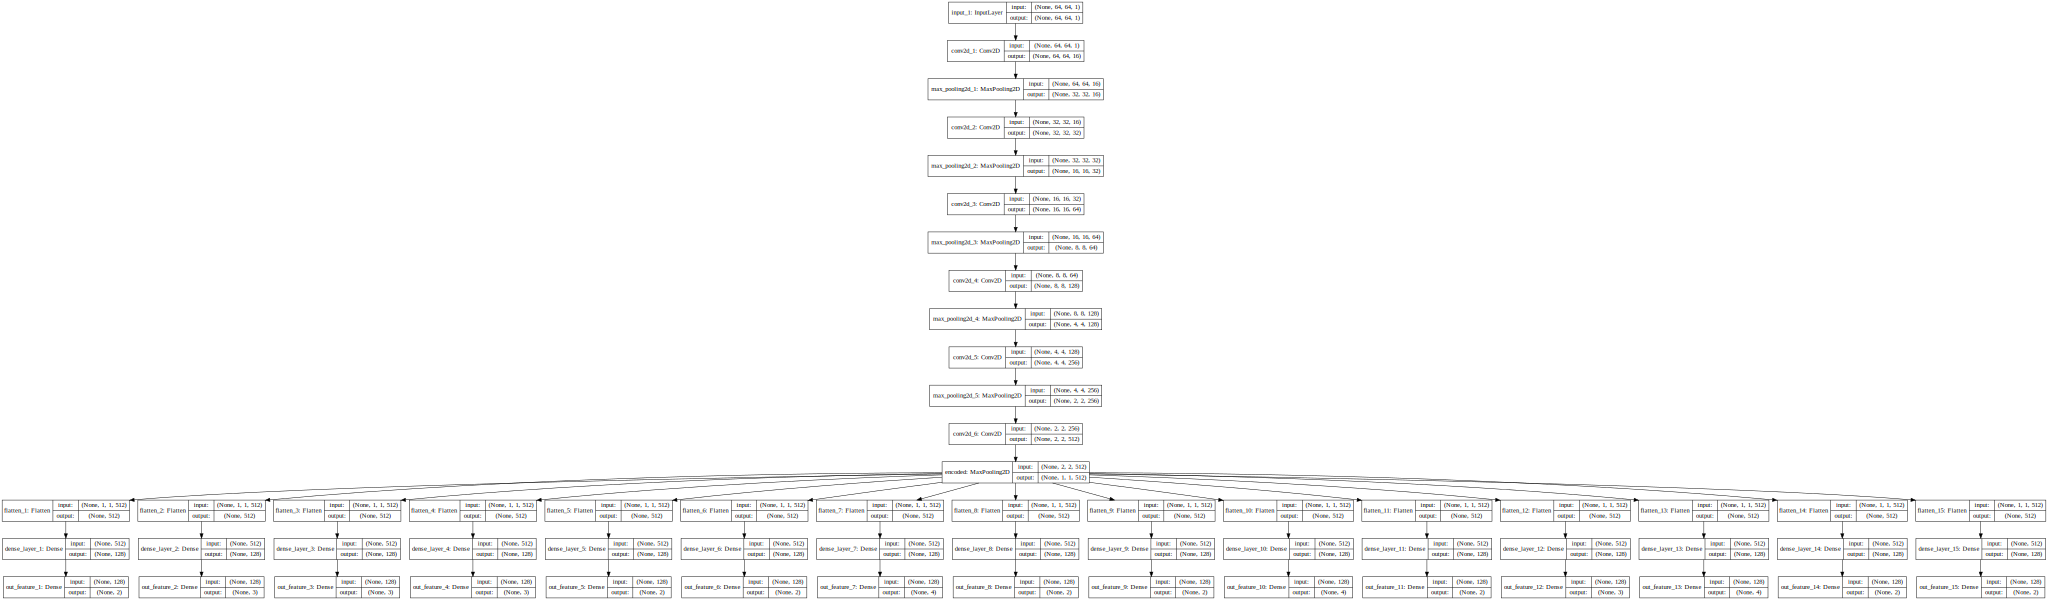

In [12]:
SVG(model_to_dot(human_features, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
feature_lengths = {}
for col in dataset_columns[1:]:
    feature_lengths[col] = len(csv_data[col].unique())
feature_lengths = list(feature_lengths.values())
feature_lengths

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

In [14]:
# df_data[df_data['f8']==2]

In [15]:
# im = images[images['image'].str.match('1229b')]
# im.iloc[0]['image']

In [16]:

# stop_at = 20
# identitycounter = 1
# unique_writers = list(set(list(x[:4] for x in df_data['ImageId'])))
# for writer in unique_writers:
#     print(identitycounter*100/stop_at, end='\r')
#     writer_samples = list(images[images['image'].str.match(writer)]['image'])
# #     print('lne',len(writer_samples))
#     f,ax = plt.subplots(1,len(writer_samples))
#     f.subplots_adjust(hspace = .5, wspace=.15)
#     f.set_size_inches(15,15)
#     imgcounter = 0
#     for sample in writer_samples:
#         imagepath = os.path.join(image_path,sample)
#         raw_img = cv2.imread(imagepath)
#         if len(writer_samples)>1:
#             ax[imgcounter].imshow(raw_img)
#             ax[imgcounter].set_title(writer+'\n'+sample)
#         else:
#             ax.imshow(raw_img)
#             ax.set_title(writer+'\n'+sample)
# #         ax[imgcounter].axis('off')
#         imgcounter+=1
#         if imgcounter == stop_at:
#             break
#     imgcounter=0
#     identitycounter += 1
#     if identitycounter == stop_at+1:
#         break

In [17]:
# csv_data[csv_data['ImageId'].str.match('1302c')]

In [18]:

def datagen(batch_size,image_path,list_of_writers, vshift = (-64,64) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:
#         counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        
        writer_index = np.random.randint(0,len(list_of_writers))
        
#         for writer_index in writer_indexes:
#             class_vectors = []
#             features = None
        imagename = list_of_writers[writer_index]
#             print('-->',csv_data['imagename'][0],imagename)
#             display(csv_data[csv_data['imagename']==imagename].values[0][1:])
        features = csv_data[csv_data['imagename']==imagename].values
        if len(features)==0:
#             print('no features', imagename)
            continue
        features = features[0][1:]-1
#             print(features)
#             print(writer)
#             writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
#             if len(writer_samples) == 0:
#                 continue
#             writer_sample_index = np.random.randint(0,len(writer_samples))

#             #     unique_writers_count[writer] = len(writer_samples)
# #             print('writer_sample_index:',writer_sample_index)
#             csv_writer = writer_samples[writer_sample_index][:5]


        loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
        rand = np.random.randint(vshift[0],vshift[1])
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features)
#         print(imagename)
        counter+=1
#         print('counter:', counter, end='\r')
        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose()
            out_cat_features = []
            for i in range(len(feature_list)):
#                 print(feature_list[1])
                out_cat_features.append(to_categorical(feature_list[i],num_classes=feature_lengths[i]))
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]    

In [19]:

batch_size = 64

tg = datagen(batch_size,image_path=train_path,vshift=(-10,10),list_of_writers=train_images)
vg = datagen(batch_size,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)


In [20]:
# images
inputs,o = next(tg)
print(inputs.shape)
for op in o:
    print((np.argmax(op, axis=1)+1)[0])
#     print('------')
# feature_list

(64, 64, 64, 1)
1
3
3
2
2
2
4
1
1
2
2
2
2
1
2


In [21]:
csv_data[csv_data['imagename']=='0066c_num3.png'].values[0][1:]

array([2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1], dtype=object)

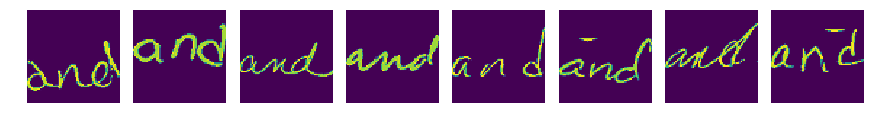

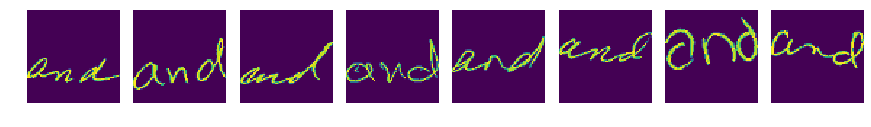

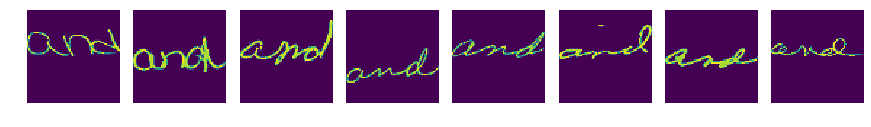

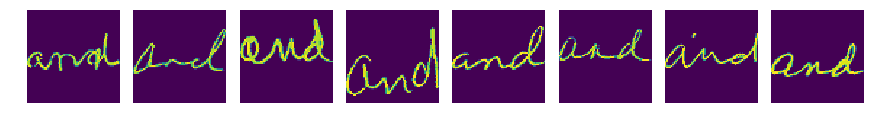

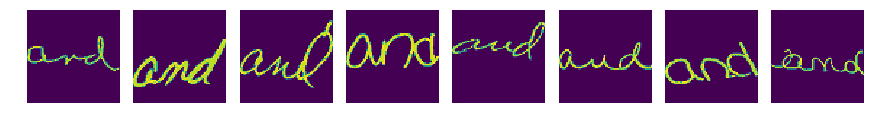

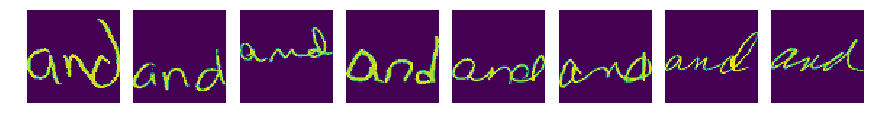

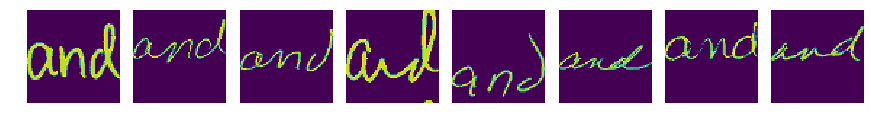

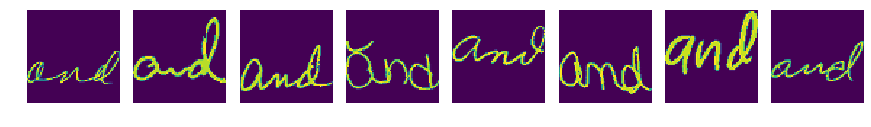

In [22]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [23]:
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0
# lossWeights["out_feature_1"] = 10.0
# lossWeights["out_feature_2"] = 8.0
# lossWeights["out_feature_3"] = 0.1
# lossWeights["out_feature_4"] = 8.0
# lossWeights["out_feature_5"] = 1.0
# lossWeights["out_feature_6"] = 5.0
# lossWeights["out_feature_7"] = 5.0
# lossWeights["out_feature_8"] = 10.0


In [24]:
mc = ModelCheckpoint(filepath='weights/15-Multitask-TrainableEncoder-Shuffled_v1.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')

In [25]:
EPOCHS = 50000
INIT_LR = 0.0001
opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# opt = Adadelta(lr=INIT_LR, decay=1e-04)

# feat_extractor.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])


human_features.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [26]:
# human_features.load_weights('human_features_weights_v3.h5')
# inputs,o = next(vg)
# for i in range(64):
#     print(i)
#     f_probs = human_features.predict(np.expand_dims(inputs[i],0))
# #     print(f_probs)
#     for prob in f_probs:
#         print(np.argmax(prob),end=',')
#     print('++++++++++++')
# human_features.load_weights('15_human_features_weights_Shuffled_v1.h5')

In [27]:
# human_features.load_weights('weights/15-Multitask-TrainableEncoder-Shuffled_v1.h5')
hist = human_features.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

Epoch 1/50000

Epoch 00001: val_loss improved from inf to 15.93392, saving model to weights/15-Multitask-TrainableEncoder-Shuffled_v1.h5
Epoch 2/50000

Epoch 00002: val_loss improved from 15.93392 to 15.05476, saving model to weights/15-Multitask-TrainableEncoder-Shuffled_v1.h5
Epoch 3/50000

Epoch 00003: val_loss did not improve from 15.05476
Epoch 4/50000

Epoch 00004: val_loss improved from 15.05476 to 14.58551, saving model to weights/15-Multitask-TrainableEncoder-Shuffled_v1.h5
Epoch 5/50000

Epoch 00005: val_loss did not improve from 14.58551
Epoch 6/50000

Epoch 00006: val_loss improved from 14.58551 to 14.39380, saving model to weights/15-Multitask-TrainableEncoder-Shuffled_v1.h5
Epoch 7/50000

Epoch 00007: val_loss did not improve from 14.39380
Epoch 8/50000

Epoch 00008: val_loss improved from 14.39380 to 14.21678, saving model to weights/15-Multitask-TrainableEncoder-Shuffled_v1.h5
Epoch 9/50000

Epoch 00009: val_loss did not improve from 14.21678
Epoch 10/50000

Epoch 00010


Epoch 00097: val_loss did not improve from 9.64616
Epoch 98/50000

Epoch 00098: val_loss did not improve from 9.64616
Epoch 99/50000

Epoch 00099: val_loss did not improve from 9.64616
Epoch 100/50000

Epoch 00100: val_loss did not improve from 9.64616
Epoch 101/50000

Epoch 00101: val_loss did not improve from 9.64616
Epoch 102/50000

Epoch 00102: val_loss did not improve from 9.64616
Epoch 103/50000

Epoch 00103: val_loss did not improve from 9.64616
Epoch 104/50000

Epoch 00104: val_loss did not improve from 9.64616
Epoch 105/50000

Epoch 00105: val_loss did not improve from 9.64616
Epoch 106/50000

Epoch 00106: val_loss did not improve from 9.64616
Epoch 107/50000

Epoch 00107: val_loss did not improve from 9.64616
Epoch 108/50000

Epoch 00108: val_loss did not improve from 9.64616
Epoch 109/50000

Epoch 00109: val_loss did not improve from 9.64616
Epoch 110/50000

Epoch 00110: val_loss did not improve from 9.64616
Epoch 111/50000

Epoch 00111: val_loss did not improve from 9.6461


Epoch 00213: val_loss did not improve from 8.69446
Epoch 214/50000

Epoch 00214: val_loss did not improve from 8.69446
Epoch 215/50000

Epoch 00215: val_loss did not improve from 8.69446
Epoch 216/50000

Epoch 00216: val_loss did not improve from 8.69446
Epoch 217/50000

Epoch 00217: val_loss did not improve from 8.69446
Epoch 218/50000

Epoch 00218: val_loss did not improve from 8.69446
Epoch 219/50000

Epoch 00219: val_loss did not improve from 8.69446
Epoch 220/50000

Epoch 00220: val_loss did not improve from 8.69446
Epoch 221/50000

Epoch 00221: val_loss improved from 8.69446 to 8.43445, saving model to weights/15-Multitask-TrainableEncoder-Shuffled_v1.h5
Epoch 222/50000

Epoch 00222: val_loss did not improve from 8.43445
Epoch 223/50000

Epoch 00223: val_loss did not improve from 8.43445
Epoch 224/50000

Epoch 00224: val_loss did not improve from 8.43445
Epoch 225/50000

Epoch 00225: val_loss did not improve from 8.43445
Epoch 226/50000

Epoch 00226: val_loss did not improve fro


Epoch 00331: val_loss did not improve from 8.25341
Epoch 332/50000

Epoch 00332: val_loss did not improve from 8.25341
Epoch 333/50000

Epoch 00333: val_loss did not improve from 8.25341
Epoch 334/50000

Epoch 00334: val_loss did not improve from 8.25341
Epoch 335/50000

Epoch 00335: val_loss did not improve from 8.25341
Epoch 336/50000

Epoch 00336: val_loss did not improve from 8.25341
Epoch 337/50000

Epoch 00337: val_loss improved from 8.25341 to 7.99372, saving model to weights/15-Multitask-TrainableEncoder-Shuffled_v1.h5
Epoch 338/50000

Epoch 00338: val_loss did not improve from 7.99372
Epoch 339/50000

Epoch 00339: val_loss did not improve from 7.99372
Epoch 340/50000

Epoch 00340: val_loss did not improve from 7.99372
Epoch 341/50000

Epoch 00341: val_loss did not improve from 7.99372
Epoch 342/50000

Epoch 00342: val_loss did not improve from 7.99372
Epoch 343/50000

Epoch 00343: val_loss did not improve from 7.99372
Epoch 344/50000

Epoch 00344: val_loss did not improve fro


Epoch 00449: val_loss did not improve from 7.86650
Epoch 450/50000

Epoch 00450: val_loss did not improve from 7.86650
Epoch 451/50000

Epoch 00451: val_loss did not improve from 7.86650
Epoch 452/50000

Epoch 00452: val_loss did not improve from 7.86650
Epoch 453/50000

Epoch 00453: val_loss did not improve from 7.86650
Epoch 454/50000

Epoch 00454: val_loss did not improve from 7.86650
Epoch 455/50000

Epoch 00455: val_loss did not improve from 7.86650
Epoch 456/50000

Epoch 00456: val_loss did not improve from 7.86650
Epoch 457/50000

Epoch 00457: val_loss did not improve from 7.86650
Epoch 458/50000

Epoch 00458: val_loss did not improve from 7.86650
Epoch 459/50000

Epoch 00459: val_loss did not improve from 7.86650
Epoch 460/50000

Epoch 00460: val_loss did not improve from 7.86650
Epoch 461/50000

Epoch 00461: val_loss did not improve from 7.86650
Epoch 462/50000

Epoch 00462: val_loss did not improve from 7.86650
Epoch 463/50000

Epoch 00463: val_loss did not improve from 7.86


Epoch 00566: val_loss did not improve from 7.48411
Epoch 567/50000

Epoch 00567: val_loss did not improve from 7.48411
Epoch 568/50000

Epoch 00568: val_loss did not improve from 7.48411
Epoch 569/50000

Epoch 00569: val_loss did not improve from 7.48411
Epoch 570/50000

Epoch 00570: val_loss did not improve from 7.48411
Epoch 571/50000

Epoch 00571: val_loss did not improve from 7.48411
Epoch 572/50000

Epoch 00572: val_loss did not improve from 7.48411
Epoch 573/50000

Epoch 00573: val_loss did not improve from 7.48411
Epoch 574/50000

Epoch 00574: val_loss did not improve from 7.48411
Epoch 575/50000

Epoch 00575: val_loss did not improve from 7.48411
Epoch 576/50000

Epoch 00576: val_loss did not improve from 7.48411
Epoch 577/50000

Epoch 00577: val_loss did not improve from 7.48411
Epoch 578/50000

Epoch 00578: val_loss did not improve from 7.48411
Epoch 579/50000

Epoch 00579: val_loss did not improve from 7.48411
Epoch 580/50000

Epoch 00580: val_loss did not improve from 7.48


Epoch 00686: val_loss did not improve from 7.30277
Epoch 687/50000

Epoch 00687: val_loss did not improve from 7.30277
Epoch 688/50000

Epoch 00688: val_loss did not improve from 7.30277
Epoch 689/50000

Epoch 00689: val_loss did not improve from 7.30277
Epoch 690/50000

Epoch 00690: val_loss did not improve from 7.30277
Epoch 691/50000

Epoch 00691: val_loss improved from 7.30277 to 7.08147, saving model to weights/15-Multitask-TrainableEncoder-Shuffled_v1.h5
Epoch 692/50000

Epoch 00692: val_loss did not improve from 7.08147
Epoch 693/50000

Epoch 00693: val_loss did not improve from 7.08147
Epoch 694/50000

Epoch 00694: val_loss did not improve from 7.08147
Epoch 695/50000

Epoch 00695: val_loss did not improve from 7.08147
Epoch 696/50000

Epoch 00696: val_loss did not improve from 7.08147
Epoch 697/50000

Epoch 00697: val_loss did not improve from 7.08147
Epoch 698/50000

Epoch 00698: val_loss did not improve from 7.08147
Epoch 699/50000

Epoch 00699: val_loss did not improve fro


Epoch 00806: val_loss did not improve from 7.08147
Epoch 807/50000

Epoch 00807: val_loss did not improve from 7.08147
Epoch 808/50000

Epoch 00808: val_loss did not improve from 7.08147
Epoch 809/50000

Epoch 00809: val_loss did not improve from 7.08147
Epoch 810/50000

Epoch 00810: val_loss did not improve from 7.08147
Epoch 811/50000

Epoch 00811: val_loss did not improve from 7.08147
Epoch 812/50000

Epoch 00812: val_loss did not improve from 7.08147
Epoch 813/50000

Epoch 00813: val_loss did not improve from 7.08147
Epoch 814/50000

Epoch 00814: val_loss did not improve from 7.08147
Epoch 815/50000

Epoch 00815: val_loss did not improve from 7.08147
Epoch 816/50000

Epoch 00816: val_loss did not improve from 7.08147
Epoch 817/50000

Epoch 00817: val_loss did not improve from 7.08147
Epoch 818/50000

Epoch 00818: val_loss did not improve from 7.08147
Epoch 819/50000

Epoch 00819: val_loss did not improve from 7.08147
Epoch 820/50000

Epoch 00820: val_loss did not improve from 7.08


Epoch 00926: val_loss did not improve from 6.91019
Epoch 927/50000

Epoch 00927: val_loss did not improve from 6.91019
Epoch 928/50000

Epoch 00928: val_loss did not improve from 6.91019
Epoch 929/50000

Epoch 00929: val_loss did not improve from 6.91019
Epoch 930/50000

Epoch 00930: val_loss did not improve from 6.91019
Epoch 931/50000

Epoch 00931: val_loss did not improve from 6.91019
Epoch 932/50000

Epoch 00932: val_loss did not improve from 6.91019
Epoch 933/50000

Epoch 00933: val_loss did not improve from 6.91019
Epoch 934/50000

Epoch 00934: val_loss did not improve from 6.91019
Epoch 935/50000

Epoch 00935: val_loss did not improve from 6.91019
Epoch 936/50000

Epoch 00936: val_loss did not improve from 6.91019
Epoch 937/50000

Epoch 00937: val_loss did not improve from 6.91019
Epoch 938/50000

Epoch 00938: val_loss did not improve from 6.91019
Epoch 939/50000

Epoch 00939: val_loss did not improve from 6.91019
Epoch 940/50000

Epoch 00940: val_loss did not improve from 6.91


Epoch 01046: val_loss did not improve from 6.91019
Epoch 1047/50000

Epoch 01047: val_loss did not improve from 6.91019
Epoch 1048/50000

Epoch 01048: val_loss did not improve from 6.91019
Epoch 1049/50000

Epoch 01049: val_loss did not improve from 6.91019
Epoch 1050/50000

Epoch 01050: val_loss did not improve from 6.91019
Epoch 1051/50000

Epoch 01051: val_loss did not improve from 6.91019
Epoch 1052/50000

Epoch 01052: val_loss did not improve from 6.91019
Epoch 1053/50000

Epoch 01053: val_loss did not improve from 6.91019
Epoch 1054/50000

Epoch 01054: val_loss did not improve from 6.91019
Epoch 1055/50000

Epoch 01055: val_loss did not improve from 6.91019
Epoch 1056/50000

Epoch 01056: val_loss did not improve from 6.91019
Epoch 1057/50000

Epoch 01057: val_loss did not improve from 6.91019
Epoch 1058/50000

Epoch 01058: val_loss did not improve from 6.91019
Epoch 1059/50000

Epoch 01059: val_loss did not improve from 6.91019
Epoch 1060/50000

Epoch 01060: val_loss did not imp


Epoch 01165: val_loss did not improve from 6.91019
Epoch 1166/50000

Epoch 01166: val_loss did not improve from 6.91019
Epoch 1167/50000

Epoch 01167: val_loss did not improve from 6.91019
Epoch 1168/50000

Epoch 01168: val_loss did not improve from 6.91019
Epoch 1169/50000

Epoch 01169: val_loss did not improve from 6.91019
Epoch 1170/50000

Epoch 01170: val_loss did not improve from 6.91019
Epoch 1171/50000

Epoch 01171: val_loss did not improve from 6.91019
Epoch 1172/50000

Epoch 01172: val_loss did not improve from 6.91019
Epoch 1173/50000

Epoch 01173: val_loss did not improve from 6.91019
Epoch 1174/50000

Epoch 01174: val_loss did not improve from 6.91019
Epoch 1175/50000

Epoch 01175: val_loss did not improve from 6.91019
Epoch 1176/50000

Epoch 01176: val_loss did not improve from 6.91019
Epoch 1177/50000

Epoch 01177: val_loss did not improve from 6.91019
Epoch 1178/50000

Epoch 01178: val_loss did not improve from 6.91019
Epoch 1179/50000

Epoch 01179: val_loss did not imp


Epoch 01283: val_loss did not improve from 6.66812
Epoch 1284/50000

Epoch 01284: val_loss did not improve from 6.66812
Epoch 1285/50000

Epoch 01285: val_loss did not improve from 6.66812
Epoch 1286/50000

Epoch 01286: val_loss did not improve from 6.66812
Epoch 1287/50000

Epoch 01287: val_loss did not improve from 6.66812
Epoch 1288/50000

Epoch 01288: val_loss did not improve from 6.66812
Epoch 1289/50000

Epoch 01289: val_loss did not improve from 6.66812
Epoch 1290/50000

Epoch 01290: val_loss did not improve from 6.66812
Epoch 1291/50000

Epoch 01291: val_loss did not improve from 6.66812
Epoch 1292/50000

Epoch 01292: val_loss did not improve from 6.66812
Epoch 1293/50000

Epoch 01293: val_loss did not improve from 6.66812
Epoch 1294/50000

Epoch 01294: val_loss did not improve from 6.66812
Epoch 1295/50000

Epoch 01295: val_loss did not improve from 6.66812
Epoch 1296/50000

Epoch 01296: val_loss did not improve from 6.66812
Epoch 1297/50000

Epoch 01297: val_loss did not imp


Epoch 01401: val_loss did not improve from 6.54688
Epoch 1402/50000

Epoch 01402: val_loss did not improve from 6.54688
Epoch 1403/50000

Epoch 01403: val_loss did not improve from 6.54688
Epoch 1404/50000

Epoch 01404: val_loss did not improve from 6.54688
Epoch 1405/50000

Epoch 01405: val_loss did not improve from 6.54688
Epoch 1406/50000

Epoch 01406: val_loss did not improve from 6.54688
Epoch 1407/50000

Epoch 01407: val_loss did not improve from 6.54688
Epoch 1408/50000

Epoch 01408: val_loss did not improve from 6.54688
Epoch 1409/50000

Epoch 01409: val_loss did not improve from 6.54688
Epoch 1410/50000

Epoch 01410: val_loss did not improve from 6.54688
Epoch 1411/50000

Epoch 01411: val_loss did not improve from 6.54688
Epoch 1412/50000

Epoch 01412: val_loss did not improve from 6.54688
Epoch 1413/50000

Epoch 01413: val_loss did not improve from 6.54688
Epoch 1414/50000

Epoch 01414: val_loss did not improve from 6.54688
Epoch 1415/50000

Epoch 01415: val_loss did not imp


Epoch 01520: val_loss did not improve from 6.54688
Epoch 1521/50000

Epoch 01521: val_loss did not improve from 6.54688
Epoch 1522/50000

Epoch 01522: val_loss did not improve from 6.54688
Epoch 1523/50000

Epoch 01523: val_loss did not improve from 6.54688
Epoch 1524/50000

Epoch 01524: val_loss did not improve from 6.54688
Epoch 1525/50000

Epoch 01525: val_loss did not improve from 6.54688
Epoch 1526/50000

Epoch 01526: val_loss did not improve from 6.54688
Epoch 1527/50000

Epoch 01527: val_loss did not improve from 6.54688
Epoch 1528/50000

Epoch 01528: val_loss did not improve from 6.54688
Epoch 1529/50000

Epoch 01529: val_loss did not improve from 6.54688
Epoch 1530/50000

Epoch 01530: val_loss did not improve from 6.54688
Epoch 1531/50000

Epoch 01531: val_loss did not improve from 6.54688
Epoch 1532/50000

Epoch 01532: val_loss did not improve from 6.54688
Epoch 1533/50000

Epoch 01533: val_loss did not improve from 6.54688
Epoch 1534/50000

Epoch 01534: val_loss did not imp


Epoch 01639: val_loss did not improve from 6.54688
Epoch 1640/50000

Epoch 01640: val_loss did not improve from 6.54688
Epoch 1641/50000

Epoch 01641: val_loss did not improve from 6.54688
Epoch 1642/50000

Epoch 01642: val_loss did not improve from 6.54688
Epoch 1643/50000

Epoch 01643: val_loss did not improve from 6.54688
Epoch 1644/50000

Epoch 01644: val_loss did not improve from 6.54688
Epoch 1645/50000

Epoch 01645: val_loss did not improve from 6.54688
Epoch 1646/50000

Epoch 01646: val_loss did not improve from 6.54688
Epoch 1647/50000

Epoch 01647: val_loss did not improve from 6.54688
Epoch 1648/50000

Epoch 01648: val_loss did not improve from 6.54688
Epoch 1649/50000

Epoch 01649: val_loss did not improve from 6.54688
Epoch 1650/50000

Epoch 01650: val_loss did not improve from 6.54688
Epoch 1651/50000

Epoch 01651: val_loss did not improve from 6.54688
Epoch 1652/50000

Epoch 01652: val_loss did not improve from 6.54688
Epoch 1653/50000

Epoch 01653: val_loss did not imp


Epoch 01758: val_loss did not improve from 6.54688
Epoch 1759/50000

Epoch 01759: val_loss did not improve from 6.54688
Epoch 1760/50000

Epoch 01760: val_loss did not improve from 6.54688
Epoch 1761/50000

Epoch 01761: val_loss did not improve from 6.54688
Epoch 1762/50000

Epoch 01762: val_loss did not improve from 6.54688
Epoch 1763/50000

Epoch 01763: val_loss did not improve from 6.54688
Epoch 1764/50000

Epoch 01764: val_loss did not improve from 6.54688
Epoch 1765/50000

Epoch 01765: val_loss did not improve from 6.54688
Epoch 1766/50000

Epoch 01766: val_loss did not improve from 6.54688
Epoch 1767/50000

Epoch 01767: val_loss did not improve from 6.54688
Epoch 1768/50000

Epoch 01768: val_loss did not improve from 6.54688
Epoch 1769/50000

Epoch 01769: val_loss did not improve from 6.54688
Epoch 1770/50000

Epoch 01770: val_loss did not improve from 6.54688
Epoch 1771/50000

Epoch 01771: val_loss did not improve from 6.54688
Epoch 1772/50000

Epoch 01772: val_loss did not imp


Epoch 01876: val_loss did not improve from 6.50902
Epoch 1877/50000

Epoch 01877: val_loss did not improve from 6.50902
Epoch 1878/50000

Epoch 01878: val_loss did not improve from 6.50902
Epoch 1879/50000

Epoch 01879: val_loss did not improve from 6.50902
Epoch 1880/50000

Epoch 01880: val_loss did not improve from 6.50902
Epoch 1881/50000

Epoch 01881: val_loss did not improve from 6.50902
Epoch 1882/50000

Epoch 01882: val_loss did not improve from 6.50902
Epoch 1883/50000

Epoch 01883: val_loss did not improve from 6.50902
Epoch 1884/50000

Epoch 01884: val_loss did not improve from 6.50902
Epoch 1885/50000

Epoch 01885: val_loss did not improve from 6.50902
Epoch 1886/50000

Epoch 01886: val_loss did not improve from 6.50902
Epoch 1887/50000

Epoch 01887: val_loss did not improve from 6.50902
Epoch 1888/50000

Epoch 01888: val_loss did not improve from 6.50902
Epoch 1889/50000

Epoch 01889: val_loss did not improve from 6.50902
Epoch 1890/50000

Epoch 01890: val_loss did not imp


Epoch 01994: val_loss did not improve from 6.46791
Epoch 1995/50000

Epoch 01995: val_loss did not improve from 6.46791
Epoch 1996/50000

Epoch 01996: val_loss did not improve from 6.46791
Epoch 1997/50000

Epoch 01997: val_loss did not improve from 6.46791
Epoch 1998/50000

Epoch 01998: val_loss did not improve from 6.46791
Epoch 1999/50000

Epoch 01999: val_loss did not improve from 6.46791
Epoch 2000/50000

Epoch 02000: val_loss did not improve from 6.46791
Epoch 2001/50000

Epoch 02001: val_loss did not improve from 6.46791
Epoch 2002/50000

Epoch 02002: val_loss did not improve from 6.46791
Epoch 2003/50000

Epoch 02003: val_loss did not improve from 6.46791
Epoch 2004/50000

Epoch 02004: val_loss did not improve from 6.46791
Epoch 2005/50000

Epoch 02005: val_loss did not improve from 6.46791
Epoch 2006/50000

Epoch 02006: val_loss did not improve from 6.46791
Epoch 2007/50000

Epoch 02007: val_loss did not improve from 6.46791
Epoch 2008/50000

Epoch 02008: val_loss did not imp


Epoch 02113: val_loss did not improve from 6.46791
Epoch 2114/50000

Epoch 02114: val_loss did not improve from 6.46791
Epoch 2115/50000

Epoch 02115: val_loss did not improve from 6.46791
Epoch 2116/50000

Epoch 02116: val_loss did not improve from 6.46791
Epoch 2117/50000

Epoch 02117: val_loss did not improve from 6.46791
Epoch 2118/50000

Epoch 02118: val_loss did not improve from 6.46791
Epoch 2119/50000

Epoch 02119: val_loss did not improve from 6.46791
Epoch 2120/50000

Epoch 02120: val_loss did not improve from 6.46791
Epoch 2121/50000

Epoch 02121: val_loss did not improve from 6.46791
Epoch 2122/50000

Epoch 02122: val_loss did not improve from 6.46791
Epoch 2123/50000

Epoch 02123: val_loss did not improve from 6.46791
Epoch 2124/50000

Epoch 02124: val_loss did not improve from 6.46791
Epoch 2125/50000

Epoch 02125: val_loss did not improve from 6.46791
Epoch 2126/50000

Epoch 02126: val_loss did not improve from 6.46791
Epoch 2127/50000

Epoch 02127: val_loss did not imp


Epoch 02232: val_loss did not improve from 6.46791
Epoch 2233/50000

Epoch 02233: val_loss did not improve from 6.46791
Epoch 2234/50000

Epoch 02234: val_loss did not improve from 6.46791
Epoch 2235/50000

Epoch 02235: val_loss did not improve from 6.46791
Epoch 2236/50000

Epoch 02236: val_loss did not improve from 6.46791
Epoch 2237/50000

Epoch 02237: val_loss did not improve from 6.46791
Epoch 2238/50000

Epoch 02238: val_loss did not improve from 6.46791
Epoch 2239/50000

Epoch 02239: val_loss did not improve from 6.46791
Epoch 2240/50000

Epoch 02240: val_loss did not improve from 6.46791
Epoch 2241/50000

Epoch 02241: val_loss did not improve from 6.46791
Epoch 2242/50000

Epoch 02242: val_loss did not improve from 6.46791
Epoch 2243/50000

Epoch 02243: val_loss did not improve from 6.46791
Epoch 2244/50000

Epoch 02244: val_loss did not improve from 6.46791
Epoch 2245/50000

Epoch 02245: val_loss did not improve from 6.46791
Epoch 2246/50000

Epoch 02246: val_loss did not imp


Epoch 02351: val_loss did not improve from 6.46791
Epoch 2352/50000

Epoch 02352: val_loss did not improve from 6.46791
Epoch 2353/50000

Epoch 02353: val_loss did not improve from 6.46791
Epoch 2354/50000

Epoch 02354: val_loss did not improve from 6.46791
Epoch 2355/50000

Epoch 02355: val_loss did not improve from 6.46791
Epoch 2356/50000

Epoch 02356: val_loss did not improve from 6.46791
Epoch 2357/50000

Epoch 02357: val_loss did not improve from 6.46791
Epoch 2358/50000

Epoch 02358: val_loss did not improve from 6.46791
Epoch 2359/50000

Epoch 02359: val_loss did not improve from 6.46791
Epoch 2360/50000

Epoch 02360: val_loss did not improve from 6.46791
Epoch 2361/50000

Epoch 02361: val_loss did not improve from 6.46791
Epoch 2362/50000

Epoch 02362: val_loss did not improve from 6.46791
Epoch 2363/50000

Epoch 02363: val_loss did not improve from 6.46791
Epoch 2364/50000

Epoch 02364: val_loss did not improve from 6.46791
Epoch 2365/50000

Epoch 02365: val_loss did not imp


Epoch 02470: val_loss did not improve from 6.46791
Epoch 2471/50000

Epoch 02471: val_loss did not improve from 6.46791
Epoch 2472/50000

Epoch 02472: val_loss did not improve from 6.46791
Epoch 2473/50000

Epoch 02473: val_loss did not improve from 6.46791
Epoch 2474/50000

Epoch 02474: val_loss did not improve from 6.46791
Epoch 2475/50000

Epoch 02475: val_loss did not improve from 6.46791
Epoch 2476/50000

Epoch 02476: val_loss did not improve from 6.46791
Epoch 2477/50000

Epoch 02477: val_loss did not improve from 6.46791
Epoch 2478/50000

Epoch 02478: val_loss did not improve from 6.46791
Epoch 2479/50000

Epoch 02479: val_loss did not improve from 6.46791
Epoch 2480/50000

Epoch 02480: val_loss did not improve from 6.46791
Epoch 2481/50000

Epoch 02481: val_loss did not improve from 6.46791
Epoch 2482/50000

Epoch 02482: val_loss did not improve from 6.46791
Epoch 2483/50000

Epoch 02483: val_loss did not improve from 6.46791
Epoch 2484/50000

Epoch 02484: val_loss did not imp


Epoch 02589: val_loss did not improve from 6.46791
Epoch 2590/50000

Epoch 02590: val_loss did not improve from 6.46791
Epoch 2591/50000

Epoch 02591: val_loss did not improve from 6.46791
Epoch 2592/50000

Epoch 02592: val_loss did not improve from 6.46791
Epoch 2593/50000

Epoch 02593: val_loss did not improve from 6.46791
Epoch 2594/50000

Epoch 02594: val_loss did not improve from 6.46791
Epoch 2595/50000

Epoch 02595: val_loss did not improve from 6.46791
Epoch 2596/50000

Epoch 02596: val_loss did not improve from 6.46791
Epoch 2597/50000

Epoch 02597: val_loss did not improve from 6.46791
Epoch 2598/50000

Epoch 02598: val_loss did not improve from 6.46791
Epoch 2599/50000

Epoch 02599: val_loss did not improve from 6.46791
Epoch 2600/50000

Epoch 02600: val_loss did not improve from 6.46791
Epoch 2601/50000

Epoch 02601: val_loss did not improve from 6.46791
Epoch 2602/50000

Epoch 02602: val_loss did not improve from 6.46791
Epoch 2603/50000

Epoch 02603: val_loss did not imp


Epoch 02707: val_loss did not improve from 6.45489
Epoch 2708/50000

Epoch 02708: val_loss did not improve from 6.45489
Epoch 2709/50000

Epoch 02709: val_loss did not improve from 6.45489
Epoch 2710/50000

Epoch 02710: val_loss did not improve from 6.45489
Epoch 2711/50000

Epoch 02711: val_loss did not improve from 6.45489
Epoch 2712/50000

Epoch 02712: val_loss did not improve from 6.45489
Epoch 2713/50000

Epoch 02713: val_loss did not improve from 6.45489
Epoch 2714/50000

Epoch 02714: val_loss did not improve from 6.45489
Epoch 2715/50000

Epoch 02715: val_loss did not improve from 6.45489
Epoch 2716/50000

Epoch 02716: val_loss did not improve from 6.45489
Epoch 2717/50000

Epoch 02717: val_loss did not improve from 6.45489
Epoch 2718/50000

Epoch 02718: val_loss did not improve from 6.45489
Epoch 2719/50000

Epoch 02719: val_loss did not improve from 6.45489
Epoch 2720/50000

Epoch 02720: val_loss did not improve from 6.45489
Epoch 2721/50000

Epoch 02721: val_loss did not imp


Epoch 02825: val_loss did not improve from 6.17849
Epoch 2826/50000

Epoch 02826: val_loss did not improve from 6.17849
Epoch 2827/50000

Epoch 02827: val_loss did not improve from 6.17849
Epoch 2828/50000

Epoch 02828: val_loss did not improve from 6.17849
Epoch 2829/50000

Epoch 02829: val_loss did not improve from 6.17849
Epoch 2830/50000

Epoch 02830: val_loss did not improve from 6.17849
Epoch 2831/50000

Epoch 02831: val_loss did not improve from 6.17849
Epoch 2832/50000

Epoch 02832: val_loss did not improve from 6.17849
Epoch 2833/50000

Epoch 02833: val_loss did not improve from 6.17849
Epoch 2834/50000

Epoch 02834: val_loss did not improve from 6.17849
Epoch 2835/50000

Epoch 02835: val_loss did not improve from 6.17849
Epoch 2836/50000

Epoch 02836: val_loss did not improve from 6.17849
Epoch 2837/50000

Epoch 02837: val_loss did not improve from 6.17849
Epoch 2838/50000

Epoch 02838: val_loss did not improve from 6.17849
Epoch 2839/50000

Epoch 02839: val_loss did not imp


Epoch 02944: val_loss did not improve from 6.17849
Epoch 2945/50000

Epoch 02945: val_loss did not improve from 6.17849
Epoch 2946/50000

Epoch 02946: val_loss did not improve from 6.17849
Epoch 2947/50000

Epoch 02947: val_loss did not improve from 6.17849
Epoch 2948/50000

Epoch 02948: val_loss did not improve from 6.17849
Epoch 2949/50000

Epoch 02949: val_loss did not improve from 6.17849
Epoch 2950/50000

Epoch 02950: val_loss did not improve from 6.17849
Epoch 2951/50000

Epoch 02951: val_loss did not improve from 6.17849
Epoch 2952/50000

Epoch 02952: val_loss did not improve from 6.17849
Epoch 2953/50000

Epoch 02953: val_loss did not improve from 6.17849
Epoch 2954/50000

Epoch 02954: val_loss did not improve from 6.17849
Epoch 2955/50000

Epoch 02955: val_loss did not improve from 6.17849
Epoch 2956/50000

Epoch 02956: val_loss did not improve from 6.17849
Epoch 2957/50000

Epoch 02957: val_loss did not improve from 6.17849
Epoch 2958/50000

Epoch 02958: val_loss did not imp


Epoch 03063: val_loss did not improve from 6.17849
Epoch 3064/50000

Epoch 03064: val_loss did not improve from 6.17849
Epoch 3065/50000

Epoch 03065: val_loss did not improve from 6.17849
Epoch 3066/50000

Epoch 03066: val_loss did not improve from 6.17849
Epoch 3067/50000

Epoch 03067: val_loss did not improve from 6.17849
Epoch 3068/50000

Epoch 03068: val_loss did not improve from 6.17849
Epoch 3069/50000

Epoch 03069: val_loss did not improve from 6.17849
Epoch 3070/50000

Epoch 03070: val_loss did not improve from 6.17849
Epoch 3071/50000

Epoch 03071: val_loss did not improve from 6.17849
Epoch 3072/50000

Epoch 03072: val_loss did not improve from 6.17849
Epoch 3073/50000

Epoch 03073: val_loss did not improve from 6.17849
Epoch 3074/50000

Epoch 03074: val_loss did not improve from 6.17849
Epoch 3075/50000

Epoch 03075: val_loss did not improve from 6.17849
Epoch 3076/50000

Epoch 03076: val_loss did not improve from 6.17849
Epoch 3077/50000

Epoch 03077: val_loss did not imp


Epoch 03182: val_loss did not improve from 6.17849
Epoch 3183/50000

Epoch 03183: val_loss did not improve from 6.17849
Epoch 3184/50000

Epoch 03184: val_loss did not improve from 6.17849
Epoch 3185/50000

Epoch 03185: val_loss did not improve from 6.17849
Epoch 3186/50000

Epoch 03186: val_loss did not improve from 6.17849
Epoch 3187/50000

Epoch 03187: val_loss did not improve from 6.17849
Epoch 3188/50000

Epoch 03188: val_loss did not improve from 6.17849
Epoch 3189/50000

Epoch 03189: val_loss did not improve from 6.17849
Epoch 3190/50000

Epoch 03190: val_loss did not improve from 6.17849
Epoch 3191/50000

Epoch 03191: val_loss did not improve from 6.17849
Epoch 3192/50000

Epoch 03192: val_loss did not improve from 6.17849
Epoch 3193/50000

Epoch 03193: val_loss did not improve from 6.17849
Epoch 3194/50000

Epoch 03194: val_loss did not improve from 6.17849
Epoch 3195/50000

Epoch 03195: val_loss did not improve from 6.17849
Epoch 3196/50000

Epoch 03196: val_loss did not imp


Epoch 03301: val_loss did not improve from 6.17849
Epoch 3302/50000

Epoch 03302: val_loss did not improve from 6.17849
Epoch 3303/50000

Epoch 03303: val_loss did not improve from 6.17849
Epoch 3304/50000

Epoch 03304: val_loss did not improve from 6.17849
Epoch 3305/50000

Epoch 03305: val_loss did not improve from 6.17849
Epoch 3306/50000

Epoch 03306: val_loss did not improve from 6.17849
Epoch 3307/50000

Epoch 03307: val_loss did not improve from 6.17849
Epoch 3308/50000

Epoch 03308: val_loss did not improve from 6.17849
Epoch 3309/50000

Epoch 03309: val_loss did not improve from 6.17849
Epoch 3310/50000

Epoch 03310: val_loss did not improve from 6.17849
Epoch 3311/50000

Epoch 03311: val_loss did not improve from 6.17849
Epoch 3312/50000

Epoch 03312: val_loss did not improve from 6.17849
Epoch 3313/50000

Epoch 03313: val_loss did not improve from 6.17849
Epoch 3314/50000

Epoch 03314: val_loss did not improve from 6.17849
Epoch 3315/50000

Epoch 03315: val_loss did not imp


Epoch 03420: val_loss did not improve from 6.17849
Epoch 3421/50000

Epoch 03421: val_loss did not improve from 6.17849
Epoch 3422/50000

Epoch 03422: val_loss did not improve from 6.17849
Epoch 3423/50000

Epoch 03423: val_loss did not improve from 6.17849
Epoch 3424/50000

Epoch 03424: val_loss did not improve from 6.17849
Epoch 3425/50000

Epoch 03425: val_loss did not improve from 6.17849
Epoch 3426/50000

Epoch 03426: val_loss did not improve from 6.17849
Epoch 3427/50000

Epoch 03427: val_loss did not improve from 6.17849
Epoch 3428/50000

Epoch 03428: val_loss did not improve from 6.17849
Epoch 3429/50000

Epoch 03429: val_loss did not improve from 6.17849
Epoch 3430/50000

Epoch 03430: val_loss did not improve from 6.17849
Epoch 3431/50000

Epoch 03431: val_loss did not improve from 6.17849
Epoch 3432/50000

Epoch 03432: val_loss did not improve from 6.17849
Epoch 3433/50000

Epoch 03433: val_loss did not improve from 6.17849
Epoch 3434/50000

Epoch 03434: val_loss did not imp


Epoch 03539: val_loss did not improve from 6.17849
Epoch 3540/50000

Epoch 03540: val_loss did not improve from 6.17849
Epoch 3541/50000

Epoch 03541: val_loss did not improve from 6.17849
Epoch 3542/50000

Epoch 03542: val_loss did not improve from 6.17849
Epoch 3543/50000

Epoch 03543: val_loss did not improve from 6.17849
Epoch 3544/50000

Epoch 03544: val_loss did not improve from 6.17849
Epoch 3545/50000

Epoch 03545: val_loss did not improve from 6.17849
Epoch 3546/50000

Epoch 03546: val_loss did not improve from 6.17849
Epoch 3547/50000

Epoch 03547: val_loss did not improve from 6.17849
Epoch 3548/50000

Epoch 03548: val_loss did not improve from 6.17849
Epoch 3549/50000

Epoch 03549: val_loss did not improve from 6.17849
Epoch 3550/50000

Epoch 03550: val_loss did not improve from 6.17849
Epoch 3551/50000

Epoch 03551: val_loss did not improve from 6.17849
Epoch 3552/50000

Epoch 03552: val_loss did not improve from 6.17849
Epoch 3553/50000

Epoch 03553: val_loss did not imp


Epoch 03658: val_loss did not improve from 6.17849
Epoch 3659/50000

Epoch 03659: val_loss did not improve from 6.17849
Epoch 3660/50000

Epoch 03660: val_loss did not improve from 6.17849
Epoch 3661/50000

Epoch 03661: val_loss did not improve from 6.17849
Epoch 3662/50000

Epoch 03662: val_loss did not improve from 6.17849
Epoch 3663/50000

Epoch 03663: val_loss did not improve from 6.17849
Epoch 3664/50000

Epoch 03664: val_loss did not improve from 6.17849
Epoch 3665/50000

Epoch 03665: val_loss did not improve from 6.17849
Epoch 3666/50000

Epoch 03666: val_loss did not improve from 6.17849
Epoch 3667/50000

Epoch 03667: val_loss did not improve from 6.17849
Epoch 3668/50000

Epoch 03668: val_loss did not improve from 6.17849
Epoch 3669/50000

Epoch 03669: val_loss did not improve from 6.17849
Epoch 3670/50000

Epoch 03670: val_loss did not improve from 6.17849
Epoch 3671/50000

Epoch 03671: val_loss did not improve from 6.17849
Epoch 3672/50000

Epoch 03672: val_loss did not imp


Epoch 03777: val_loss did not improve from 6.17849
Epoch 3778/50000

Epoch 03778: val_loss did not improve from 6.17849
Epoch 3779/50000

Epoch 03779: val_loss did not improve from 6.17849
Epoch 3780/50000

Epoch 03780: val_loss did not improve from 6.17849
Epoch 3781/50000

Epoch 03781: val_loss did not improve from 6.17849
Epoch 3782/50000

Epoch 03782: val_loss did not improve from 6.17849
Epoch 3783/50000

Epoch 03783: val_loss did not improve from 6.17849
Epoch 3784/50000

Epoch 03784: val_loss did not improve from 6.17849
Epoch 3785/50000

Epoch 03785: val_loss did not improve from 6.17849
Epoch 3786/50000

Epoch 03786: val_loss did not improve from 6.17849
Epoch 3787/50000

Epoch 03787: val_loss did not improve from 6.17849
Epoch 3788/50000

Epoch 03788: val_loss did not improve from 6.17849
Epoch 3789/50000

Epoch 03789: val_loss did not improve from 6.17849
Epoch 3790/50000

Epoch 03790: val_loss did not improve from 6.17849
Epoch 3791/50000

Epoch 03791: val_loss did not imp


Epoch 03896: val_loss did not improve from 6.17849
Epoch 3897/50000

Epoch 03897: val_loss did not improve from 6.17849
Epoch 3898/50000

Epoch 03898: val_loss did not improve from 6.17849
Epoch 3899/50000

Epoch 03899: val_loss did not improve from 6.17849
Epoch 3900/50000

Epoch 03900: val_loss did not improve from 6.17849
Epoch 3901/50000

Epoch 03901: val_loss did not improve from 6.17849
Epoch 3902/50000

Epoch 03902: val_loss did not improve from 6.17849
Epoch 3903/50000

Epoch 03903: val_loss did not improve from 6.17849
Epoch 3904/50000

Epoch 03904: val_loss did not improve from 6.17849
Epoch 3905/50000

Epoch 03905: val_loss did not improve from 6.17849
Epoch 3906/50000

Epoch 03906: val_loss did not improve from 6.17849
Epoch 3907/50000

Epoch 03907: val_loss did not improve from 6.17849
Epoch 3908/50000

Epoch 03908: val_loss did not improve from 6.17849
Epoch 3909/50000

Epoch 03909: val_loss did not improve from 6.17849
Epoch 3910/50000

Epoch 03910: val_loss did not imp


Epoch 04015: val_loss did not improve from 6.17849
Epoch 4016/50000

Epoch 04016: val_loss did not improve from 6.17849
Epoch 4017/50000

Epoch 04017: val_loss did not improve from 6.17849
Epoch 4018/50000

Epoch 04018: val_loss did not improve from 6.17849
Epoch 4019/50000

Epoch 04019: val_loss did not improve from 6.17849
Epoch 4020/50000

Epoch 04020: val_loss did not improve from 6.17849
Epoch 4021/50000

Epoch 04021: val_loss did not improve from 6.17849
Epoch 4022/50000

Epoch 04022: val_loss did not improve from 6.17849
Epoch 4023/50000

Epoch 04023: val_loss did not improve from 6.17849
Epoch 4024/50000

Epoch 04024: val_loss did not improve from 6.17849
Epoch 4025/50000

Epoch 04025: val_loss did not improve from 6.17849
Epoch 4026/50000

Epoch 04026: val_loss did not improve from 6.17849
Epoch 4027/50000

Epoch 04027: val_loss did not improve from 6.17849
Epoch 4028/50000

Epoch 04028: val_loss did not improve from 6.17849
Epoch 4029/50000

Epoch 04029: val_loss did not imp


Epoch 04133: val_loss did not improve from 6.17514
Epoch 4134/50000

Epoch 04134: val_loss did not improve from 6.17514
Epoch 4135/50000

Epoch 04135: val_loss did not improve from 6.17514
Epoch 4136/50000

Epoch 04136: val_loss did not improve from 6.17514
Epoch 4137/50000

Epoch 04137: val_loss did not improve from 6.17514
Epoch 4138/50000

Epoch 04138: val_loss did not improve from 6.17514
Epoch 4139/50000

Epoch 04139: val_loss did not improve from 6.17514
Epoch 4140/50000

Epoch 04140: val_loss did not improve from 6.17514
Epoch 4141/50000

Epoch 04141: val_loss did not improve from 6.17514
Epoch 4142/50000

Epoch 04142: val_loss did not improve from 6.17514
Epoch 4143/50000

Epoch 04143: val_loss did not improve from 6.17514
Epoch 4144/50000

Epoch 04144: val_loss did not improve from 6.17514
Epoch 4145/50000

Epoch 04145: val_loss did not improve from 6.17514
Epoch 4146/50000

Epoch 04146: val_loss did not improve from 6.17514
Epoch 4147/50000

Epoch 04147: val_loss did not imp


Epoch 04251: val_loss did not improve from 6.05423
Epoch 4252/50000

Epoch 04252: val_loss did not improve from 6.05423
Epoch 4253/50000

Epoch 04253: val_loss did not improve from 6.05423
Epoch 4254/50000

Epoch 04254: val_loss did not improve from 6.05423
Epoch 4255/50000

Epoch 04255: val_loss did not improve from 6.05423
Epoch 4256/50000

Epoch 04256: val_loss did not improve from 6.05423
Epoch 4257/50000

Epoch 04257: val_loss did not improve from 6.05423
Epoch 4258/50000

Epoch 04258: val_loss did not improve from 6.05423
Epoch 4259/50000

Epoch 04259: val_loss did not improve from 6.05423
Epoch 4260/50000

Epoch 04260: val_loss did not improve from 6.05423
Epoch 4261/50000

Epoch 04261: val_loss did not improve from 6.05423
Epoch 4262/50000

Epoch 04262: val_loss did not improve from 6.05423
Epoch 4263/50000

Epoch 04263: val_loss did not improve from 6.05423
Epoch 4264/50000

Epoch 04264: val_loss did not improve from 6.05423
Epoch 4265/50000

Epoch 04265: val_loss did not imp


Epoch 04370: val_loss did not improve from 6.05423
Epoch 4371/50000

Epoch 04371: val_loss did not improve from 6.05423
Epoch 4372/50000

Epoch 04372: val_loss did not improve from 6.05423
Epoch 4373/50000

Epoch 04373: val_loss did not improve from 6.05423
Epoch 4374/50000

Epoch 04374: val_loss did not improve from 6.05423
Epoch 4375/50000

Epoch 04375: val_loss did not improve from 6.05423
Epoch 4376/50000

Epoch 04376: val_loss did not improve from 6.05423
Epoch 4377/50000

Epoch 04377: val_loss did not improve from 6.05423
Epoch 4378/50000

Epoch 04378: val_loss did not improve from 6.05423
Epoch 4379/50000

Epoch 04379: val_loss did not improve from 6.05423
Epoch 4380/50000

Epoch 04380: val_loss did not improve from 6.05423
Epoch 4381/50000

Epoch 04381: val_loss did not improve from 6.05423
Epoch 4382/50000

Epoch 04382: val_loss did not improve from 6.05423
Epoch 4383/50000

Epoch 04383: val_loss did not improve from 6.05423
Epoch 4384/50000

Epoch 04384: val_loss did not imp


Epoch 04489: val_loss did not improve from 6.05423
Epoch 4490/50000

Epoch 04490: val_loss did not improve from 6.05423
Epoch 4491/50000

Epoch 04491: val_loss did not improve from 6.05423
Epoch 4492/50000

Epoch 04492: val_loss did not improve from 6.05423
Epoch 4493/50000

Epoch 04493: val_loss did not improve from 6.05423
Epoch 4494/50000

Epoch 04494: val_loss did not improve from 6.05423
Epoch 4495/50000

Epoch 04495: val_loss did not improve from 6.05423
Epoch 4496/50000

Epoch 04496: val_loss did not improve from 6.05423
Epoch 4497/50000

Epoch 04497: val_loss did not improve from 6.05423
Epoch 4498/50000

Epoch 04498: val_loss did not improve from 6.05423
Epoch 4499/50000

Epoch 04499: val_loss did not improve from 6.05423
Epoch 4500/50000

Epoch 04500: val_loss did not improve from 6.05423
Epoch 4501/50000

Epoch 04501: val_loss did not improve from 6.05423
Epoch 4502/50000

Epoch 04502: val_loss did not improve from 6.05423
Epoch 4503/50000

Epoch 04503: val_loss did not imp


Epoch 04608: val_loss did not improve from 6.05423
Epoch 4609/50000

Epoch 04609: val_loss did not improve from 6.05423
Epoch 4610/50000

Epoch 04610: val_loss did not improve from 6.05423
Epoch 4611/50000

Epoch 04611: val_loss did not improve from 6.05423
Epoch 4612/50000

Epoch 04612: val_loss did not improve from 6.05423
Epoch 4613/50000

Epoch 04613: val_loss did not improve from 6.05423
Epoch 4614/50000

Epoch 04614: val_loss did not improve from 6.05423
Epoch 4615/50000

Epoch 04615: val_loss did not improve from 6.05423
Epoch 4616/50000

Epoch 04616: val_loss did not improve from 6.05423
Epoch 4617/50000

Epoch 04617: val_loss did not improve from 6.05423
Epoch 4618/50000

Epoch 04618: val_loss did not improve from 6.05423
Epoch 4619/50000

Epoch 04619: val_loss did not improve from 6.05423
Epoch 4620/50000

Epoch 04620: val_loss did not improve from 6.05423
Epoch 4621/50000

Epoch 04621: val_loss did not improve from 6.05423
Epoch 4622/50000

Epoch 04622: val_loss did not imp


Epoch 04727: val_loss did not improve from 6.05423
Epoch 4728/50000

Epoch 04728: val_loss did not improve from 6.05423
Epoch 4729/50000

Epoch 04729: val_loss did not improve from 6.05423
Epoch 4730/50000

Epoch 04730: val_loss did not improve from 6.05423
Epoch 4731/50000

Epoch 04731: val_loss did not improve from 6.05423
Epoch 4732/50000

Epoch 04732: val_loss did not improve from 6.05423
Epoch 4733/50000

Epoch 04733: val_loss did not improve from 6.05423
Epoch 4734/50000

Epoch 04734: val_loss did not improve from 6.05423
Epoch 4735/50000

Epoch 04735: val_loss did not improve from 6.05423
Epoch 4736/50000

Epoch 04736: val_loss did not improve from 6.05423
Epoch 4737/50000

Epoch 04737: val_loss did not improve from 6.05423
Epoch 4738/50000

Epoch 04738: val_loss did not improve from 6.05423
Epoch 4739/50000

Epoch 04739: val_loss did not improve from 6.05423
Epoch 4740/50000

Epoch 04740: val_loss did not improve from 6.05423
Epoch 4741/50000

Epoch 04741: val_loss did not imp


Epoch 04846: val_loss did not improve from 6.05423
Epoch 4847/50000

Epoch 04847: val_loss did not improve from 6.05423
Epoch 4848/50000

Epoch 04848: val_loss did not improve from 6.05423
Epoch 4849/50000

Epoch 04849: val_loss did not improve from 6.05423
Epoch 4850/50000

Epoch 04850: val_loss did not improve from 6.05423
Epoch 4851/50000

Epoch 04851: val_loss did not improve from 6.05423
Epoch 4852/50000

Epoch 04852: val_loss did not improve from 6.05423
Epoch 4853/50000

Epoch 04853: val_loss did not improve from 6.05423
Epoch 4854/50000

Epoch 04854: val_loss did not improve from 6.05423
Epoch 4855/50000

Epoch 04855: val_loss did not improve from 6.05423
Epoch 4856/50000

Epoch 04856: val_loss did not improve from 6.05423
Epoch 4857/50000

Epoch 04857: val_loss did not improve from 6.05423
Epoch 4858/50000

Epoch 04858: val_loss did not improve from 6.05423
Epoch 4859/50000

Epoch 04859: val_loss did not improve from 6.05423
Epoch 4860/50000

Epoch 04860: val_loss did not imp


Epoch 04965: val_loss did not improve from 6.05423
Epoch 4966/50000

Epoch 04966: val_loss did not improve from 6.05423
Epoch 4967/50000

Epoch 04967: val_loss did not improve from 6.05423
Epoch 4968/50000

Epoch 04968: val_loss did not improve from 6.05423
Epoch 4969/50000

Epoch 04969: val_loss did not improve from 6.05423
Epoch 4970/50000

Epoch 04970: val_loss did not improve from 6.05423
Epoch 4971/50000

Epoch 04971: val_loss did not improve from 6.05423
Epoch 4972/50000

Epoch 04972: val_loss did not improve from 6.05423
Epoch 4973/50000

Epoch 04973: val_loss did not improve from 6.05423
Epoch 4974/50000

Epoch 04974: val_loss did not improve from 6.05423
Epoch 4975/50000

Epoch 04975: val_loss did not improve from 6.05423
Epoch 4976/50000

Epoch 04976: val_loss did not improve from 6.05423
Epoch 4977/50000

Epoch 04977: val_loss did not improve from 6.05423
Epoch 4978/50000

Epoch 04978: val_loss did not improve from 6.05423
Epoch 4979/50000

Epoch 04979: val_loss did not imp


Epoch 05084: val_loss did not improve from 6.05423
Epoch 5085/50000

Epoch 05085: val_loss did not improve from 6.05423
Epoch 5086/50000

Epoch 05086: val_loss did not improve from 6.05423
Epoch 5087/50000

Epoch 05087: val_loss did not improve from 6.05423
Epoch 5088/50000

Epoch 05088: val_loss did not improve from 6.05423
Epoch 5089/50000

Epoch 05089: val_loss did not improve from 6.05423
Epoch 5090/50000

Epoch 05090: val_loss did not improve from 6.05423
Epoch 5091/50000

Epoch 05091: val_loss did not improve from 6.05423
Epoch 5092/50000

Epoch 05092: val_loss did not improve from 6.05423
Epoch 5093/50000

Epoch 05093: val_loss did not improve from 6.05423
Epoch 5094/50000

Epoch 05094: val_loss did not improve from 6.05423
Epoch 5095/50000

Epoch 05095: val_loss did not improve from 6.05423
Epoch 5096/50000

Epoch 05096: val_loss did not improve from 6.05423
Epoch 5097/50000

Epoch 05097: val_loss did not improve from 6.05423
Epoch 5098/50000

Epoch 05098: val_loss did not imp


Epoch 05203: val_loss did not improve from 6.05423
Epoch 5204/50000

Epoch 05204: val_loss did not improve from 6.05423
Epoch 5205/50000

Epoch 05205: val_loss did not improve from 6.05423
Epoch 5206/50000

Epoch 05206: val_loss did not improve from 6.05423
Epoch 5207/50000

Epoch 05207: val_loss did not improve from 6.05423
Epoch 5208/50000

Epoch 05208: val_loss did not improve from 6.05423
Epoch 5209/50000

Epoch 05209: val_loss did not improve from 6.05423
Epoch 5210/50000

Epoch 05210: val_loss did not improve from 6.05423
Epoch 5211/50000

Epoch 05211: val_loss did not improve from 6.05423
Epoch 5212/50000

Epoch 05212: val_loss did not improve from 6.05423
Epoch 5213/50000

Epoch 05213: val_loss did not improve from 6.05423
Epoch 5214/50000

Epoch 05214: val_loss did not improve from 6.05423
Epoch 5215/50000

Epoch 05215: val_loss did not improve from 6.05423
Epoch 5216/50000

Epoch 05216: val_loss did not improve from 6.05423
Epoch 5217/50000

Epoch 05217: val_loss did not imp


Epoch 05322: val_loss did not improve from 6.05423
Epoch 5323/50000

Epoch 05323: val_loss did not improve from 6.05423
Epoch 5324/50000

Epoch 05324: val_loss did not improve from 6.05423
Epoch 5325/50000

Epoch 05325: val_loss did not improve from 6.05423
Epoch 5326/50000

Epoch 05326: val_loss did not improve from 6.05423
Epoch 5327/50000

Epoch 05327: val_loss did not improve from 6.05423
Epoch 5328/50000

Epoch 05328: val_loss did not improve from 6.05423
Epoch 5329/50000

Epoch 05329: val_loss did not improve from 6.05423
Epoch 5330/50000

Epoch 05330: val_loss did not improve from 6.05423
Epoch 5331/50000

Epoch 05331: val_loss did not improve from 6.05423
Epoch 5332/50000

Epoch 05332: val_loss did not improve from 6.05423
Epoch 5333/50000

Epoch 05333: val_loss did not improve from 6.05423
Epoch 5334/50000

Epoch 05334: val_loss did not improve from 6.05423
Epoch 5335/50000

Epoch 05335: val_loss did not improve from 6.05423
Epoch 5336/50000

Epoch 05336: val_loss did not imp


Epoch 05441: val_loss did not improve from 6.05423
Epoch 5442/50000

Epoch 05442: val_loss did not improve from 6.05423
Epoch 5443/50000

Epoch 05443: val_loss did not improve from 6.05423
Epoch 5444/50000

Epoch 05444: val_loss did not improve from 6.05423
Epoch 5445/50000

Epoch 05445: val_loss did not improve from 6.05423
Epoch 5446/50000

Epoch 05446: val_loss did not improve from 6.05423
Epoch 5447/50000

Epoch 05447: val_loss did not improve from 6.05423
Epoch 5448/50000

Epoch 05448: val_loss did not improve from 6.05423
Epoch 5449/50000

Epoch 05449: val_loss did not improve from 6.05423
Epoch 5450/50000

Epoch 05450: val_loss did not improve from 6.05423
Epoch 5451/50000

Epoch 05451: val_loss did not improve from 6.05423
Epoch 5452/50000

Epoch 05452: val_loss did not improve from 6.05423
Epoch 5453/50000

Epoch 05453: val_loss did not improve from 6.05423
Epoch 5454/50000

Epoch 05454: val_loss did not improve from 6.05423
Epoch 5455/50000

Epoch 05455: val_loss did not imp


Epoch 05560: val_loss did not improve from 6.05423
Epoch 5561/50000

Epoch 05561: val_loss did not improve from 6.05423
Epoch 5562/50000

Epoch 05562: val_loss did not improve from 6.05423
Epoch 5563/50000

Epoch 05563: val_loss did not improve from 6.05423
Epoch 5564/50000

Epoch 05564: val_loss did not improve from 6.05423
Epoch 5565/50000

Epoch 05565: val_loss did not improve from 6.05423
Epoch 5566/50000

Epoch 05566: val_loss did not improve from 6.05423
Epoch 5567/50000

Epoch 05567: val_loss did not improve from 6.05423
Epoch 5568/50000

Epoch 05568: val_loss did not improve from 6.05423
Epoch 5569/50000

Epoch 05569: val_loss did not improve from 6.05423
Epoch 5570/50000

Epoch 05570: val_loss did not improve from 6.05423
Epoch 5571/50000

Epoch 05571: val_loss did not improve from 6.05423
Epoch 5572/50000

Epoch 05572: val_loss did not improve from 6.05423
Epoch 5573/50000

Epoch 05573: val_loss did not improve from 6.05423
Epoch 5574/50000

Epoch 05574: val_loss did not imp


Epoch 05679: val_loss did not improve from 6.05423
Epoch 5680/50000

Epoch 05680: val_loss did not improve from 6.05423
Epoch 5681/50000

Epoch 05681: val_loss did not improve from 6.05423
Epoch 5682/50000

Epoch 05682: val_loss did not improve from 6.05423
Epoch 5683/50000

Epoch 05683: val_loss did not improve from 6.05423
Epoch 5684/50000

Epoch 05684: val_loss did not improve from 6.05423
Epoch 5685/50000

Epoch 05685: val_loss did not improve from 6.05423
Epoch 5686/50000

Epoch 05686: val_loss did not improve from 6.05423
Epoch 5687/50000

Epoch 05687: val_loss did not improve from 6.05423
Epoch 5688/50000

Epoch 05688: val_loss did not improve from 6.05423
Epoch 5689/50000

Epoch 05689: val_loss did not improve from 6.05423
Epoch 5690/50000

Epoch 05690: val_loss did not improve from 6.05423
Epoch 5691/50000

Epoch 05691: val_loss did not improve from 6.05423
Epoch 5692/50000

Epoch 05692: val_loss did not improve from 6.05423
Epoch 5693/50000

Epoch 05693: val_loss did not imp


Epoch 05798: val_loss did not improve from 6.05423
Epoch 5799/50000

Epoch 05799: val_loss did not improve from 6.05423
Epoch 5800/50000

Epoch 05800: val_loss did not improve from 6.05423
Epoch 5801/50000

Epoch 05801: val_loss did not improve from 6.05423
Epoch 5802/50000

Epoch 05802: val_loss did not improve from 6.05423
Epoch 5803/50000

Epoch 05803: val_loss did not improve from 6.05423
Epoch 5804/50000

Epoch 05804: val_loss did not improve from 6.05423
Epoch 5805/50000

Epoch 05805: val_loss did not improve from 6.05423
Epoch 5806/50000

Epoch 05806: val_loss did not improve from 6.05423
Epoch 5807/50000

Epoch 05807: val_loss did not improve from 6.05423
Epoch 5808/50000

Epoch 05808: val_loss did not improve from 6.05423
Epoch 5809/50000

Epoch 05809: val_loss did not improve from 6.05423
Epoch 5810/50000

Epoch 05810: val_loss did not improve from 6.05423
Epoch 5811/50000

Epoch 05811: val_loss did not improve from 6.05423
Epoch 5812/50000

Epoch 05812: val_loss did not imp


Epoch 05917: val_loss did not improve from 6.05423
Epoch 5918/50000

Epoch 05918: val_loss did not improve from 6.05423
Epoch 5919/50000

Epoch 05919: val_loss did not improve from 6.05423
Epoch 5920/50000

Epoch 05920: val_loss did not improve from 6.05423
Epoch 5921/50000

Epoch 05921: val_loss did not improve from 6.05423
Epoch 5922/50000

Epoch 05922: val_loss did not improve from 6.05423
Epoch 5923/50000

Epoch 05923: val_loss did not improve from 6.05423
Epoch 5924/50000

Epoch 05924: val_loss did not improve from 6.05423
Epoch 5925/50000

Epoch 05925: val_loss did not improve from 6.05423
Epoch 5926/50000

Epoch 05926: val_loss did not improve from 6.05423
Epoch 5927/50000

Epoch 05927: val_loss did not improve from 6.05423
Epoch 5928/50000

Epoch 05928: val_loss did not improve from 6.05423
Epoch 5929/50000

Epoch 05929: val_loss did not improve from 6.05423
Epoch 5930/50000

Epoch 05930: val_loss did not improve from 6.05423
Epoch 5931/50000

Epoch 05931: val_loss did not imp


Epoch 06036: val_loss did not improve from 6.05423
Epoch 6037/50000

Epoch 06037: val_loss did not improve from 6.05423
Epoch 6038/50000

Epoch 06038: val_loss did not improve from 6.05423
Epoch 6039/50000

Epoch 06039: val_loss did not improve from 6.05423
Epoch 6040/50000

Epoch 06040: val_loss did not improve from 6.05423
Epoch 6041/50000

Epoch 06041: val_loss did not improve from 6.05423
Epoch 6042/50000

Epoch 06042: val_loss did not improve from 6.05423
Epoch 6043/50000

Epoch 06043: val_loss did not improve from 6.05423
Epoch 6044/50000

Epoch 06044: val_loss did not improve from 6.05423
Epoch 6045/50000

Epoch 06045: val_loss did not improve from 6.05423
Epoch 6046/50000

Epoch 06046: val_loss did not improve from 6.05423
Epoch 6047/50000

Epoch 06047: val_loss did not improve from 6.05423
Epoch 6048/50000

Epoch 06048: val_loss did not improve from 6.05423
Epoch 6049/50000

Epoch 06049: val_loss did not improve from 6.05423
Epoch 6050/50000

Epoch 06050: val_loss did not imp


Epoch 06155: val_loss did not improve from 6.05423
Epoch 6156/50000

Epoch 06156: val_loss did not improve from 6.05423
Epoch 6157/50000

Epoch 06157: val_loss did not improve from 6.05423
Epoch 6158/50000

Epoch 06158: val_loss did not improve from 6.05423
Epoch 6159/50000

Epoch 06159: val_loss did not improve from 6.05423
Epoch 6160/50000

Epoch 06160: val_loss did not improve from 6.05423
Epoch 6161/50000

Epoch 06161: val_loss did not improve from 6.05423
Epoch 6162/50000

Epoch 06162: val_loss did not improve from 6.05423
Epoch 6163/50000

Epoch 06163: val_loss did not improve from 6.05423
Epoch 6164/50000

Epoch 06164: val_loss did not improve from 6.05423
Epoch 6165/50000

Epoch 06165: val_loss did not improve from 6.05423
Epoch 6166/50000

Epoch 06166: val_loss did not improve from 6.05423
Epoch 6167/50000

Epoch 06167: val_loss did not improve from 6.05423
Epoch 6168/50000

Epoch 06168: val_loss did not improve from 6.05423
Epoch 6169/50000

Epoch 06169: val_loss did not imp


Epoch 06273: val_loss did not improve from 6.00683
Epoch 6274/50000

Epoch 06274: val_loss did not improve from 6.00683
Epoch 6275/50000

Epoch 06275: val_loss did not improve from 6.00683
Epoch 6276/50000

Epoch 06276: val_loss did not improve from 6.00683
Epoch 6277/50000

Epoch 06277: val_loss did not improve from 6.00683
Epoch 6278/50000

Epoch 06278: val_loss did not improve from 6.00683
Epoch 6279/50000

Epoch 06279: val_loss did not improve from 6.00683
Epoch 6280/50000

Epoch 06280: val_loss did not improve from 6.00683
Epoch 6281/50000

Epoch 06281: val_loss did not improve from 6.00683
Epoch 6282/50000

Epoch 06282: val_loss did not improve from 6.00683
Epoch 6283/50000

Epoch 06283: val_loss did not improve from 6.00683
Epoch 6284/50000

Epoch 06284: val_loss did not improve from 6.00683
Epoch 6285/50000

Epoch 06285: val_loss did not improve from 6.00683
Epoch 6286/50000

Epoch 06286: val_loss did not improve from 6.00683
Epoch 6287/50000

Epoch 06287: val_loss did not imp


Epoch 06392: val_loss did not improve from 6.00683
Epoch 6393/50000

Epoch 06393: val_loss did not improve from 6.00683
Epoch 6394/50000

Epoch 06394: val_loss did not improve from 6.00683
Epoch 6395/50000

Epoch 06395: val_loss did not improve from 6.00683
Epoch 6396/50000

Epoch 06396: val_loss did not improve from 6.00683
Epoch 6397/50000

Epoch 06397: val_loss did not improve from 6.00683
Epoch 6398/50000

Epoch 06398: val_loss did not improve from 6.00683
Epoch 6399/50000

Epoch 06399: val_loss did not improve from 6.00683
Epoch 6400/50000

Epoch 06400: val_loss did not improve from 6.00683
Epoch 6401/50000

Epoch 06401: val_loss did not improve from 6.00683
Epoch 6402/50000

Epoch 06402: val_loss did not improve from 6.00683
Epoch 6403/50000

Epoch 06403: val_loss did not improve from 6.00683
Epoch 6404/50000

Epoch 06404: val_loss did not improve from 6.00683
Epoch 6405/50000

Epoch 06405: val_loss did not improve from 6.00683
Epoch 6406/50000

Epoch 06406: val_loss did not imp


Epoch 06511: val_loss did not improve from 6.00683
Epoch 6512/50000

Epoch 06512: val_loss did not improve from 6.00683
Epoch 6513/50000

Epoch 06513: val_loss did not improve from 6.00683
Epoch 6514/50000

Epoch 06514: val_loss did not improve from 6.00683
Epoch 6515/50000

Epoch 06515: val_loss did not improve from 6.00683
Epoch 6516/50000

Epoch 06516: val_loss did not improve from 6.00683
Epoch 6517/50000

Epoch 06517: val_loss did not improve from 6.00683
Epoch 6518/50000

Epoch 06518: val_loss did not improve from 6.00683
Epoch 6519/50000

Epoch 06519: val_loss did not improve from 6.00683
Epoch 6520/50000

Epoch 06520: val_loss did not improve from 6.00683
Epoch 6521/50000

Epoch 06521: val_loss did not improve from 6.00683
Epoch 6522/50000

Epoch 06522: val_loss did not improve from 6.00683
Epoch 6523/50000

Epoch 06523: val_loss did not improve from 6.00683
Epoch 6524/50000

Epoch 06524: val_loss did not improve from 6.00683
Epoch 6525/50000

Epoch 06525: val_loss did not imp


Epoch 06630: val_loss did not improve from 6.00683
Epoch 6631/50000

Epoch 06631: val_loss did not improve from 6.00683
Epoch 6632/50000

Epoch 06632: val_loss did not improve from 6.00683
Epoch 6633/50000

Epoch 06633: val_loss did not improve from 6.00683
Epoch 6634/50000

Epoch 06634: val_loss did not improve from 6.00683
Epoch 6635/50000

Epoch 06635: val_loss did not improve from 6.00683
Epoch 6636/50000

Epoch 06636: val_loss did not improve from 6.00683
Epoch 6637/50000

Epoch 06637: val_loss did not improve from 6.00683
Epoch 6638/50000

Epoch 06638: val_loss did not improve from 6.00683
Epoch 6639/50000

Epoch 06639: val_loss did not improve from 6.00683
Epoch 6640/50000

Epoch 06640: val_loss did not improve from 6.00683
Epoch 6641/50000

Epoch 06641: val_loss did not improve from 6.00683
Epoch 6642/50000

Epoch 06642: val_loss did not improve from 6.00683
Epoch 6643/50000

Epoch 06643: val_loss did not improve from 6.00683
Epoch 6644/50000

Epoch 06644: val_loss did not imp


Epoch 06749: val_loss did not improve from 6.00683
Epoch 6750/50000

Epoch 06750: val_loss did not improve from 6.00683
Epoch 6751/50000

Epoch 06751: val_loss did not improve from 6.00683
Epoch 6752/50000

Epoch 06752: val_loss did not improve from 6.00683
Epoch 6753/50000

Epoch 06753: val_loss did not improve from 6.00683
Epoch 6754/50000

Epoch 06754: val_loss did not improve from 6.00683
Epoch 6755/50000

Epoch 06755: val_loss did not improve from 6.00683
Epoch 6756/50000

Epoch 06756: val_loss did not improve from 6.00683
Epoch 6757/50000

Epoch 06757: val_loss did not improve from 6.00683
Epoch 6758/50000

Epoch 06758: val_loss did not improve from 6.00683
Epoch 6759/50000

Epoch 06759: val_loss did not improve from 6.00683
Epoch 6760/50000

Epoch 06760: val_loss did not improve from 6.00683
Epoch 6761/50000

Epoch 06761: val_loss did not improve from 6.00683
Epoch 6762/50000

Epoch 06762: val_loss did not improve from 6.00683
Epoch 6763/50000

Epoch 06763: val_loss did not imp


Epoch 06868: val_loss did not improve from 6.00683
Epoch 6869/50000

Epoch 06869: val_loss did not improve from 6.00683
Epoch 6870/50000

Epoch 06870: val_loss did not improve from 6.00683
Epoch 6871/50000

Epoch 06871: val_loss did not improve from 6.00683
Epoch 6872/50000

Epoch 06872: val_loss did not improve from 6.00683
Epoch 6873/50000

Epoch 06873: val_loss did not improve from 6.00683
Epoch 6874/50000

Epoch 06874: val_loss did not improve from 6.00683
Epoch 6875/50000

Epoch 06875: val_loss did not improve from 6.00683
Epoch 6876/50000

Epoch 06876: val_loss did not improve from 6.00683
Epoch 6877/50000

Epoch 06877: val_loss did not improve from 6.00683
Epoch 6878/50000

Epoch 06878: val_loss did not improve from 6.00683
Epoch 6879/50000

Epoch 06879: val_loss did not improve from 6.00683
Epoch 6880/50000

Epoch 06880: val_loss did not improve from 6.00683
Epoch 6881/50000

Epoch 06881: val_loss did not improve from 6.00683
Epoch 6882/50000

Epoch 06882: val_loss did not imp


Epoch 06987: val_loss did not improve from 6.00683
Epoch 6988/50000

Epoch 06988: val_loss did not improve from 6.00683
Epoch 6989/50000

Epoch 06989: val_loss did not improve from 6.00683
Epoch 6990/50000

Epoch 06990: val_loss did not improve from 6.00683
Epoch 6991/50000

Epoch 06991: val_loss did not improve from 6.00683
Epoch 6992/50000

Epoch 06992: val_loss did not improve from 6.00683
Epoch 6993/50000

Epoch 06993: val_loss did not improve from 6.00683
Epoch 6994/50000

Epoch 06994: val_loss did not improve from 6.00683
Epoch 6995/50000

Epoch 06995: val_loss did not improve from 6.00683
Epoch 6996/50000

Epoch 06996: val_loss did not improve from 6.00683
Epoch 6997/50000

Epoch 06997: val_loss did not improve from 6.00683
Epoch 6998/50000

Epoch 06998: val_loss did not improve from 6.00683
Epoch 6999/50000

Epoch 06999: val_loss did not improve from 6.00683
Epoch 7000/50000

Epoch 07000: val_loss did not improve from 6.00683
Epoch 7001/50000

Epoch 07001: val_loss did not imp


Epoch 07106: val_loss did not improve from 6.00683
Epoch 7107/50000

Epoch 07107: val_loss did not improve from 6.00683
Epoch 7108/50000

Epoch 07108: val_loss did not improve from 6.00683
Epoch 7109/50000

Epoch 07109: val_loss did not improve from 6.00683
Epoch 7110/50000

Epoch 07110: val_loss did not improve from 6.00683
Epoch 7111/50000

Epoch 07111: val_loss did not improve from 6.00683
Epoch 7112/50000

Epoch 07112: val_loss did not improve from 6.00683
Epoch 7113/50000

Epoch 07113: val_loss did not improve from 6.00683
Epoch 7114/50000

Epoch 07114: val_loss did not improve from 6.00683
Epoch 7115/50000

Epoch 07115: val_loss did not improve from 6.00683
Epoch 7116/50000

Epoch 07116: val_loss did not improve from 6.00683
Epoch 7117/50000

Epoch 07117: val_loss did not improve from 6.00683
Epoch 7118/50000

Epoch 07118: val_loss did not improve from 6.00683
Epoch 7119/50000

Epoch 07119: val_loss did not improve from 6.00683
Epoch 7120/50000

Epoch 07120: val_loss did not imp


Epoch 07225: val_loss did not improve from 6.00683
Epoch 7226/50000

Epoch 07226: val_loss did not improve from 6.00683
Epoch 7227/50000

Epoch 07227: val_loss did not improve from 6.00683
Epoch 7228/50000

Epoch 07228: val_loss did not improve from 6.00683
Epoch 7229/50000

Epoch 07229: val_loss did not improve from 6.00683
Epoch 7230/50000

Epoch 07230: val_loss did not improve from 6.00683
Epoch 7231/50000

Epoch 07231: val_loss did not improve from 6.00683
Epoch 7232/50000

Epoch 07232: val_loss did not improve from 6.00683
Epoch 7233/50000

Epoch 07233: val_loss did not improve from 6.00683
Epoch 7234/50000

Epoch 07234: val_loss did not improve from 6.00683
Epoch 7235/50000

Epoch 07235: val_loss did not improve from 6.00683
Epoch 7236/50000

Epoch 07236: val_loss did not improve from 6.00683
Epoch 7237/50000

Epoch 07237: val_loss did not improve from 6.00683
Epoch 7238/50000

Epoch 07238: val_loss did not improve from 6.00683
Epoch 7239/50000

Epoch 07239: val_loss did not imp


Epoch 07344: val_loss did not improve from 6.00683
Epoch 7345/50000

Epoch 07345: val_loss did not improve from 6.00683
Epoch 7346/50000

Epoch 07346: val_loss did not improve from 6.00683
Epoch 7347/50000

Epoch 07347: val_loss did not improve from 6.00683
Epoch 7348/50000

Epoch 07348: val_loss did not improve from 6.00683
Epoch 7349/50000

Epoch 07349: val_loss did not improve from 6.00683
Epoch 7350/50000

Epoch 07350: val_loss did not improve from 6.00683
Epoch 7351/50000

Epoch 07351: val_loss did not improve from 6.00683
Epoch 7352/50000

Epoch 07352: val_loss did not improve from 6.00683
Epoch 7353/50000

Epoch 07353: val_loss did not improve from 6.00683
Epoch 7354/50000

Epoch 07354: val_loss did not improve from 6.00683
Epoch 7355/50000

Epoch 07355: val_loss did not improve from 6.00683
Epoch 7356/50000

Epoch 07356: val_loss did not improve from 6.00683
Epoch 7357/50000

Epoch 07357: val_loss did not improve from 6.00683
Epoch 7358/50000

Epoch 07358: val_loss did not imp


Epoch 07463: val_loss did not improve from 6.00683
Epoch 7464/50000

Epoch 07464: val_loss did not improve from 6.00683
Epoch 7465/50000

Epoch 07465: val_loss did not improve from 6.00683
Epoch 7466/50000

Epoch 07466: val_loss did not improve from 6.00683
Epoch 7467/50000

Epoch 07467: val_loss did not improve from 6.00683
Epoch 7468/50000

Epoch 07468: val_loss did not improve from 6.00683
Epoch 7469/50000

Epoch 07469: val_loss did not improve from 6.00683
Epoch 7470/50000

Epoch 07470: val_loss did not improve from 6.00683
Epoch 7471/50000

Epoch 07471: val_loss did not improve from 6.00683
Epoch 7472/50000

Epoch 07472: val_loss did not improve from 6.00683
Epoch 7473/50000

Epoch 07473: val_loss did not improve from 6.00683
Epoch 7474/50000

Epoch 07474: val_loss did not improve from 6.00683
Epoch 7475/50000

Epoch 07475: val_loss did not improve from 6.00683
Epoch 7476/50000

Epoch 07476: val_loss did not improve from 6.00683
Epoch 7477/50000

Epoch 07477: val_loss did not imp


Epoch 07582: val_loss did not improve from 6.00683
Epoch 7583/50000

Epoch 07583: val_loss did not improve from 6.00683
Epoch 7584/50000

Epoch 07584: val_loss did not improve from 6.00683
Epoch 7585/50000

Epoch 07585: val_loss did not improve from 6.00683
Epoch 7586/50000

Epoch 07586: val_loss did not improve from 6.00683
Epoch 7587/50000

Epoch 07587: val_loss did not improve from 6.00683
Epoch 7588/50000

Epoch 07588: val_loss did not improve from 6.00683
Epoch 7589/50000

Epoch 07589: val_loss did not improve from 6.00683
Epoch 7590/50000

Epoch 07590: val_loss did not improve from 6.00683
Epoch 7591/50000

Epoch 07591: val_loss did not improve from 6.00683
Epoch 7592/50000

Epoch 07592: val_loss did not improve from 6.00683
Epoch 7593/50000

Epoch 07593: val_loss did not improve from 6.00683
Epoch 7594/50000

Epoch 07594: val_loss did not improve from 6.00683
Epoch 7595/50000

Epoch 07595: val_loss did not improve from 6.00683
Epoch 7596/50000

Epoch 07596: val_loss did not imp


Epoch 07701: val_loss did not improve from 6.00683
Epoch 7702/50000

Epoch 07702: val_loss did not improve from 6.00683
Epoch 7703/50000

Epoch 07703: val_loss did not improve from 6.00683
Epoch 7704/50000

Epoch 07704: val_loss did not improve from 6.00683
Epoch 7705/50000

Epoch 07705: val_loss did not improve from 6.00683
Epoch 7706/50000

Epoch 07706: val_loss did not improve from 6.00683
Epoch 7707/50000

Epoch 07707: val_loss did not improve from 6.00683
Epoch 7708/50000

Epoch 07708: val_loss did not improve from 6.00683
Epoch 7709/50000

Epoch 07709: val_loss did not improve from 6.00683
Epoch 7710/50000

Epoch 07710: val_loss did not improve from 6.00683
Epoch 7711/50000

Epoch 07711: val_loss did not improve from 6.00683
Epoch 7712/50000

Epoch 07712: val_loss did not improve from 6.00683
Epoch 7713/50000

Epoch 07713: val_loss did not improve from 6.00683
Epoch 7714/50000

Epoch 07714: val_loss did not improve from 6.00683
Epoch 7715/50000

Epoch 07715: val_loss did not imp


Epoch 07820: val_loss did not improve from 6.00683
Epoch 7821/50000

Epoch 07821: val_loss did not improve from 6.00683
Epoch 7822/50000

Epoch 07822: val_loss did not improve from 6.00683
Epoch 7823/50000

Epoch 07823: val_loss did not improve from 6.00683
Epoch 7824/50000

Epoch 07824: val_loss did not improve from 6.00683
Epoch 7825/50000

Epoch 07825: val_loss did not improve from 6.00683
Epoch 7826/50000

Epoch 07826: val_loss did not improve from 6.00683
Epoch 7827/50000

Epoch 07827: val_loss did not improve from 6.00683
Epoch 7828/50000

Epoch 07828: val_loss did not improve from 6.00683
Epoch 7829/50000

Epoch 07829: val_loss did not improve from 6.00683
Epoch 7830/50000

Epoch 07830: val_loss did not improve from 6.00683
Epoch 7831/50000

Epoch 07831: val_loss did not improve from 6.00683
Epoch 7832/50000

Epoch 07832: val_loss did not improve from 6.00683
Epoch 7833/50000

Epoch 07833: val_loss did not improve from 6.00683
Epoch 7834/50000

Epoch 07834: val_loss did not imp


Epoch 07939: val_loss did not improve from 6.00683
Epoch 7940/50000

Epoch 07940: val_loss did not improve from 6.00683
Epoch 7941/50000

Epoch 07941: val_loss did not improve from 6.00683
Epoch 7942/50000

Epoch 07942: val_loss did not improve from 6.00683
Epoch 7943/50000

Epoch 07943: val_loss did not improve from 6.00683
Epoch 7944/50000

Epoch 07944: val_loss did not improve from 6.00683
Epoch 7945/50000

Epoch 07945: val_loss did not improve from 6.00683
Epoch 7946/50000

Epoch 07946: val_loss did not improve from 6.00683
Epoch 7947/50000

Epoch 07947: val_loss did not improve from 6.00683
Epoch 7948/50000

Epoch 07948: val_loss did not improve from 6.00683
Epoch 7949/50000

Epoch 07949: val_loss did not improve from 6.00683
Epoch 7950/50000

Epoch 07950: val_loss did not improve from 6.00683
Epoch 7951/50000

Epoch 07951: val_loss did not improve from 6.00683
Epoch 7952/50000

Epoch 07952: val_loss did not improve from 6.00683
Epoch 7953/50000

Epoch 07953: val_loss did not imp


Epoch 08058: val_loss did not improve from 6.00683
Epoch 8059/50000

Epoch 08059: val_loss did not improve from 6.00683
Epoch 8060/50000

Epoch 08060: val_loss did not improve from 6.00683
Epoch 8061/50000

Epoch 08061: val_loss did not improve from 6.00683
Epoch 8062/50000

Epoch 08062: val_loss did not improve from 6.00683
Epoch 8063/50000

Epoch 08063: val_loss did not improve from 6.00683
Epoch 8064/50000

Epoch 08064: val_loss did not improve from 6.00683
Epoch 8065/50000

Epoch 08065: val_loss did not improve from 6.00683
Epoch 8066/50000

Epoch 08066: val_loss did not improve from 6.00683
Epoch 8067/50000

Epoch 08067: val_loss did not improve from 6.00683
Epoch 8068/50000

Epoch 08068: val_loss did not improve from 6.00683
Epoch 8069/50000

Epoch 08069: val_loss did not improve from 6.00683
Epoch 8070/50000

Epoch 08070: val_loss did not improve from 6.00683
Epoch 8071/50000

Epoch 08071: val_loss did not improve from 6.00683
Epoch 8072/50000

Epoch 08072: val_loss did not imp


Epoch 08177: val_loss did not improve from 6.00683
Epoch 8178/50000

Epoch 08178: val_loss did not improve from 6.00683
Epoch 8179/50000

Epoch 08179: val_loss did not improve from 6.00683
Epoch 8180/50000

Epoch 08180: val_loss did not improve from 6.00683
Epoch 8181/50000

Epoch 08181: val_loss did not improve from 6.00683
Epoch 8182/50000

Epoch 08182: val_loss did not improve from 6.00683
Epoch 8183/50000

Epoch 08183: val_loss did not improve from 6.00683
Epoch 8184/50000

Epoch 08184: val_loss did not improve from 6.00683
Epoch 8185/50000

Epoch 08185: val_loss did not improve from 6.00683
Epoch 8186/50000

Epoch 08186: val_loss did not improve from 6.00683
Epoch 8187/50000

Epoch 08187: val_loss did not improve from 6.00683
Epoch 8188/50000

Epoch 08188: val_loss did not improve from 6.00683
Epoch 8189/50000

Epoch 08189: val_loss did not improve from 6.00683
Epoch 8190/50000

Epoch 08190: val_loss did not improve from 6.00683
Epoch 8191/50000

Epoch 08191: val_loss did not imp


Epoch 08296: val_loss did not improve from 6.00683
Epoch 8297/50000

Epoch 08297: val_loss did not improve from 6.00683
Epoch 8298/50000

Epoch 08298: val_loss did not improve from 6.00683
Epoch 8299/50000

Epoch 08299: val_loss did not improve from 6.00683
Epoch 8300/50000

Epoch 08300: val_loss did not improve from 6.00683
Epoch 8301/50000

Epoch 08301: val_loss did not improve from 6.00683
Epoch 8302/50000

Epoch 08302: val_loss did not improve from 6.00683
Epoch 8303/50000

Epoch 08303: val_loss did not improve from 6.00683
Epoch 8304/50000

Epoch 08304: val_loss did not improve from 6.00683
Epoch 8305/50000

Epoch 08305: val_loss did not improve from 6.00683
Epoch 8306/50000

Epoch 08306: val_loss did not improve from 6.00683
Epoch 8307/50000

Epoch 08307: val_loss did not improve from 6.00683
Epoch 8308/50000

Epoch 08308: val_loss did not improve from 6.00683
Epoch 8309/50000

Epoch 08309: val_loss did not improve from 6.00683
Epoch 8310/50000

Epoch 08310: val_loss did not imp


Epoch 08415: val_loss did not improve from 6.00683
Epoch 8416/50000

Epoch 08416: val_loss did not improve from 6.00683
Epoch 8417/50000

Epoch 08417: val_loss did not improve from 6.00683
Epoch 8418/50000

Epoch 08418: val_loss did not improve from 6.00683
Epoch 8419/50000

Epoch 08419: val_loss did not improve from 6.00683
Epoch 8420/50000

Epoch 08420: val_loss did not improve from 6.00683
Epoch 8421/50000

Epoch 08421: val_loss did not improve from 6.00683
Epoch 8422/50000

Epoch 08422: val_loss did not improve from 6.00683
Epoch 8423/50000

Epoch 08423: val_loss did not improve from 6.00683
Epoch 8424/50000

Epoch 08424: val_loss did not improve from 6.00683
Epoch 8425/50000

Epoch 08425: val_loss did not improve from 6.00683
Epoch 8426/50000

Epoch 08426: val_loss did not improve from 6.00683
Epoch 8427/50000

Epoch 08427: val_loss did not improve from 6.00683
Epoch 8428/50000

Epoch 08428: val_loss did not improve from 6.00683
Epoch 8429/50000

Epoch 08429: val_loss did not imp


Epoch 08534: val_loss did not improve from 6.00683
Epoch 8535/50000

Epoch 08535: val_loss did not improve from 6.00683
Epoch 8536/50000

Epoch 08536: val_loss did not improve from 6.00683
Epoch 8537/50000

Epoch 08537: val_loss did not improve from 6.00683
Epoch 8538/50000

Epoch 08538: val_loss did not improve from 6.00683
Epoch 8539/50000

Epoch 08539: val_loss did not improve from 6.00683
Epoch 8540/50000

Epoch 08540: val_loss did not improve from 6.00683
Epoch 8541/50000

Epoch 08541: val_loss did not improve from 6.00683
Epoch 8542/50000

Epoch 08542: val_loss did not improve from 6.00683
Epoch 8543/50000

Epoch 08543: val_loss did not improve from 6.00683
Epoch 8544/50000

Epoch 08544: val_loss did not improve from 6.00683
Epoch 8545/50000

Epoch 08545: val_loss did not improve from 6.00683
Epoch 8546/50000

Epoch 08546: val_loss did not improve from 6.00683
Epoch 8547/50000

Epoch 08547: val_loss did not improve from 6.00683
Epoch 8548/50000

Epoch 08548: val_loss did not imp


Epoch 08653: val_loss did not improve from 6.00683
Epoch 8654/50000

Epoch 08654: val_loss did not improve from 6.00683
Epoch 8655/50000

Epoch 08655: val_loss did not improve from 6.00683
Epoch 8656/50000

Epoch 08656: val_loss did not improve from 6.00683
Epoch 8657/50000

Epoch 08657: val_loss did not improve from 6.00683
Epoch 8658/50000

Epoch 08658: val_loss did not improve from 6.00683
Epoch 8659/50000

Epoch 08659: val_loss did not improve from 6.00683
Epoch 8660/50000

Epoch 08660: val_loss did not improve from 6.00683
Epoch 8661/50000

Epoch 08661: val_loss did not improve from 6.00683
Epoch 8662/50000

Epoch 08662: val_loss did not improve from 6.00683
Epoch 8663/50000

Epoch 08663: val_loss did not improve from 6.00683
Epoch 8664/50000

Epoch 08664: val_loss did not improve from 6.00683
Epoch 8665/50000

Epoch 08665: val_loss did not improve from 6.00683
Epoch 8666/50000

Epoch 08666: val_loss did not improve from 6.00683
Epoch 8667/50000

Epoch 08667: val_loss did not imp


Epoch 08772: val_loss did not improve from 6.00683
Epoch 8773/50000

Epoch 08773: val_loss did not improve from 6.00683
Epoch 8774/50000

Epoch 08774: val_loss did not improve from 6.00683
Epoch 8775/50000

Epoch 08775: val_loss did not improve from 6.00683
Epoch 8776/50000

Epoch 08776: val_loss did not improve from 6.00683
Epoch 8777/50000

Epoch 08777: val_loss did not improve from 6.00683
Epoch 8778/50000

Epoch 08778: val_loss did not improve from 6.00683
Epoch 8779/50000

Epoch 08779: val_loss did not improve from 6.00683
Epoch 8780/50000

Epoch 08780: val_loss did not improve from 6.00683
Epoch 8781/50000

Epoch 08781: val_loss did not improve from 6.00683
Epoch 8782/50000

Epoch 08782: val_loss did not improve from 6.00683
Epoch 8783/50000

Epoch 08783: val_loss did not improve from 6.00683
Epoch 8784/50000

Epoch 08784: val_loss did not improve from 6.00683
Epoch 8785/50000

Epoch 08785: val_loss did not improve from 6.00683
Epoch 8786/50000

Epoch 08786: val_loss did not imp


Epoch 08891: val_loss did not improve from 6.00683
Epoch 8892/50000

Epoch 08892: val_loss did not improve from 6.00683
Epoch 8893/50000

Epoch 08893: val_loss did not improve from 6.00683
Epoch 8894/50000

Epoch 08894: val_loss did not improve from 6.00683
Epoch 8895/50000

Epoch 08895: val_loss did not improve from 6.00683
Epoch 8896/50000

Epoch 08896: val_loss did not improve from 6.00683
Epoch 8897/50000

Epoch 08897: val_loss did not improve from 6.00683
Epoch 8898/50000

Epoch 08898: val_loss did not improve from 6.00683
Epoch 8899/50000

Epoch 08899: val_loss did not improve from 6.00683
Epoch 8900/50000

Epoch 08900: val_loss did not improve from 6.00683
Epoch 8901/50000

Epoch 08901: val_loss did not improve from 6.00683
Epoch 8902/50000

Epoch 08902: val_loss did not improve from 6.00683
Epoch 8903/50000

Epoch 08903: val_loss did not improve from 6.00683
Epoch 8904/50000

Epoch 08904: val_loss did not improve from 6.00683
Epoch 8905/50000

Epoch 08905: val_loss did not imp


Epoch 09010: val_loss did not improve from 6.00683
Epoch 9011/50000

Epoch 09011: val_loss did not improve from 6.00683
Epoch 9012/50000

Epoch 09012: val_loss did not improve from 6.00683
Epoch 9013/50000

Epoch 09013: val_loss did not improve from 6.00683
Epoch 9014/50000

Epoch 09014: val_loss did not improve from 6.00683
Epoch 9015/50000

Epoch 09015: val_loss did not improve from 6.00683
Epoch 9016/50000

Epoch 09016: val_loss did not improve from 6.00683
Epoch 9017/50000

Epoch 09017: val_loss did not improve from 6.00683
Epoch 9018/50000

Epoch 09018: val_loss did not improve from 6.00683
Epoch 9019/50000

Epoch 09019: val_loss did not improve from 6.00683
Epoch 9020/50000

Epoch 09020: val_loss did not improve from 6.00683
Epoch 9021/50000

Epoch 09021: val_loss did not improve from 6.00683
Epoch 9022/50000

Epoch 09022: val_loss did not improve from 6.00683
Epoch 9023/50000

Epoch 09023: val_loss did not improve from 6.00683
Epoch 9024/50000

Epoch 09024: val_loss did not imp


Epoch 09129: val_loss did not improve from 6.00683
Epoch 9130/50000

Epoch 09130: val_loss did not improve from 6.00683
Epoch 9131/50000

Epoch 09131: val_loss did not improve from 6.00683
Epoch 9132/50000

Epoch 09132: val_loss did not improve from 6.00683
Epoch 9133/50000

Epoch 09133: val_loss did not improve from 6.00683
Epoch 9134/50000

Epoch 09134: val_loss did not improve from 6.00683
Epoch 9135/50000

Epoch 09135: val_loss did not improve from 6.00683
Epoch 9136/50000

Epoch 09136: val_loss did not improve from 6.00683
Epoch 9137/50000

Epoch 09137: val_loss did not improve from 6.00683
Epoch 9138/50000

Epoch 09138: val_loss did not improve from 6.00683
Epoch 9139/50000

Epoch 09139: val_loss did not improve from 6.00683
Epoch 9140/50000

Epoch 09140: val_loss did not improve from 6.00683
Epoch 9141/50000

Epoch 09141: val_loss did not improve from 6.00683
Epoch 9142/50000

Epoch 09142: val_loss did not improve from 6.00683
Epoch 9143/50000

Epoch 09143: val_loss did not imp


Epoch 09248: val_loss did not improve from 6.00683
Epoch 9249/50000

Epoch 09249: val_loss did not improve from 6.00683
Epoch 9250/50000

Epoch 09250: val_loss did not improve from 6.00683
Epoch 9251/50000

Epoch 09251: val_loss did not improve from 6.00683
Epoch 9252/50000

Epoch 09252: val_loss did not improve from 6.00683
Epoch 9253/50000

Epoch 09253: val_loss did not improve from 6.00683
Epoch 9254/50000

Epoch 09254: val_loss did not improve from 6.00683
Epoch 9255/50000

Epoch 09255: val_loss did not improve from 6.00683
Epoch 9256/50000

Epoch 09256: val_loss did not improve from 6.00683
Epoch 9257/50000

Epoch 09257: val_loss did not improve from 6.00683
Epoch 9258/50000

Epoch 09258: val_loss did not improve from 6.00683
Epoch 9259/50000

Epoch 09259: val_loss did not improve from 6.00683
Epoch 9260/50000

Epoch 09260: val_loss did not improve from 6.00683
Epoch 9261/50000

Epoch 09261: val_loss did not improve from 6.00683
Epoch 9262/50000

Epoch 09262: val_loss did not imp


Epoch 09367: val_loss did not improve from 6.00683
Epoch 9368/50000

Epoch 09368: val_loss did not improve from 6.00683
Epoch 9369/50000

Epoch 09369: val_loss did not improve from 6.00683
Epoch 9370/50000

Epoch 09370: val_loss did not improve from 6.00683
Epoch 9371/50000

Epoch 09371: val_loss did not improve from 6.00683
Epoch 9372/50000

Epoch 09372: val_loss did not improve from 6.00683
Epoch 9373/50000

Epoch 09373: val_loss did not improve from 6.00683
Epoch 9374/50000

Epoch 09374: val_loss did not improve from 6.00683
Epoch 9375/50000

Epoch 09375: val_loss did not improve from 6.00683
Epoch 9376/50000

Epoch 09376: val_loss did not improve from 6.00683
Epoch 9377/50000

Epoch 09377: val_loss did not improve from 6.00683
Epoch 9378/50000

Epoch 09378: val_loss did not improve from 6.00683
Epoch 9379/50000

Epoch 09379: val_loss did not improve from 6.00683
Epoch 9380/50000

Epoch 09380: val_loss did not improve from 6.00683
Epoch 9381/50000

Epoch 09381: val_loss did not imp


Epoch 09486: val_loss did not improve from 6.00683
Epoch 9487/50000

Epoch 09487: val_loss did not improve from 6.00683
Epoch 9488/50000

Epoch 09488: val_loss did not improve from 6.00683
Epoch 9489/50000

Epoch 09489: val_loss did not improve from 6.00683
Epoch 9490/50000

Epoch 09490: val_loss did not improve from 6.00683
Epoch 9491/50000

Epoch 09491: val_loss did not improve from 6.00683
Epoch 9492/50000

Epoch 09492: val_loss did not improve from 6.00683
Epoch 9493/50000

Epoch 09493: val_loss did not improve from 6.00683
Epoch 9494/50000

Epoch 09494: val_loss did not improve from 6.00683
Epoch 9495/50000

Epoch 09495: val_loss did not improve from 6.00683
Epoch 9496/50000

Epoch 09496: val_loss did not improve from 6.00683
Epoch 9497/50000

Epoch 09497: val_loss did not improve from 6.00683
Epoch 9498/50000

Epoch 09498: val_loss did not improve from 6.00683
Epoch 9499/50000

Epoch 09499: val_loss did not improve from 6.00683
Epoch 9500/50000

Epoch 09500: val_loss did not imp


Epoch 09605: val_loss did not improve from 6.00683
Epoch 9606/50000

Epoch 09606: val_loss did not improve from 6.00683
Epoch 9607/50000

Epoch 09607: val_loss did not improve from 6.00683
Epoch 9608/50000

Epoch 09608: val_loss did not improve from 6.00683
Epoch 9609/50000

Epoch 09609: val_loss did not improve from 6.00683
Epoch 9610/50000

Epoch 09610: val_loss did not improve from 6.00683
Epoch 9611/50000

Epoch 09611: val_loss did not improve from 6.00683
Epoch 9612/50000

Epoch 09612: val_loss did not improve from 6.00683
Epoch 9613/50000

Epoch 09613: val_loss did not improve from 6.00683
Epoch 9614/50000

Epoch 09614: val_loss did not improve from 6.00683
Epoch 9615/50000

Epoch 09615: val_loss did not improve from 6.00683
Epoch 9616/50000

Epoch 09616: val_loss did not improve from 6.00683
Epoch 9617/50000

Epoch 09617: val_loss did not improve from 6.00683
Epoch 9618/50000

Epoch 09618: val_loss did not improve from 6.00683
Epoch 9619/50000

Epoch 09619: val_loss did not imp


Epoch 09724: val_loss did not improve from 6.00683
Epoch 9725/50000

Epoch 09725: val_loss did not improve from 6.00683
Epoch 9726/50000

Epoch 09726: val_loss did not improve from 6.00683
Epoch 9727/50000

Epoch 09727: val_loss did not improve from 6.00683
Epoch 9728/50000

Epoch 09728: val_loss did not improve from 6.00683
Epoch 9729/50000

Epoch 09729: val_loss did not improve from 6.00683
Epoch 9730/50000

Epoch 09730: val_loss did not improve from 6.00683
Epoch 9731/50000

Epoch 09731: val_loss did not improve from 6.00683
Epoch 9732/50000

Epoch 09732: val_loss did not improve from 6.00683
Epoch 9733/50000

Epoch 09733: val_loss did not improve from 6.00683
Epoch 9734/50000

Epoch 09734: val_loss did not improve from 6.00683
Epoch 9735/50000

Epoch 09735: val_loss did not improve from 6.00683
Epoch 9736/50000

Epoch 09736: val_loss did not improve from 6.00683
Epoch 9737/50000

Epoch 09737: val_loss did not improve from 6.00683
Epoch 9738/50000

Epoch 09738: val_loss did not imp


Epoch 09843: val_loss did not improve from 6.00683
Epoch 9844/50000

Epoch 09844: val_loss did not improve from 6.00683
Epoch 9845/50000

Epoch 09845: val_loss did not improve from 6.00683
Epoch 9846/50000

Epoch 09846: val_loss did not improve from 6.00683
Epoch 9847/50000

Epoch 09847: val_loss did not improve from 6.00683
Epoch 9848/50000

Epoch 09848: val_loss did not improve from 6.00683
Epoch 9849/50000

Epoch 09849: val_loss did not improve from 6.00683
Epoch 9850/50000

Epoch 09850: val_loss did not improve from 6.00683
Epoch 9851/50000

Epoch 09851: val_loss did not improve from 6.00683
Epoch 9852/50000

Epoch 09852: val_loss did not improve from 6.00683
Epoch 9853/50000

Epoch 09853: val_loss did not improve from 6.00683
Epoch 9854/50000

Epoch 09854: val_loss did not improve from 6.00683
Epoch 9855/50000

Epoch 09855: val_loss did not improve from 6.00683
Epoch 9856/50000

Epoch 09856: val_loss did not improve from 6.00683
Epoch 9857/50000

Epoch 09857: val_loss did not imp


Epoch 09962: val_loss did not improve from 6.00683
Epoch 9963/50000

Epoch 09963: val_loss did not improve from 6.00683
Epoch 9964/50000

Epoch 09964: val_loss did not improve from 6.00683
Epoch 9965/50000

Epoch 09965: val_loss did not improve from 6.00683
Epoch 9966/50000

Epoch 09966: val_loss did not improve from 6.00683
Epoch 9967/50000

Epoch 09967: val_loss did not improve from 6.00683
Epoch 9968/50000

Epoch 09968: val_loss did not improve from 6.00683
Epoch 9969/50000

Epoch 09969: val_loss did not improve from 6.00683
Epoch 9970/50000

Epoch 09970: val_loss did not improve from 6.00683
Epoch 9971/50000

Epoch 09971: val_loss did not improve from 6.00683
Epoch 9972/50000

Epoch 09972: val_loss did not improve from 6.00683
Epoch 9973/50000

Epoch 09973: val_loss did not improve from 6.00683
Epoch 9974/50000

Epoch 09974: val_loss did not improve from 6.00683
Epoch 9975/50000

Epoch 09975: val_loss did not improve from 6.00683
Epoch 9976/50000

Epoch 09976: val_loss did not imp


Epoch 10080: val_loss did not improve from 6.00683
Epoch 10081/50000

Epoch 10081: val_loss did not improve from 6.00683
Epoch 10082/50000

Epoch 10082: val_loss did not improve from 6.00683
Epoch 10083/50000

Epoch 10083: val_loss did not improve from 6.00683
Epoch 10084/50000

Epoch 10084: val_loss did not improve from 6.00683
Epoch 10085/50000

Epoch 10085: val_loss did not improve from 6.00683
Epoch 10086/50000

Epoch 10086: val_loss did not improve from 6.00683
Epoch 10087/50000

Epoch 10087: val_loss did not improve from 6.00683
Epoch 10088/50000

Epoch 10088: val_loss did not improve from 6.00683
Epoch 10089/50000

Epoch 10089: val_loss did not improve from 6.00683
Epoch 10090/50000

Epoch 10090: val_loss did not improve from 6.00683
Epoch 10091/50000

Epoch 10091: val_loss did not improve from 6.00683
Epoch 10092/50000

Epoch 10092: val_loss did not improve from 6.00683
Epoch 10093/50000

Epoch 10093: val_loss did not improve from 6.00683
Epoch 10094/50000

Epoch 10094: val_lo


Epoch 10198: val_loss did not improve from 6.00683
Epoch 10199/50000

Epoch 10199: val_loss did not improve from 6.00683
Epoch 10200/50000

Epoch 10200: val_loss did not improve from 6.00683
Epoch 10201/50000

Epoch 10201: val_loss did not improve from 6.00683
Epoch 10202/50000

Epoch 10202: val_loss did not improve from 6.00683
Epoch 10203/50000

Epoch 10203: val_loss did not improve from 6.00683
Epoch 10204/50000

Epoch 10204: val_loss did not improve from 6.00683
Epoch 10205/50000

Epoch 10205: val_loss did not improve from 6.00683
Epoch 10206/50000

Epoch 10206: val_loss did not improve from 6.00683
Epoch 10207/50000

Epoch 10207: val_loss did not improve from 6.00683
Epoch 10208/50000

Epoch 10208: val_loss did not improve from 6.00683
Epoch 10209/50000

Epoch 10209: val_loss did not improve from 6.00683
Epoch 10210/50000

Epoch 10210: val_loss did not improve from 6.00683
Epoch 10211/50000

Epoch 10211: val_loss did not improve from 6.00683
Epoch 10212/50000

Epoch 10212: val_lo


Epoch 10316: val_loss did not improve from 6.00683
Epoch 10317/50000

Epoch 10317: val_loss did not improve from 6.00683
Epoch 10318/50000

Epoch 10318: val_loss did not improve from 6.00683
Epoch 10319/50000

Epoch 10319: val_loss did not improve from 6.00683
Epoch 10320/50000

Epoch 10320: val_loss did not improve from 6.00683
Epoch 10321/50000

Epoch 10321: val_loss did not improve from 6.00683
Epoch 10322/50000

Epoch 10322: val_loss did not improve from 6.00683
Epoch 10323/50000

Epoch 10323: val_loss did not improve from 6.00683
Epoch 10324/50000

Epoch 10324: val_loss did not improve from 6.00683
Epoch 10325/50000

Epoch 10325: val_loss did not improve from 6.00683
Epoch 10326/50000

Epoch 10326: val_loss did not improve from 6.00683
Epoch 10327/50000

Epoch 10327: val_loss did not improve from 6.00683
Epoch 10328/50000

Epoch 10328: val_loss did not improve from 6.00683
Epoch 10329/50000

Epoch 10329: val_loss did not improve from 6.00683
Epoch 10330/50000

Epoch 10330: val_lo


Epoch 10434: val_loss did not improve from 6.00683
Epoch 10435/50000

Epoch 10435: val_loss did not improve from 6.00683
Epoch 10436/50000

Epoch 10436: val_loss did not improve from 6.00683
Epoch 10437/50000

Epoch 10437: val_loss did not improve from 6.00683
Epoch 10438/50000

Epoch 10438: val_loss did not improve from 6.00683
Epoch 10439/50000

Epoch 10439: val_loss did not improve from 6.00683
Epoch 10440/50000

Epoch 10440: val_loss did not improve from 6.00683
Epoch 10441/50000

Epoch 10441: val_loss did not improve from 6.00683
Epoch 10442/50000

Epoch 10442: val_loss did not improve from 6.00683
Epoch 10443/50000

Epoch 10443: val_loss did not improve from 6.00683
Epoch 10444/50000

Epoch 10444: val_loss did not improve from 6.00683
Epoch 10445/50000

Epoch 10445: val_loss did not improve from 6.00683
Epoch 10446/50000

Epoch 10446: val_loss did not improve from 6.00683
Epoch 10447/50000

Epoch 10447: val_loss did not improve from 6.00683
Epoch 10448/50000

Epoch 10448: val_lo


Epoch 10552: val_loss did not improve from 6.00683
Epoch 10553/50000

Epoch 10553: val_loss did not improve from 6.00683
Epoch 10554/50000

Epoch 10554: val_loss did not improve from 6.00683
Epoch 10555/50000

Epoch 10555: val_loss did not improve from 6.00683
Epoch 10556/50000

Epoch 10556: val_loss did not improve from 6.00683
Epoch 10557/50000

Epoch 10557: val_loss did not improve from 6.00683
Epoch 10558/50000

Epoch 10558: val_loss did not improve from 6.00683
Epoch 10559/50000

Epoch 10559: val_loss did not improve from 6.00683
Epoch 10560/50000

Epoch 10560: val_loss did not improve from 6.00683
Epoch 10561/50000

Epoch 10561: val_loss did not improve from 6.00683
Epoch 10562/50000

Epoch 10562: val_loss did not improve from 6.00683
Epoch 10563/50000

Epoch 10563: val_loss did not improve from 6.00683
Epoch 10564/50000

Epoch 10564: val_loss did not improve from 6.00683
Epoch 10565/50000

Epoch 10565: val_loss did not improve from 6.00683
Epoch 10566/50000

Epoch 10566: val_lo


Epoch 10670: val_loss did not improve from 6.00683
Epoch 10671/50000

Epoch 10671: val_loss did not improve from 6.00683
Epoch 10672/50000

Epoch 10672: val_loss did not improve from 6.00683
Epoch 10673/50000

Epoch 10673: val_loss did not improve from 6.00683
Epoch 10674/50000

Epoch 10674: val_loss did not improve from 6.00683
Epoch 10675/50000

Epoch 10675: val_loss did not improve from 6.00683
Epoch 10676/50000

Epoch 10676: val_loss did not improve from 6.00683
Epoch 10677/50000

Epoch 10677: val_loss did not improve from 6.00683
Epoch 10678/50000

Epoch 10678: val_loss did not improve from 6.00683
Epoch 10679/50000

Epoch 10679: val_loss did not improve from 6.00683
Epoch 10680/50000

Epoch 10680: val_loss did not improve from 6.00683
Epoch 10681/50000

Epoch 10681: val_loss did not improve from 6.00683
Epoch 10682/50000

Epoch 10682: val_loss did not improve from 6.00683
Epoch 10683/50000

Epoch 10683: val_loss did not improve from 6.00683
Epoch 10684/50000

Epoch 10684: val_lo


Epoch 10788: val_loss did not improve from 6.00683
Epoch 10789/50000

Epoch 10789: val_loss did not improve from 6.00683
Epoch 10790/50000

Epoch 10790: val_loss did not improve from 6.00683
Epoch 10791/50000

Epoch 10791: val_loss did not improve from 6.00683
Epoch 10792/50000

Epoch 10792: val_loss did not improve from 6.00683
Epoch 10793/50000

Epoch 10793: val_loss did not improve from 6.00683
Epoch 10794/50000

Epoch 10794: val_loss did not improve from 6.00683
Epoch 10795/50000

Epoch 10795: val_loss did not improve from 6.00683
Epoch 10796/50000

Epoch 10796: val_loss did not improve from 6.00683
Epoch 10797/50000

Epoch 10797: val_loss did not improve from 6.00683
Epoch 10798/50000

Epoch 10798: val_loss did not improve from 6.00683
Epoch 10799/50000

Epoch 10799: val_loss did not improve from 6.00683
Epoch 10800/50000

Epoch 10800: val_loss did not improve from 6.00683
Epoch 10801/50000

Epoch 10801: val_loss did not improve from 6.00683
Epoch 10802/50000

Epoch 10802: val_lo


Epoch 10906: val_loss did not improve from 6.00683
Epoch 10907/50000

Epoch 10907: val_loss did not improve from 6.00683
Epoch 10908/50000

Epoch 10908: val_loss did not improve from 6.00683
Epoch 10909/50000

Epoch 10909: val_loss did not improve from 6.00683
Epoch 10910/50000

Epoch 10910: val_loss did not improve from 6.00683
Epoch 10911/50000

Epoch 10911: val_loss did not improve from 6.00683
Epoch 10912/50000

Epoch 10912: val_loss did not improve from 6.00683
Epoch 10913/50000

Epoch 10913: val_loss did not improve from 6.00683
Epoch 10914/50000

Epoch 10914: val_loss did not improve from 6.00683
Epoch 10915/50000

Epoch 10915: val_loss did not improve from 6.00683
Epoch 10916/50000

Epoch 10916: val_loss did not improve from 6.00683
Epoch 10917/50000

Epoch 10917: val_loss did not improve from 6.00683
Epoch 10918/50000

Epoch 10918: val_loss did not improve from 6.00683
Epoch 10919/50000

Epoch 10919: val_loss did not improve from 6.00683
Epoch 10920/50000

Epoch 10920: val_lo


Epoch 11024: val_loss did not improve from 6.00683
Epoch 11025/50000

Epoch 11025: val_loss did not improve from 6.00683
Epoch 11026/50000

Epoch 11026: val_loss did not improve from 6.00683
Epoch 11027/50000

Epoch 11027: val_loss did not improve from 6.00683
Epoch 11028/50000

Epoch 11028: val_loss did not improve from 6.00683
Epoch 11029/50000

Epoch 11029: val_loss did not improve from 6.00683
Epoch 11030/50000

Epoch 11030: val_loss did not improve from 6.00683
Epoch 11031/50000

Epoch 11031: val_loss did not improve from 6.00683
Epoch 11032/50000

Epoch 11032: val_loss did not improve from 6.00683
Epoch 11033/50000

Epoch 11033: val_loss did not improve from 6.00683
Epoch 11034/50000

Epoch 11034: val_loss did not improve from 6.00683
Epoch 11035/50000

Epoch 11035: val_loss did not improve from 6.00683
Epoch 11036/50000

Epoch 11036: val_loss did not improve from 6.00683
Epoch 11037/50000

Epoch 11037: val_loss did not improve from 6.00683
Epoch 11038/50000

Epoch 11038: val_lo


Epoch 11142: val_loss did not improve from 6.00683
Epoch 11143/50000

Epoch 11143: val_loss did not improve from 6.00683
Epoch 11144/50000

Epoch 11144: val_loss did not improve from 6.00683
Epoch 11145/50000

Epoch 11145: val_loss did not improve from 6.00683
Epoch 11146/50000

Epoch 11146: val_loss did not improve from 6.00683
Epoch 11147/50000

Epoch 11147: val_loss did not improve from 6.00683
Epoch 11148/50000

Epoch 11148: val_loss did not improve from 6.00683
Epoch 11149/50000

Epoch 11149: val_loss did not improve from 6.00683
Epoch 11150/50000

Epoch 11150: val_loss did not improve from 6.00683
Epoch 11151/50000

Epoch 11151: val_loss did not improve from 6.00683
Epoch 11152/50000

Epoch 11152: val_loss did not improve from 6.00683
Epoch 11153/50000

Epoch 11153: val_loss did not improve from 6.00683
Epoch 11154/50000

Epoch 11154: val_loss did not improve from 6.00683
Epoch 11155/50000

Epoch 11155: val_loss did not improve from 6.00683
Epoch 11156/50000

Epoch 11156: val_lo


Epoch 11260: val_loss did not improve from 6.00683
Epoch 11261/50000

Epoch 11261: val_loss did not improve from 6.00683
Epoch 11262/50000

Epoch 11262: val_loss did not improve from 6.00683
Epoch 11263/50000

Epoch 11263: val_loss did not improve from 6.00683
Epoch 11264/50000

Epoch 11264: val_loss did not improve from 6.00683
Epoch 11265/50000

Epoch 11265: val_loss did not improve from 6.00683
Epoch 11266/50000

Epoch 11266: val_loss did not improve from 6.00683
Epoch 11267/50000

Epoch 11267: val_loss did not improve from 6.00683
Epoch 11268/50000

Epoch 11268: val_loss did not improve from 6.00683
Epoch 11269/50000

Epoch 11269: val_loss did not improve from 6.00683
Epoch 11270/50000

Epoch 11270: val_loss did not improve from 6.00683
Epoch 11271/50000

Epoch 11271: val_loss did not improve from 6.00683
Epoch 11272/50000

Epoch 11272: val_loss did not improve from 6.00683
Epoch 11273/50000

Epoch 11273: val_loss did not improve from 6.00683
Epoch 11274/50000

Epoch 11274: val_lo


Epoch 11378: val_loss did not improve from 6.00683
Epoch 11379/50000

Epoch 11379: val_loss did not improve from 6.00683
Epoch 11380/50000

Epoch 11380: val_loss did not improve from 6.00683
Epoch 11381/50000

Epoch 11381: val_loss did not improve from 6.00683
Epoch 11382/50000

Epoch 11382: val_loss did not improve from 6.00683
Epoch 11383/50000

Epoch 11383: val_loss did not improve from 6.00683
Epoch 11384/50000

Epoch 11384: val_loss did not improve from 6.00683
Epoch 11385/50000

Epoch 11385: val_loss did not improve from 6.00683
Epoch 11386/50000

Epoch 11386: val_loss did not improve from 6.00683
Epoch 11387/50000

Epoch 11387: val_loss did not improve from 6.00683
Epoch 11388/50000

Epoch 11388: val_loss did not improve from 6.00683
Epoch 11389/50000

Epoch 11389: val_loss did not improve from 6.00683
Epoch 11390/50000

Epoch 11390: val_loss did not improve from 6.00683
Epoch 11391/50000

Epoch 11391: val_loss did not improve from 6.00683
Epoch 11392/50000

Epoch 11392: val_lo


Epoch 11496: val_loss did not improve from 6.00683
Epoch 11497/50000

Epoch 11497: val_loss did not improve from 6.00683
Epoch 11498/50000

Epoch 11498: val_loss did not improve from 6.00683
Epoch 11499/50000

Epoch 11499: val_loss did not improve from 6.00683
Epoch 11500/50000

Epoch 11500: val_loss did not improve from 6.00683
Epoch 11501/50000

Epoch 11501: val_loss did not improve from 6.00683
Epoch 11502/50000

Epoch 11502: val_loss did not improve from 6.00683
Epoch 11503/50000

Epoch 11503: val_loss did not improve from 6.00683
Epoch 11504/50000

Epoch 11504: val_loss did not improve from 6.00683
Epoch 11505/50000

Epoch 11505: val_loss did not improve from 6.00683
Epoch 11506/50000

Epoch 11506: val_loss did not improve from 6.00683
Epoch 11507/50000

Epoch 11507: val_loss did not improve from 6.00683
Epoch 11508/50000

Epoch 11508: val_loss did not improve from 6.00683
Epoch 11509/50000

Epoch 11509: val_loss did not improve from 6.00683
Epoch 11510/50000

Epoch 11510: val_lo


Epoch 11614: val_loss did not improve from 6.00683
Epoch 11615/50000

Epoch 11615: val_loss did not improve from 6.00683
Epoch 11616/50000

Epoch 11616: val_loss did not improve from 6.00683
Epoch 11617/50000

Epoch 11617: val_loss did not improve from 6.00683
Epoch 11618/50000

Epoch 11618: val_loss did not improve from 6.00683
Epoch 11619/50000

Epoch 11619: val_loss did not improve from 6.00683
Epoch 11620/50000

Epoch 11620: val_loss did not improve from 6.00683
Epoch 11621/50000

Epoch 11621: val_loss did not improve from 6.00683
Epoch 11622/50000

Epoch 11622: val_loss did not improve from 6.00683
Epoch 11623/50000

Epoch 11623: val_loss did not improve from 6.00683
Epoch 11624/50000

Epoch 11624: val_loss did not improve from 6.00683
Epoch 11625/50000

Epoch 11625: val_loss did not improve from 6.00683
Epoch 11626/50000

Epoch 11626: val_loss did not improve from 6.00683
Epoch 11627/50000

Epoch 11627: val_loss did not improve from 6.00683
Epoch 11628/50000

Epoch 11628: val_lo


Epoch 11732: val_loss did not improve from 6.00683
Epoch 11733/50000

Epoch 11733: val_loss did not improve from 6.00683
Epoch 11734/50000

Epoch 11734: val_loss did not improve from 6.00683
Epoch 11735/50000

Epoch 11735: val_loss did not improve from 6.00683
Epoch 11736/50000

Epoch 11736: val_loss did not improve from 6.00683
Epoch 11737/50000

Epoch 11737: val_loss did not improve from 6.00683
Epoch 11738/50000

Epoch 11738: val_loss did not improve from 6.00683
Epoch 11739/50000

Epoch 11739: val_loss did not improve from 6.00683
Epoch 11740/50000

Epoch 11740: val_loss did not improve from 6.00683
Epoch 11741/50000

Epoch 11741: val_loss did not improve from 6.00683
Epoch 11742/50000

Epoch 11742: val_loss did not improve from 6.00683
Epoch 11743/50000

Epoch 11743: val_loss did not improve from 6.00683
Epoch 11744/50000

Epoch 11744: val_loss did not improve from 6.00683
Epoch 11745/50000

Epoch 11745: val_loss did not improve from 6.00683
Epoch 11746/50000

Epoch 11746: val_lo


Epoch 11850: val_loss did not improve from 6.00683
Epoch 11851/50000

Epoch 11851: val_loss did not improve from 6.00683
Epoch 11852/50000

Epoch 11852: val_loss did not improve from 6.00683
Epoch 11853/50000

Epoch 11853: val_loss did not improve from 6.00683
Epoch 11854/50000

Epoch 11854: val_loss did not improve from 6.00683
Epoch 11855/50000

Epoch 11855: val_loss did not improve from 6.00683
Epoch 11856/50000

Epoch 11856: val_loss did not improve from 6.00683
Epoch 11857/50000

Epoch 11857: val_loss did not improve from 6.00683
Epoch 11858/50000

Epoch 11858: val_loss did not improve from 6.00683
Epoch 11859/50000

Epoch 11859: val_loss did not improve from 6.00683
Epoch 11860/50000

Epoch 11860: val_loss did not improve from 6.00683
Epoch 11861/50000

Epoch 11861: val_loss did not improve from 6.00683
Epoch 11862/50000

Epoch 11862: val_loss did not improve from 6.00683
Epoch 11863/50000

Epoch 11863: val_loss did not improve from 6.00683
Epoch 11864/50000

Epoch 11864: val_lo


Epoch 11968: val_loss did not improve from 6.00683
Epoch 11969/50000

Epoch 11969: val_loss did not improve from 6.00683
Epoch 11970/50000

Epoch 11970: val_loss did not improve from 6.00683
Epoch 11971/50000

Epoch 11971: val_loss did not improve from 6.00683
Epoch 11972/50000

Epoch 11972: val_loss did not improve from 6.00683
Epoch 11973/50000

Epoch 11973: val_loss did not improve from 6.00683
Epoch 11974/50000

Epoch 11974: val_loss did not improve from 6.00683
Epoch 11975/50000

Epoch 11975: val_loss did not improve from 6.00683
Epoch 11976/50000

Epoch 11976: val_loss did not improve from 6.00683
Epoch 11977/50000

Epoch 11977: val_loss did not improve from 6.00683
Epoch 11978/50000

Epoch 11978: val_loss did not improve from 6.00683
Epoch 11979/50000

Epoch 11979: val_loss did not improve from 6.00683
Epoch 11980/50000

Epoch 11980: val_loss did not improve from 6.00683
Epoch 11981/50000

Epoch 11981: val_loss did not improve from 6.00683
Epoch 11982/50000

Epoch 11982: val_lo


Epoch 12086: val_loss did not improve from 6.00683
Epoch 12087/50000

Epoch 12087: val_loss did not improve from 6.00683
Epoch 12088/50000

Epoch 12088: val_loss did not improve from 6.00683
Epoch 12089/50000

Epoch 12089: val_loss did not improve from 6.00683
Epoch 12090/50000

Epoch 12090: val_loss did not improve from 6.00683
Epoch 12091/50000

Epoch 12091: val_loss did not improve from 6.00683
Epoch 12092/50000

Epoch 12092: val_loss did not improve from 6.00683
Epoch 12093/50000

Epoch 12093: val_loss did not improve from 6.00683
Epoch 12094/50000

Epoch 12094: val_loss did not improve from 6.00683
Epoch 12095/50000

Epoch 12095: val_loss did not improve from 6.00683
Epoch 12096/50000

Epoch 12096: val_loss did not improve from 6.00683
Epoch 12097/50000

Epoch 12097: val_loss did not improve from 6.00683
Epoch 12098/50000

Epoch 12098: val_loss did not improve from 6.00683
Epoch 12099/50000

Epoch 12099: val_loss did not improve from 6.00683
Epoch 12100/50000

Epoch 12100: val_lo


Epoch 12204: val_loss did not improve from 6.00683
Epoch 12205/50000

Epoch 12205: val_loss did not improve from 6.00683
Epoch 12206/50000

Epoch 12206: val_loss did not improve from 6.00683
Epoch 12207/50000

Epoch 12207: val_loss did not improve from 6.00683
Epoch 12208/50000

Epoch 12208: val_loss did not improve from 6.00683
Epoch 12209/50000

Epoch 12209: val_loss did not improve from 6.00683
Epoch 12210/50000

Epoch 12210: val_loss did not improve from 6.00683
Epoch 12211/50000

Epoch 12211: val_loss did not improve from 6.00683
Epoch 12212/50000

Epoch 12212: val_loss did not improve from 6.00683
Epoch 12213/50000

Epoch 12213: val_loss did not improve from 6.00683
Epoch 12214/50000

Epoch 12214: val_loss did not improve from 6.00683
Epoch 12215/50000

Epoch 12215: val_loss did not improve from 6.00683
Epoch 12216/50000

Epoch 12216: val_loss did not improve from 6.00683
Epoch 12217/50000

Epoch 12217: val_loss did not improve from 6.00683
Epoch 12218/50000

Epoch 12218: val_lo


Epoch 12322: val_loss did not improve from 6.00683
Epoch 12323/50000

Epoch 12323: val_loss did not improve from 6.00683
Epoch 12324/50000

Epoch 12324: val_loss did not improve from 6.00683
Epoch 12325/50000

Epoch 12325: val_loss did not improve from 6.00683
Epoch 12326/50000

Epoch 12326: val_loss did not improve from 6.00683
Epoch 12327/50000

Epoch 12327: val_loss did not improve from 6.00683
Epoch 12328/50000

Epoch 12328: val_loss did not improve from 6.00683
Epoch 12329/50000

Epoch 12329: val_loss did not improve from 6.00683
Epoch 12330/50000

Epoch 12330: val_loss did not improve from 6.00683
Epoch 12331/50000

Epoch 12331: val_loss did not improve from 6.00683
Epoch 12332/50000

Epoch 12332: val_loss did not improve from 6.00683
Epoch 12333/50000

Epoch 12333: val_loss did not improve from 6.00683
Epoch 12334/50000

Epoch 12334: val_loss did not improve from 6.00683
Epoch 12335/50000

Epoch 12335: val_loss did not improve from 6.00683
Epoch 12336/50000

Epoch 12336: val_lo


Epoch 12440: val_loss did not improve from 6.00683
Epoch 12441/50000

Epoch 12441: val_loss did not improve from 6.00683
Epoch 12442/50000

Epoch 12442: val_loss did not improve from 6.00683
Epoch 12443/50000

Epoch 12443: val_loss did not improve from 6.00683
Epoch 12444/50000

Epoch 12444: val_loss did not improve from 6.00683
Epoch 12445/50000

Epoch 12445: val_loss did not improve from 6.00683
Epoch 12446/50000

Epoch 12446: val_loss did not improve from 6.00683
Epoch 12447/50000

Epoch 12447: val_loss did not improve from 6.00683
Epoch 12448/50000

Epoch 12448: val_loss did not improve from 6.00683
Epoch 12449/50000

Epoch 12449: val_loss did not improve from 6.00683
Epoch 12450/50000

Epoch 12450: val_loss did not improve from 6.00683
Epoch 12451/50000

Epoch 12451: val_loss did not improve from 6.00683
Epoch 12452/50000

Epoch 12452: val_loss did not improve from 6.00683
Epoch 12453/50000

Epoch 12453: val_loss did not improve from 6.00683
Epoch 12454/50000

Epoch 12454: val_lo


Epoch 12558: val_loss did not improve from 6.00683
Epoch 12559/50000

Epoch 12559: val_loss did not improve from 6.00683
Epoch 12560/50000

Epoch 12560: val_loss did not improve from 6.00683
Epoch 12561/50000

Epoch 12561: val_loss did not improve from 6.00683
Epoch 12562/50000

Epoch 12562: val_loss did not improve from 6.00683
Epoch 12563/50000

Epoch 12563: val_loss did not improve from 6.00683
Epoch 12564/50000

Epoch 12564: val_loss did not improve from 6.00683
Epoch 12565/50000

Epoch 12565: val_loss did not improve from 6.00683
Epoch 12566/50000

Epoch 12566: val_loss did not improve from 6.00683
Epoch 12567/50000

Epoch 12567: val_loss did not improve from 6.00683
Epoch 12568/50000

Epoch 12568: val_loss did not improve from 6.00683
Epoch 12569/50000

Epoch 12569: val_loss did not improve from 6.00683
Epoch 12570/50000

Epoch 12570: val_loss did not improve from 6.00683
Epoch 12571/50000

Epoch 12571: val_loss did not improve from 6.00683
Epoch 12572/50000

Epoch 12572: val_lo


Epoch 12676: val_loss did not improve from 6.00683
Epoch 12677/50000

Epoch 12677: val_loss did not improve from 6.00683
Epoch 12678/50000

Epoch 12678: val_loss did not improve from 6.00683
Epoch 12679/50000

Epoch 12679: val_loss did not improve from 6.00683
Epoch 12680/50000

Epoch 12680: val_loss did not improve from 6.00683
Epoch 12681/50000

Epoch 12681: val_loss did not improve from 6.00683
Epoch 12682/50000

Epoch 12682: val_loss did not improve from 6.00683
Epoch 12683/50000

Epoch 12683: val_loss did not improve from 6.00683
Epoch 12684/50000

Epoch 12684: val_loss did not improve from 6.00683
Epoch 12685/50000

Epoch 12685: val_loss did not improve from 6.00683
Epoch 12686/50000

Epoch 12686: val_loss did not improve from 6.00683
Epoch 12687/50000

Epoch 12687: val_loss did not improve from 6.00683
Epoch 12688/50000

Epoch 12688: val_loss did not improve from 6.00683
Epoch 12689/50000

Epoch 12689: val_loss did not improve from 6.00683
Epoch 12690/50000

Epoch 12690: val_lo


Epoch 12794: val_loss did not improve from 6.00683
Epoch 12795/50000

Epoch 12795: val_loss did not improve from 6.00683
Epoch 12796/50000

Epoch 12796: val_loss did not improve from 6.00683
Epoch 12797/50000

Epoch 12797: val_loss did not improve from 6.00683
Epoch 12798/50000

Epoch 12798: val_loss did not improve from 6.00683
Epoch 12799/50000

Epoch 12799: val_loss did not improve from 6.00683
Epoch 12800/50000

Epoch 12800: val_loss did not improve from 6.00683
Epoch 12801/50000

Epoch 12801: val_loss did not improve from 6.00683
Epoch 12802/50000

Epoch 12802: val_loss did not improve from 6.00683
Epoch 12803/50000

Epoch 12803: val_loss did not improve from 6.00683
Epoch 12804/50000

Epoch 12804: val_loss did not improve from 6.00683
Epoch 12805/50000

Epoch 12805: val_loss did not improve from 6.00683
Epoch 12806/50000

Epoch 12806: val_loss did not improve from 6.00683
Epoch 12807/50000

Epoch 12807: val_loss did not improve from 6.00683
Epoch 12808/50000

Epoch 12808: val_lo


Epoch 12912: val_loss did not improve from 6.00683
Epoch 12913/50000

Epoch 12913: val_loss did not improve from 6.00683
Epoch 12914/50000

Epoch 12914: val_loss did not improve from 6.00683
Epoch 12915/50000

Epoch 12915: val_loss did not improve from 6.00683
Epoch 12916/50000

Epoch 12916: val_loss did not improve from 6.00683
Epoch 12917/50000

Epoch 12917: val_loss did not improve from 6.00683
Epoch 12918/50000

Epoch 12918: val_loss did not improve from 6.00683
Epoch 12919/50000

Epoch 12919: val_loss did not improve from 6.00683
Epoch 12920/50000

Epoch 12920: val_loss did not improve from 6.00683
Epoch 12921/50000

Epoch 12921: val_loss did not improve from 6.00683
Epoch 12922/50000

Epoch 12922: val_loss did not improve from 6.00683
Epoch 12923/50000

Epoch 12923: val_loss did not improve from 6.00683
Epoch 12924/50000

Epoch 12924: val_loss did not improve from 6.00683
Epoch 12925/50000

Epoch 12925: val_loss did not improve from 6.00683
Epoch 12926/50000

Epoch 12926: val_lo


Epoch 13030: val_loss did not improve from 6.00683
Epoch 13031/50000

Epoch 13031: val_loss did not improve from 6.00683
Epoch 13032/50000

Epoch 13032: val_loss did not improve from 6.00683
Epoch 13033/50000

Epoch 13033: val_loss did not improve from 6.00683
Epoch 13034/50000

Epoch 13034: val_loss did not improve from 6.00683
Epoch 13035/50000

Epoch 13035: val_loss did not improve from 6.00683
Epoch 13036/50000

Epoch 13036: val_loss did not improve from 6.00683
Epoch 13037/50000

Epoch 13037: val_loss did not improve from 6.00683
Epoch 13038/50000

Epoch 13038: val_loss did not improve from 6.00683
Epoch 13039/50000

Epoch 13039: val_loss did not improve from 6.00683
Epoch 13040/50000

Epoch 13040: val_loss did not improve from 6.00683
Epoch 13041/50000

Epoch 13041: val_loss did not improve from 6.00683
Epoch 13042/50000

Epoch 13042: val_loss did not improve from 6.00683
Epoch 13043/50000

Epoch 13043: val_loss did not improve from 6.00683
Epoch 13044/50000

Epoch 13044: val_lo


Epoch 13148: val_loss did not improve from 6.00683
Epoch 13149/50000

Epoch 13149: val_loss did not improve from 6.00683
Epoch 13150/50000

Epoch 13150: val_loss did not improve from 6.00683
Epoch 13151/50000

Epoch 13151: val_loss did not improve from 6.00683
Epoch 13152/50000

Epoch 13152: val_loss did not improve from 6.00683
Epoch 13153/50000

Epoch 13153: val_loss did not improve from 6.00683
Epoch 13154/50000

Epoch 13154: val_loss did not improve from 6.00683
Epoch 13155/50000

Epoch 13155: val_loss did not improve from 6.00683
Epoch 13156/50000

Epoch 13156: val_loss did not improve from 6.00683
Epoch 13157/50000

Epoch 13157: val_loss did not improve from 6.00683
Epoch 13158/50000

Epoch 13158: val_loss did not improve from 6.00683
Epoch 13159/50000

Epoch 13159: val_loss did not improve from 6.00683
Epoch 13160/50000

Epoch 13160: val_loss did not improve from 6.00683
Epoch 13161/50000

Epoch 13161: val_loss did not improve from 6.00683
Epoch 13162/50000

Epoch 13162: val_lo


Epoch 13266: val_loss did not improve from 6.00683
Epoch 13267/50000

Epoch 13267: val_loss did not improve from 6.00683
Epoch 13268/50000

Epoch 13268: val_loss did not improve from 6.00683
Epoch 13269/50000

Epoch 13269: val_loss did not improve from 6.00683
Epoch 13270/50000

Epoch 13270: val_loss did not improve from 6.00683
Epoch 13271/50000

Epoch 13271: val_loss did not improve from 6.00683
Epoch 13272/50000

Epoch 13272: val_loss did not improve from 6.00683
Epoch 13273/50000

Epoch 13273: val_loss did not improve from 6.00683
Epoch 13274/50000

Epoch 13274: val_loss did not improve from 6.00683
Epoch 13275/50000

Epoch 13275: val_loss did not improve from 6.00683
Epoch 13276/50000

Epoch 13276: val_loss did not improve from 6.00683
Epoch 13277/50000

Epoch 13277: val_loss did not improve from 6.00683
Epoch 13278/50000

Epoch 13278: val_loss did not improve from 6.00683
Epoch 13279/50000

Epoch 13279: val_loss did not improve from 6.00683
Epoch 13280/50000

Epoch 13280: val_lo


Epoch 13384: val_loss did not improve from 6.00683
Epoch 13385/50000

Epoch 13385: val_loss did not improve from 6.00683
Epoch 13386/50000

Epoch 13386: val_loss did not improve from 6.00683
Epoch 13387/50000

Epoch 13387: val_loss did not improve from 6.00683
Epoch 13388/50000

Epoch 13388: val_loss did not improve from 6.00683
Epoch 13389/50000

Epoch 13389: val_loss did not improve from 6.00683
Epoch 13390/50000

Epoch 13390: val_loss did not improve from 6.00683
Epoch 13391/50000

Epoch 13391: val_loss did not improve from 6.00683
Epoch 13392/50000

Epoch 13392: val_loss did not improve from 6.00683
Epoch 13393/50000

Epoch 13393: val_loss did not improve from 6.00683
Epoch 13394/50000

Epoch 13394: val_loss did not improve from 6.00683
Epoch 13395/50000

Epoch 13395: val_loss did not improve from 6.00683
Epoch 13396/50000

Epoch 13396: val_loss did not improve from 6.00683
Epoch 13397/50000

Epoch 13397: val_loss did not improve from 6.00683
Epoch 13398/50000

Epoch 13398: val_lo


Epoch 13502: val_loss did not improve from 6.00683
Epoch 13503/50000

Epoch 13503: val_loss did not improve from 6.00683
Epoch 13504/50000

Epoch 13504: val_loss did not improve from 6.00683
Epoch 13505/50000

Epoch 13505: val_loss did not improve from 6.00683
Epoch 13506/50000

Epoch 13506: val_loss did not improve from 6.00683
Epoch 13507/50000

Epoch 13507: val_loss did not improve from 6.00683
Epoch 13508/50000

Epoch 13508: val_loss did not improve from 6.00683
Epoch 13509/50000

Epoch 13509: val_loss did not improve from 6.00683
Epoch 13510/50000

Epoch 13510: val_loss did not improve from 6.00683
Epoch 13511/50000

Epoch 13511: val_loss did not improve from 6.00683
Epoch 13512/50000

Epoch 13512: val_loss did not improve from 6.00683
Epoch 13513/50000

Epoch 13513: val_loss did not improve from 6.00683
Epoch 13514/50000

Epoch 13514: val_loss did not improve from 6.00683
Epoch 13515/50000

Epoch 13515: val_loss did not improve from 6.00683
Epoch 13516/50000

Epoch 13516: val_lo


Epoch 13620: val_loss did not improve from 6.00683
Epoch 13621/50000

Epoch 13621: val_loss did not improve from 6.00683
Epoch 13622/50000

Epoch 13622: val_loss did not improve from 6.00683
Epoch 13623/50000

Epoch 13623: val_loss did not improve from 6.00683
Epoch 13624/50000

Epoch 13624: val_loss did not improve from 6.00683
Epoch 13625/50000

Epoch 13625: val_loss did not improve from 6.00683
Epoch 13626/50000

Epoch 13626: val_loss did not improve from 6.00683
Epoch 13627/50000

Epoch 13627: val_loss did not improve from 6.00683
Epoch 13628/50000

Epoch 13628: val_loss did not improve from 6.00683
Epoch 13629/50000

Epoch 13629: val_loss did not improve from 6.00683
Epoch 13630/50000

Epoch 13630: val_loss did not improve from 6.00683
Epoch 13631/50000

Epoch 13631: val_loss did not improve from 6.00683
Epoch 13632/50000

Epoch 13632: val_loss did not improve from 6.00683
Epoch 13633/50000

Epoch 13633: val_loss did not improve from 6.00683
Epoch 13634/50000

Epoch 13634: val_lo


Epoch 13738: val_loss did not improve from 6.00683
Epoch 13739/50000

Epoch 13739: val_loss did not improve from 6.00683
Epoch 13740/50000

Epoch 13740: val_loss did not improve from 6.00683
Epoch 13741/50000

Epoch 13741: val_loss did not improve from 6.00683
Epoch 13742/50000

Epoch 13742: val_loss did not improve from 6.00683
Epoch 13743/50000

Epoch 13743: val_loss did not improve from 6.00683
Epoch 13744/50000

Epoch 13744: val_loss did not improve from 6.00683
Epoch 13745/50000

Epoch 13745: val_loss did not improve from 6.00683
Epoch 13746/50000

Epoch 13746: val_loss did not improve from 6.00683
Epoch 13747/50000

Epoch 13747: val_loss did not improve from 6.00683
Epoch 13748/50000

Epoch 13748: val_loss did not improve from 6.00683
Epoch 13749/50000

Epoch 13749: val_loss did not improve from 6.00683
Epoch 13750/50000

Epoch 13750: val_loss did not improve from 6.00683
Epoch 13751/50000

Epoch 13751: val_loss did not improve from 6.00683
Epoch 13752/50000

Epoch 13752: val_lo


Epoch 13856: val_loss did not improve from 6.00683
Epoch 13857/50000

Epoch 13857: val_loss did not improve from 6.00683
Epoch 13858/50000

Epoch 13858: val_loss did not improve from 6.00683
Epoch 13859/50000

Epoch 13859: val_loss did not improve from 6.00683
Epoch 13860/50000

Epoch 13860: val_loss did not improve from 6.00683
Epoch 13861/50000

Epoch 13861: val_loss did not improve from 6.00683
Epoch 13862/50000

Epoch 13862: val_loss did not improve from 6.00683
Epoch 13863/50000

Epoch 13863: val_loss did not improve from 6.00683
Epoch 13864/50000

Epoch 13864: val_loss did not improve from 6.00683
Epoch 13865/50000

Epoch 13865: val_loss did not improve from 6.00683
Epoch 13866/50000

Epoch 13866: val_loss did not improve from 6.00683
Epoch 13867/50000

Epoch 13867: val_loss did not improve from 6.00683
Epoch 13868/50000

Epoch 13868: val_loss did not improve from 6.00683
Epoch 13869/50000

Epoch 13869: val_loss did not improve from 6.00683
Epoch 13870/50000

Epoch 13870: val_lo


Epoch 13974: val_loss did not improve from 6.00683
Epoch 13975/50000

Epoch 13975: val_loss did not improve from 6.00683
Epoch 13976/50000

Epoch 13976: val_loss did not improve from 6.00683
Epoch 13977/50000

Epoch 13977: val_loss did not improve from 6.00683
Epoch 13978/50000

Epoch 13978: val_loss did not improve from 6.00683
Epoch 13979/50000

Epoch 13979: val_loss did not improve from 6.00683
Epoch 13980/50000

Epoch 13980: val_loss did not improve from 6.00683
Epoch 13981/50000

Epoch 13981: val_loss did not improve from 6.00683
Epoch 13982/50000

Epoch 13982: val_loss did not improve from 6.00683
Epoch 13983/50000

Epoch 13983: val_loss did not improve from 6.00683
Epoch 13984/50000

Epoch 13984: val_loss did not improve from 6.00683
Epoch 13985/50000

Epoch 13985: val_loss did not improve from 6.00683
Epoch 13986/50000

Epoch 13986: val_loss did not improve from 6.00683
Epoch 13987/50000

Epoch 13987: val_loss did not improve from 6.00683
Epoch 13988/50000

Epoch 13988: val_lo


Epoch 14092: val_loss did not improve from 6.00683
Epoch 14093/50000

Epoch 14093: val_loss did not improve from 6.00683
Epoch 14094/50000

Epoch 14094: val_loss did not improve from 6.00683
Epoch 14095/50000

Epoch 14095: val_loss did not improve from 6.00683
Epoch 14096/50000

Epoch 14096: val_loss did not improve from 6.00683
Epoch 14097/50000

Epoch 14097: val_loss did not improve from 6.00683
Epoch 14098/50000

Epoch 14098: val_loss did not improve from 6.00683
Epoch 14099/50000

Epoch 14099: val_loss did not improve from 6.00683
Epoch 14100/50000

Epoch 14100: val_loss did not improve from 6.00683
Epoch 14101/50000

Epoch 14101: val_loss did not improve from 6.00683
Epoch 14102/50000

Epoch 14102: val_loss did not improve from 6.00683
Epoch 14103/50000

Epoch 14103: val_loss did not improve from 6.00683
Epoch 14104/50000

Epoch 14104: val_loss did not improve from 6.00683
Epoch 14105/50000

Epoch 14105: val_loss did not improve from 6.00683
Epoch 14106/50000

Epoch 14106: val_lo


Epoch 14210: val_loss did not improve from 6.00683
Epoch 14211/50000

Epoch 14211: val_loss did not improve from 6.00683
Epoch 14212/50000

Epoch 14212: val_loss did not improve from 6.00683
Epoch 14213/50000

Epoch 14213: val_loss did not improve from 6.00683
Epoch 14214/50000

Epoch 14214: val_loss did not improve from 6.00683
Epoch 14215/50000

Epoch 14215: val_loss did not improve from 6.00683
Epoch 14216/50000

Epoch 14216: val_loss did not improve from 6.00683
Epoch 14217/50000

Epoch 14217: val_loss did not improve from 6.00683
Epoch 14218/50000

Epoch 14218: val_loss did not improve from 6.00683
Epoch 14219/50000

Epoch 14219: val_loss did not improve from 6.00683
Epoch 14220/50000

Epoch 14220: val_loss did not improve from 6.00683
Epoch 14221/50000

Epoch 14221: val_loss did not improve from 6.00683
Epoch 14222/50000

Epoch 14222: val_loss did not improve from 6.00683
Epoch 14223/50000

Epoch 14223: val_loss did not improve from 6.00683
Epoch 14224/50000

Epoch 14224: val_lo


Epoch 14328: val_loss did not improve from 6.00683
Epoch 14329/50000

Epoch 14329: val_loss did not improve from 6.00683
Epoch 14330/50000

Epoch 14330: val_loss did not improve from 6.00683
Epoch 14331/50000

Epoch 14331: val_loss did not improve from 6.00683
Epoch 14332/50000

Epoch 14332: val_loss did not improve from 6.00683
Epoch 14333/50000

Epoch 14333: val_loss did not improve from 6.00683
Epoch 14334/50000

Epoch 14334: val_loss did not improve from 6.00683
Epoch 14335/50000

Epoch 14335: val_loss did not improve from 6.00683
Epoch 14336/50000

Epoch 14336: val_loss did not improve from 6.00683
Epoch 14337/50000

Epoch 14337: val_loss did not improve from 6.00683
Epoch 14338/50000

Epoch 14338: val_loss did not improve from 6.00683
Epoch 14339/50000

Epoch 14339: val_loss did not improve from 6.00683
Epoch 14340/50000

Epoch 14340: val_loss did not improve from 6.00683
Epoch 14341/50000

Epoch 14341: val_loss did not improve from 6.00683
Epoch 14342/50000

Epoch 14342: val_lo


Epoch 14446: val_loss did not improve from 6.00683
Epoch 14447/50000

Epoch 14447: val_loss did not improve from 6.00683
Epoch 14448/50000

Epoch 14448: val_loss did not improve from 6.00683
Epoch 14449/50000

Epoch 14449: val_loss did not improve from 6.00683
Epoch 14450/50000

Epoch 14450: val_loss did not improve from 6.00683
Epoch 14451/50000

Epoch 14451: val_loss did not improve from 6.00683
Epoch 14452/50000

Epoch 14452: val_loss did not improve from 6.00683
Epoch 14453/50000

Epoch 14453: val_loss did not improve from 6.00683
Epoch 14454/50000

Epoch 14454: val_loss did not improve from 6.00683
Epoch 14455/50000

Epoch 14455: val_loss did not improve from 6.00683
Epoch 14456/50000

Epoch 14456: val_loss did not improve from 6.00683
Epoch 14457/50000

Epoch 14457: val_loss did not improve from 6.00683
Epoch 14458/50000

Epoch 14458: val_loss did not improve from 6.00683
Epoch 14459/50000

Epoch 14459: val_loss did not improve from 6.00683
Epoch 14460/50000

Epoch 14460: val_lo


Epoch 14564: val_loss did not improve from 6.00683
Epoch 14565/50000

Epoch 14565: val_loss did not improve from 6.00683
Epoch 14566/50000

Epoch 14566: val_loss did not improve from 6.00683
Epoch 14567/50000

Epoch 14567: val_loss did not improve from 6.00683
Epoch 14568/50000

Epoch 14568: val_loss did not improve from 6.00683
Epoch 14569/50000

Epoch 14569: val_loss did not improve from 6.00683
Epoch 14570/50000

Epoch 14570: val_loss did not improve from 6.00683
Epoch 14571/50000

Epoch 14571: val_loss did not improve from 6.00683
Epoch 14572/50000

Epoch 14572: val_loss did not improve from 6.00683
Epoch 14573/50000

Epoch 14573: val_loss did not improve from 6.00683
Epoch 14574/50000

Epoch 14574: val_loss did not improve from 6.00683
Epoch 14575/50000

Epoch 14575: val_loss did not improve from 6.00683
Epoch 14576/50000

Epoch 14576: val_loss did not improve from 6.00683
Epoch 14577/50000

Epoch 14577: val_loss did not improve from 6.00683
Epoch 14578/50000

Epoch 14578: val_lo


Epoch 14682: val_loss did not improve from 6.00683
Epoch 14683/50000

Epoch 14683: val_loss did not improve from 6.00683
Epoch 14684/50000

Epoch 14684: val_loss did not improve from 6.00683
Epoch 14685/50000

Epoch 14685: val_loss did not improve from 6.00683
Epoch 14686/50000

Epoch 14686: val_loss did not improve from 6.00683
Epoch 14687/50000

Epoch 14687: val_loss did not improve from 6.00683
Epoch 14688/50000

Epoch 14688: val_loss did not improve from 6.00683
Epoch 14689/50000

Epoch 14689: val_loss did not improve from 6.00683
Epoch 14690/50000

Epoch 14690: val_loss did not improve from 6.00683
Epoch 14691/50000

Epoch 14691: val_loss did not improve from 6.00683
Epoch 14692/50000

Epoch 14692: val_loss did not improve from 6.00683
Epoch 14693/50000

Epoch 14693: val_loss did not improve from 6.00683
Epoch 14694/50000

Epoch 14694: val_loss did not improve from 6.00683
Epoch 14695/50000

Epoch 14695: val_loss did not improve from 6.00683
Epoch 14696/50000

Epoch 14696: val_lo


Epoch 14800: val_loss did not improve from 6.00683
Epoch 14801/50000

Epoch 14801: val_loss did not improve from 6.00683
Epoch 14802/50000

Epoch 14802: val_loss did not improve from 6.00683
Epoch 14803/50000

Epoch 14803: val_loss did not improve from 6.00683
Epoch 14804/50000

Epoch 14804: val_loss did not improve from 6.00683
Epoch 14805/50000

Epoch 14805: val_loss did not improve from 6.00683
Epoch 14806/50000

Epoch 14806: val_loss did not improve from 6.00683
Epoch 14807/50000

Epoch 14807: val_loss did not improve from 6.00683
Epoch 14808/50000

Epoch 14808: val_loss did not improve from 6.00683
Epoch 14809/50000

Epoch 14809: val_loss did not improve from 6.00683
Epoch 14810/50000

Epoch 14810: val_loss did not improve from 6.00683
Epoch 14811/50000

Epoch 14811: val_loss did not improve from 6.00683
Epoch 14812/50000

Epoch 14812: val_loss did not improve from 6.00683
Epoch 14813/50000

Epoch 14813: val_loss did not improve from 6.00683
Epoch 14814/50000

Epoch 14814: val_lo


Epoch 14918: val_loss did not improve from 6.00683
Epoch 14919/50000

Epoch 14919: val_loss did not improve from 6.00683
Epoch 14920/50000

Epoch 14920: val_loss did not improve from 6.00683
Epoch 14921/50000

Epoch 14921: val_loss did not improve from 6.00683
Epoch 14922/50000

Epoch 14922: val_loss did not improve from 6.00683
Epoch 14923/50000

Epoch 14923: val_loss did not improve from 6.00683
Epoch 14924/50000

Epoch 14924: val_loss did not improve from 6.00683
Epoch 14925/50000

Epoch 14925: val_loss did not improve from 6.00683
Epoch 14926/50000

Epoch 14926: val_loss did not improve from 6.00683
Epoch 14927/50000

Epoch 14927: val_loss did not improve from 6.00683
Epoch 14928/50000

Epoch 14928: val_loss did not improve from 6.00683
Epoch 14929/50000

Epoch 14929: val_loss did not improve from 6.00683
Epoch 14930/50000

Epoch 14930: val_loss did not improve from 6.00683
Epoch 14931/50000

Epoch 14931: val_loss did not improve from 6.00683
Epoch 14932/50000

Epoch 14932: val_lo


Epoch 15036: val_loss did not improve from 6.00683
Epoch 15037/50000

Epoch 15037: val_loss did not improve from 6.00683
Epoch 15038/50000

Epoch 15038: val_loss did not improve from 6.00683
Epoch 15039/50000

Epoch 15039: val_loss did not improve from 6.00683
Epoch 15040/50000

Epoch 15040: val_loss did not improve from 6.00683
Epoch 15041/50000

Epoch 15041: val_loss did not improve from 6.00683
Epoch 15042/50000

Epoch 15042: val_loss did not improve from 6.00683
Epoch 15043/50000

Epoch 15043: val_loss did not improve from 6.00683
Epoch 15044/50000

Epoch 15044: val_loss did not improve from 6.00683
Epoch 15045/50000

Epoch 15045: val_loss did not improve from 6.00683
Epoch 15046/50000

Epoch 15046: val_loss did not improve from 6.00683
Epoch 15047/50000

Epoch 15047: val_loss did not improve from 6.00683
Epoch 15048/50000

Epoch 15048: val_loss did not improve from 6.00683
Epoch 15049/50000

Epoch 15049: val_loss did not improve from 6.00683
Epoch 15050/50000

Epoch 15050: val_lo


Epoch 15154: val_loss did not improve from 6.00683
Epoch 15155/50000

Epoch 15155: val_loss did not improve from 6.00683
Epoch 15156/50000

Epoch 15156: val_loss did not improve from 6.00683
Epoch 15157/50000

Epoch 15157: val_loss did not improve from 6.00683
Epoch 15158/50000

Epoch 15158: val_loss did not improve from 6.00683
Epoch 15159/50000

Epoch 15159: val_loss did not improve from 6.00683
Epoch 15160/50000

Epoch 15160: val_loss did not improve from 6.00683
Epoch 15161/50000

Epoch 15161: val_loss did not improve from 6.00683
Epoch 15162/50000

Epoch 15162: val_loss did not improve from 6.00683
Epoch 15163/50000

Epoch 15163: val_loss did not improve from 6.00683
Epoch 15164/50000

Epoch 15164: val_loss did not improve from 6.00683
Epoch 15165/50000

Epoch 15165: val_loss did not improve from 6.00683
Epoch 15166/50000

Epoch 15166: val_loss did not improve from 6.00683
Epoch 15167/50000

Epoch 15167: val_loss did not improve from 6.00683
Epoch 15168/50000

Epoch 15168: val_lo


Epoch 15272: val_loss did not improve from 6.00683
Epoch 15273/50000

Epoch 15273: val_loss did not improve from 6.00683
Epoch 15274/50000

Epoch 15274: val_loss did not improve from 6.00683
Epoch 15275/50000

Epoch 15275: val_loss did not improve from 6.00683
Epoch 15276/50000

Epoch 15276: val_loss did not improve from 6.00683
Epoch 15277/50000

Epoch 15277: val_loss did not improve from 6.00683
Epoch 15278/50000

Epoch 15278: val_loss did not improve from 6.00683
Epoch 15279/50000

Epoch 15279: val_loss did not improve from 6.00683
Epoch 15280/50000

Epoch 15280: val_loss did not improve from 6.00683
Epoch 15281/50000

Epoch 15281: val_loss did not improve from 6.00683
Epoch 15282/50000

Epoch 15282: val_loss did not improve from 6.00683
Epoch 15283/50000

Epoch 15283: val_loss did not improve from 6.00683
Epoch 15284/50000

Epoch 15284: val_loss did not improve from 6.00683
Epoch 15285/50000

Epoch 15285: val_loss did not improve from 6.00683
Epoch 15286/50000

Epoch 15286: val_lo


Epoch 15390: val_loss did not improve from 6.00683
Epoch 15391/50000

Epoch 15391: val_loss did not improve from 6.00683
Epoch 15392/50000

Epoch 15392: val_loss did not improve from 6.00683
Epoch 15393/50000

Epoch 15393: val_loss did not improve from 6.00683
Epoch 15394/50000

Epoch 15394: val_loss did not improve from 6.00683
Epoch 15395/50000

Epoch 15395: val_loss did not improve from 6.00683
Epoch 15396/50000

Epoch 15396: val_loss did not improve from 6.00683
Epoch 15397/50000

Epoch 15397: val_loss did not improve from 6.00683
Epoch 15398/50000

Epoch 15398: val_loss did not improve from 6.00683
Epoch 15399/50000

Epoch 15399: val_loss did not improve from 6.00683
Epoch 15400/50000

Epoch 15400: val_loss did not improve from 6.00683
Epoch 15401/50000

Epoch 15401: val_loss did not improve from 6.00683
Epoch 15402/50000

Epoch 15402: val_loss did not improve from 6.00683
Epoch 15403/50000

Epoch 15403: val_loss did not improve from 6.00683
Epoch 15404/50000

Epoch 15404: val_lo


Epoch 15508: val_loss did not improve from 6.00683
Epoch 15509/50000

Epoch 15509: val_loss did not improve from 6.00683
Epoch 15510/50000

Epoch 15510: val_loss did not improve from 6.00683
Epoch 15511/50000

Epoch 15511: val_loss did not improve from 6.00683
Epoch 15512/50000

Epoch 15512: val_loss did not improve from 6.00683
Epoch 15513/50000

Epoch 15513: val_loss did not improve from 6.00683
Epoch 15514/50000

Epoch 15514: val_loss did not improve from 6.00683
Epoch 15515/50000

Epoch 15515: val_loss did not improve from 6.00683
Epoch 15516/50000

Epoch 15516: val_loss did not improve from 6.00683
Epoch 15517/50000

Epoch 15517: val_loss did not improve from 6.00683
Epoch 15518/50000

Epoch 15518: val_loss did not improve from 6.00683
Epoch 15519/50000

Epoch 15519: val_loss did not improve from 6.00683
Epoch 15520/50000

Epoch 15520: val_loss did not improve from 6.00683
Epoch 15521/50000

Epoch 15521: val_loss did not improve from 6.00683
Epoch 15522/50000

Epoch 15522: val_lo


Epoch 15626: val_loss did not improve from 6.00683
Epoch 15627/50000

Epoch 15627: val_loss did not improve from 6.00683
Epoch 15628/50000

Epoch 15628: val_loss did not improve from 6.00683
Epoch 15629/50000

Epoch 15629: val_loss did not improve from 6.00683
Epoch 15630/50000

Epoch 15630: val_loss did not improve from 6.00683
Epoch 15631/50000

Epoch 15631: val_loss did not improve from 6.00683
Epoch 15632/50000

Epoch 15632: val_loss did not improve from 6.00683
Epoch 15633/50000

Epoch 15633: val_loss did not improve from 6.00683
Epoch 15634/50000

Epoch 15634: val_loss did not improve from 6.00683
Epoch 15635/50000

Epoch 15635: val_loss did not improve from 6.00683
Epoch 15636/50000

Epoch 15636: val_loss did not improve from 6.00683
Epoch 15637/50000

Epoch 15637: val_loss did not improve from 6.00683
Epoch 15638/50000

Epoch 15638: val_loss did not improve from 6.00683
Epoch 15639/50000

Epoch 15639: val_loss did not improve from 6.00683
Epoch 15640/50000

Epoch 15640: val_lo


Epoch 15744: val_loss did not improve from 6.00683
Epoch 15745/50000

Epoch 15745: val_loss did not improve from 6.00683
Epoch 15746/50000

Epoch 15746: val_loss did not improve from 6.00683
Epoch 15747/50000

Epoch 15747: val_loss did not improve from 6.00683
Epoch 15748/50000

Epoch 15748: val_loss did not improve from 6.00683
Epoch 15749/50000

Epoch 15749: val_loss did not improve from 6.00683
Epoch 15750/50000

Epoch 15750: val_loss did not improve from 6.00683
Epoch 15751/50000

Epoch 15751: val_loss did not improve from 6.00683
Epoch 15752/50000

Epoch 15752: val_loss did not improve from 6.00683
Epoch 15753/50000

Epoch 15753: val_loss did not improve from 6.00683
Epoch 15754/50000

Epoch 15754: val_loss did not improve from 6.00683
Epoch 15755/50000

Epoch 15755: val_loss did not improve from 6.00683
Epoch 15756/50000

Epoch 15756: val_loss did not improve from 6.00683
Epoch 15757/50000

Epoch 15757: val_loss did not improve from 6.00683
Epoch 15758/50000

Epoch 15758: val_lo


Epoch 15862: val_loss did not improve from 6.00683
Epoch 15863/50000

Epoch 15863: val_loss did not improve from 6.00683
Epoch 15864/50000

Epoch 15864: val_loss did not improve from 6.00683
Epoch 15865/50000

Epoch 15865: val_loss did not improve from 6.00683
Epoch 15866/50000

Epoch 15866: val_loss did not improve from 6.00683
Epoch 15867/50000

Epoch 15867: val_loss did not improve from 6.00683
Epoch 15868/50000

Epoch 15868: val_loss did not improve from 6.00683
Epoch 15869/50000

Epoch 15869: val_loss did not improve from 6.00683
Epoch 15870/50000

Epoch 15870: val_loss did not improve from 6.00683
Epoch 15871/50000

Epoch 15871: val_loss did not improve from 6.00683
Epoch 15872/50000

Epoch 15872: val_loss did not improve from 6.00683
Epoch 15873/50000

Epoch 15873: val_loss did not improve from 6.00683
Epoch 15874/50000

Epoch 15874: val_loss did not improve from 6.00683
Epoch 15875/50000

Epoch 15875: val_loss did not improve from 6.00683
Epoch 15876/50000

Epoch 15876: val_lo


Epoch 15980: val_loss did not improve from 6.00683
Epoch 15981/50000

Epoch 15981: val_loss did not improve from 6.00683
Epoch 15982/50000

Epoch 15982: val_loss did not improve from 6.00683
Epoch 15983/50000

Epoch 15983: val_loss did not improve from 6.00683
Epoch 15984/50000

Epoch 15984: val_loss did not improve from 6.00683
Epoch 15985/50000

Epoch 15985: val_loss did not improve from 6.00683
Epoch 15986/50000

Epoch 15986: val_loss did not improve from 6.00683
Epoch 15987/50000

Epoch 15987: val_loss did not improve from 6.00683
Epoch 15988/50000

Epoch 15988: val_loss did not improve from 6.00683
Epoch 15989/50000

Epoch 15989: val_loss did not improve from 6.00683
Epoch 15990/50000

Epoch 15990: val_loss did not improve from 6.00683
Epoch 15991/50000

Epoch 15991: val_loss did not improve from 6.00683
Epoch 15992/50000

Epoch 15992: val_loss did not improve from 6.00683
Epoch 15993/50000

Epoch 15993: val_loss did not improve from 6.00683
Epoch 15994/50000

Epoch 15994: val_lo


Epoch 16098: val_loss did not improve from 6.00683
Epoch 16099/50000

Epoch 16099: val_loss did not improve from 6.00683
Epoch 16100/50000

Epoch 16100: val_loss did not improve from 6.00683
Epoch 16101/50000

Epoch 16101: val_loss did not improve from 6.00683
Epoch 16102/50000

Epoch 16102: val_loss did not improve from 6.00683
Epoch 16103/50000

Epoch 16103: val_loss did not improve from 6.00683
Epoch 16104/50000

Epoch 16104: val_loss did not improve from 6.00683
Epoch 16105/50000

Epoch 16105: val_loss did not improve from 6.00683
Epoch 16106/50000

Epoch 16106: val_loss did not improve from 6.00683
Epoch 16107/50000

Epoch 16107: val_loss did not improve from 6.00683
Epoch 16108/50000

Epoch 16108: val_loss did not improve from 6.00683
Epoch 16109/50000

Epoch 16109: val_loss did not improve from 6.00683
Epoch 16110/50000

Epoch 16110: val_loss did not improve from 6.00683
Epoch 16111/50000

Epoch 16111: val_loss did not improve from 6.00683
Epoch 16112/50000

Epoch 16112: val_lo


Epoch 16216: val_loss did not improve from 6.00683
Epoch 16217/50000

Epoch 16217: val_loss did not improve from 6.00683
Epoch 16218/50000

Epoch 16218: val_loss did not improve from 6.00683
Epoch 16219/50000

Epoch 16219: val_loss did not improve from 6.00683
Epoch 16220/50000

Epoch 16220: val_loss did not improve from 6.00683
Epoch 16221/50000

Epoch 16221: val_loss did not improve from 6.00683
Epoch 16222/50000

Epoch 16222: val_loss did not improve from 6.00683
Epoch 16223/50000

Epoch 16223: val_loss did not improve from 6.00683
Epoch 16224/50000

Epoch 16224: val_loss did not improve from 6.00683
Epoch 16225/50000

Epoch 16225: val_loss did not improve from 6.00683
Epoch 16226/50000

Epoch 16226: val_loss did not improve from 6.00683
Epoch 16227/50000

Epoch 16227: val_loss did not improve from 6.00683
Epoch 16228/50000

Epoch 16228: val_loss did not improve from 6.00683
Epoch 16229/50000

Epoch 16229: val_loss did not improve from 6.00683
Epoch 16230/50000

Epoch 16230: val_lo

6.006831169128418


val_loss  val_out_feature_1_loss  val_out_feature_2_loss  \
6231  6.006831                0.361189                0.587372   

      val_out_feature_3_loss  val_out_feature_4_loss  val_out_feature_5_loss  \
6231                0.369858                0.709044                 0.03533   

      val_out_feature_6_loss  val_out_feature_7_loss  val_out_feature_8_loss  \
6231                 0.20392                0.638934                0.278735   

      val_out_feature_9_loss         ...          out_feature_6_acc  \
6231                0.042447         ...                      0.875   

      out_feature_7_acc  out_feature_8_acc  out_feature_9_acc  \
6231            0.78125            0.96875           0.953125   

      out_feature_10_acc  out_feature_11_acc  out_feature_12_acc  \
6231               0.625             0.90625            0.890625   

      out_feature_13_acc  out_feature_14_acc  out_feature_15_acc  
6231            0.796875              0.6875            0.734375  

[1 rows x 62 columns]

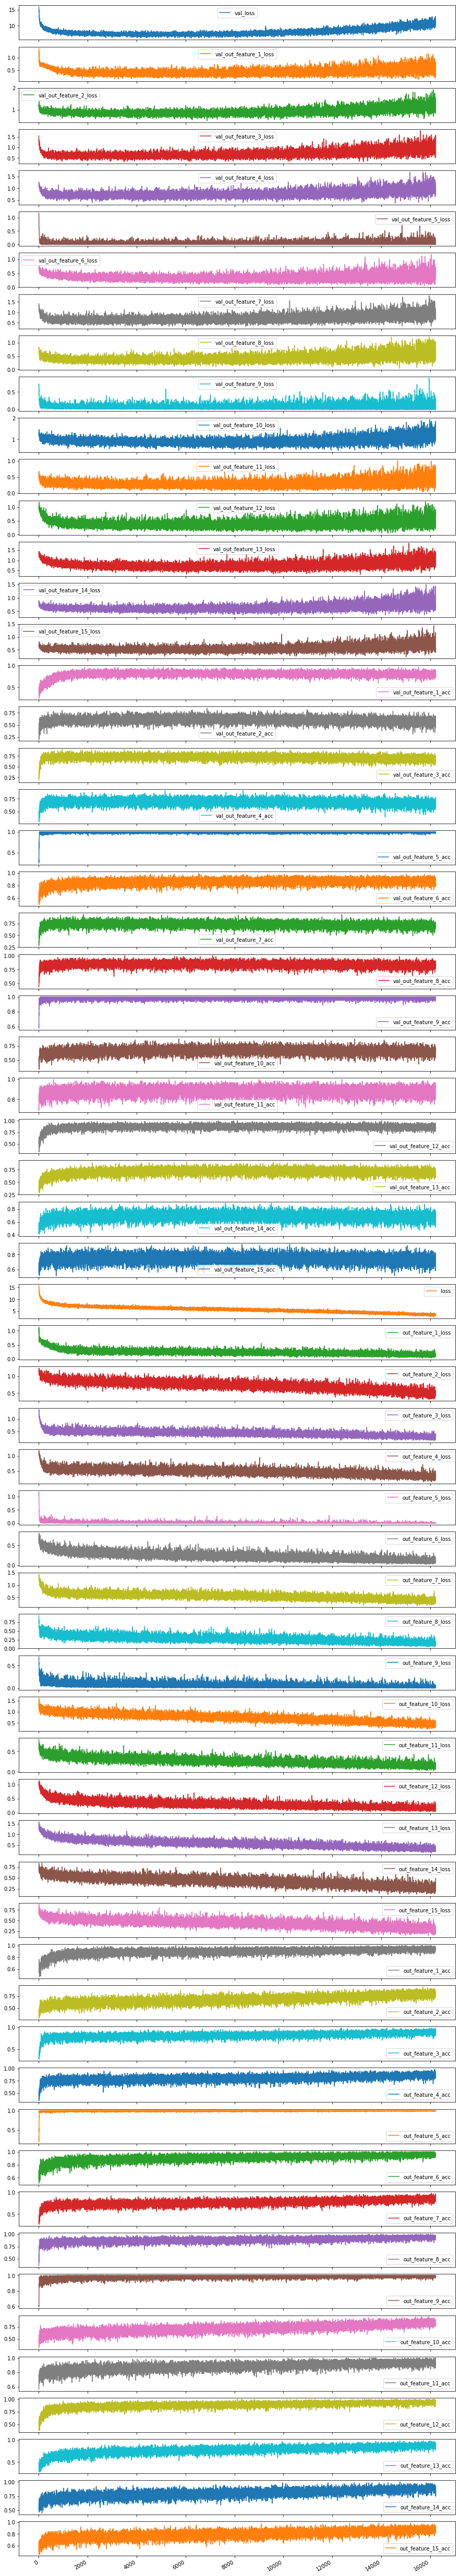

In [51]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
display(df_hist[df_hist['val_loss']<6.01])
# df_hist.to_csv('graphs-Multitask-TrainableEncoder-shuffled.csv')

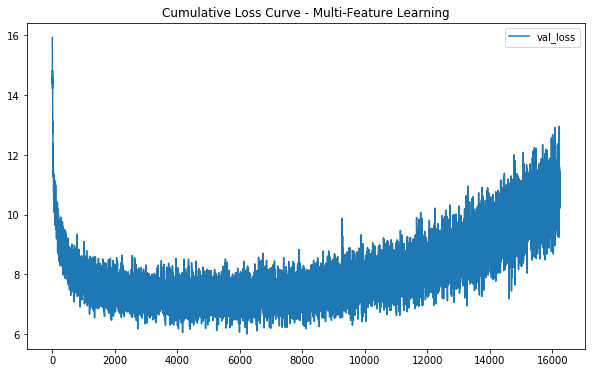

In [48]:
df_hist['val_loss'].plot(figsize=(10,6),grid=True, legend=True, title='Cumulative Loss Curve - Multi-Feature Learning')

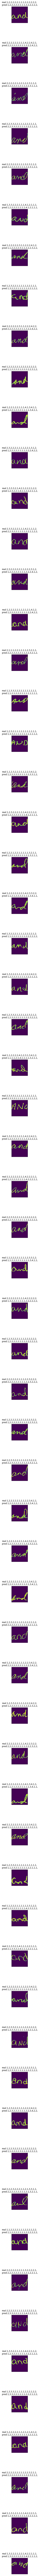

In [29]:
# human_features.load_weights('human_features_weights_v2.h5')
human_features.load_weights('weights/15-Multitask-TrainableEncoder-Shuffled_v1.h5')
vx,vo=next(vg)
# print(len(vo))
fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1.51, wspace=0.05)
for i in range(64):
#     print(i, '\nPredicted:')
    
    real=''
    for f in range(15):
#         print(vo[i][f])
        real+=str(np.argmax(vo[f][i])+1)+','
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))
#     print(f_probs)
    pred=''
    for prob in f_probs:
#         print(prob)
        pred+=str(np.argmax(prob[0])+1)+','
    
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real+'\n pred:'+pred)
#     print('\n----------')
#     print('True:')
#     for op in o:
#         print(np.argmax(op[i]),end=',')
        
#     print('\n++++++',i,'++++++')

In [30]:
# print(df_hist.columns)
total = 0
for i in range(1,16):
    print(df_hist.iloc[5699]['val_out_feature_{0}_acc'.format(i)].max())
    total+=df_hist.iloc[5699]['val_out_feature_{0}_acc'.format(i)]
print('total_acc:',total/15)
# print(np.mean([df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max()]))
# df_hist[df_hist['val_acc']>10.2]

0.75
0.578125
0.6875
0.640625
0.984375
0.890625
0.65625
0.78125
0.96875
0.609375
0.890625
0.921875
0.75
0.6875
0.640625
total_acc: 0.7625


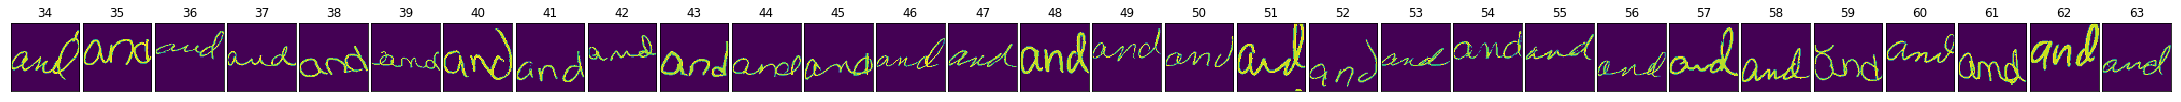

In [31]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(30):
    ax = fig.add_subplot(1, 30, i + 1, xticks=[], yticks=[])
    ax.imshow(inputs[64-30:64][i].reshape((64,64)))
    ax.set_title(i+34)

In [32]:
# plt.imshow(inputs[10].reshape((64,64)))
# plt.subplots_adjust(hspace = 0.1)
# for i in range(1,9):
#     visualize_model = Model(human_features.input, human_features.get_layer('dense_layer_'+str(i)).output)
#     vis_out = visualize_model.predict(np.expand_dims(inputs[10],0))[0]
#     vis_out = np.rollaxis(a=vis_out, start=0, axis=2)
#     f,ax = plt.subplots(8,8)
#     f.subplots_adjust(hspace = .00, wspace=.02, top=0.95)
#     f.set_size_inches(15,15)
#     f.suptitle('dense_layer_'+str(i), fontsize=15)
# #     f.subplots_adjust(hspace = 0.1)
# #     plt.title('dense_layer_'+str(i))
#     print(vis_out.shape)
#     for r in range(8):
#         for c in range (8):
#             ax[r,c].imshow(vis_out[c+r*8])
#             ax[r,c].axis('off')
# #     break

In [33]:
csv_data.var()

pen_pressure      0.241190
letter_spacing    0.481638
size              0.475689
dimension         0.464579
is_lowercase      0.014808
is_continuous     0.222378
slantness         0.866958
tilt              0.152430
entry_stroke_a    0.053592
staff_of_a        0.862689
formation_n       0.176950
staff_of_d        0.409782
exit_stroke_d     1.054210
word_formation    0.245240
constancy         0.239313
dtype: float64

# Evaluation

In [52]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
from tqdm import tqdm_notebook

In [72]:
pred_flat = []
for i in range(1,len(feature_lengths)+1):
    pred_flat.append(human_features.get_layer('out_feature_'+str(i)).output)
human_features_eval = Model(inputs=human_features.input, outputs=pred_flat)
human_features_encoder = Model(human_features.input,human_features.get_layer('encoded').output)

In [54]:
test_g = datagen(len(val_images)*5,val_path,val_images, vshift = (-10,10), vis=True)
testx,testy = next(test_g)

In [73]:
feature_wise_pred_y=human_features_eval.predict(testx)
latent_pred_y=human_features_encoder.predict(testx)

In [56]:
feature_wise_pred_y=np.array(feature_wise_pred_y)
latent_pred_y=np.array(latent_pred_y).reshape((-1,512))

In [57]:
latent_pred_y.shape,feature_wise_pred_y.shape

((9855, 512), (15, 9855, 128))

In [58]:
testy[0].shape,testy[1].shape

((9855,), (9855,))

In [59]:
ids = testy[0].reshape(-1,1)
imagenames = testy[1].reshape(-1,1)
data=[]
for i in range(len(testx)):
    data.append([ids[i][0],imagenames[i][0],latent_pred_y[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
# df_outs['ids'] = ids
# df_outs['preds'] = preds 
df_data=df_data.sort_values(by='identity').reset_index()
df_data.head(10)

index identity       imagename  \
0   1687     0001  0001c_num3.png   
1   8021     0001  0001a_num3.png   
2   2867     0001  0001c_num5.png   
3   6748     0001  0001c_num1.png   
4   2747     0001  0001c_num2.png   
5   2875     0001  0001a_num5.png   
6   6779     0001  0001c_num2.png   
7   7863     0001  0001c_num2.png   
8   3274     0001  0001b_num2.png   
9   9623     0001  0001c_num2.png   

                                              latent  
0  [0.0, 0.0, 0.2740433, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [0.0, 0.0, 1.2332693, 0.0, 0.0, 4.5487523, 0.0...  
2  [0.0, 0.0, 1.9360113, 0.82231843, 0.0, 1.60534...  
3  [0.0, 0.0, 0.509836, 0.0, 0.0, 2.0204663, 0.0,...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.4050596, 0.0, 0.0,...  
5  [0.0, 0.0, 1.7680708, 0.0, 0.0, 2.2608151, 0.0...  
6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.30485657, 0.0, 0.0...  
7  [0.0, 0.0, 0.114930786, 0.0, 0.0, 0.38940123, ...  
8  [0.0, 0.0, 0.7504161, 0.0, 0.0, 2.4576075, 0.0...  
9  [0.0, 0.0, 0.14284079, 0.0, 0.0, 0.51730406, 0...

In [61]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))

In [66]:
queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.8
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 20
prev_query = ''
prev_given = ''
given_count = 0
# total = cos_dist_out.shape[0]
for row in tqdm_notebook(cos_dist_out):
    c_counter = 0
    given_idx = df_data.iloc[r_counter]['identity']
    given_img = df_data.iloc[r_counter]['imagename']
    for col in row:
        queried_idx = df_data.iloc[c_counter]['identity']
        queried_img = df_data.iloc[c_counter]['imagename']
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            tp += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            tn += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            fp += 1
            fp_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            fn += 1
            fn_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx):
            idx_count += 1
#             print('--i--',idx_count,'--i--')
#             print(given_idx,queried_idx)
        if prev_query != queried_idx:
#             print('--q--',queried_count,'--q--')
            queried_count += 1
        c_counter += 1
        prev_query = queried_idx
#         if queried_count == stop_at:
#             break
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    total = np.sum((tp,tn,fp,fn))
    accuracy = (tp+tn)/total
    data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
    if prev_given != given_idx:
#         print('----',given_count,'-----')
        given_count+=1
    r_counter += 1
    prev_given = given_idx
    queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
    fp_list = []
    fn_list = []
#     if given_count == stop_at:
#         break

In [67]:
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity',ascending=True).reset_index().drop(columns=['index'])
df_cos_dist_out.head()

identity       imagename  total_images_identity  TP    TN   FP  FN  \
0     0001  0001c_num3.png                     44  30  9742   69  14   
1     0001  0001c_num1.png                     44  44  9560  251   0   
2     0001  0001b_num3.png                     44  37  9429  382   7   
3     0001  0001c_num2.png                     44  44  9497  314   0   
4     0001  0001c_num3.png                     44  36  9699  112   8   

   precision    recall        f1  accuracy  total_images  \
0   0.303030  0.681818  0.419580  0.991578          9855   
1   0.149153  1.000000  0.259587  0.974531          9855   
2   0.088305  0.840909  0.159827  0.960528          9855   
3   0.122905  1.000000  0.218905  0.968138          9855   
4   0.243243  0.818182  0.375000  0.987823          9855   

                                             FP_List  \
0  [0041/0041a_num1.png, 0041/0041a_num1.png, 004...   
1  [0008/0008b_num2.png, 0009/0009a_num5.png, 002...   
2  [0005/0005b_num5.png, 0005/0005b_num5.png, 000...   
3  [0021/0021c_num3.png, 0021/0021c_num3.png, 002...   
4  [0006/0006b_num5.png, 0041/0041a_num1.png, 004...   

                                             FN_List  
0  [0001/0001a_num3.png, 0001/0001c_num5.png, 000...  
1                                                 []  
2  [0001/0001c_num5.png, 0001/0001c_num5.png, 000...  
3                                                 []  
4  [0001/0001a_num3.png, 0001/0001a_num5.png, 000...

In [68]:
# print(df_cos_dist_out.keys())
total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
precision = tps/(fps+tps)
recall = tps/(tps+fns)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)

precision: 0.032013649670978625 
recall: 0.7827984648681037 
f1: 0.06151169176330486
Intra Writer Accuracy (Type 1): 0.8098913555322617
Inter Writer Accuracy (Type 2):: 0.9508248909028709
acc: 0.9523853048297215


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
from tqdm import tqdm_notebook

In [74]:
l = feature_wise_pred_y.s
r = feature_wise_pred_y[:,1,:]

TypeError: list indices must be integers or slices, not tuple

In [78]:
np.shape(feature_wise_pred_y[1])

(9855, 3)

In [ ]:
# df_feat_sim_score.style.bar(subset=['feature similarity score'], color='lightblue', align='mid')

In [ ]:
class_preds = human_features.predict(test_x[:2])

In [ ]:
for i in range(len(test_x[:2])):
    for f in range(15):
        print(np.argmax(class_preds[f][i]),end=',')
    print('')

In [106]:
# df_cos_dist_out.to_csv('results-DL_AE_Maxpool_1x1x512_Shuffled.csv')
# left_image = '0103b_num1.png'
# right_image = '0012c_num3.png' #0 similarity
left_image = '0021c_num8.png'
right_image = '0021a_num1.png' #0 similarity

test_im_normal = (255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/'+left_image,0))/255.0
test_im_shifted = (255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/'+right_image,0))/255.0
py1 = human_features_encoder.predict(test_im_normal.reshape((1,64,64,1)))
py2 = human_features_encoder.predict(test_im_shifted.reshape((1,64,64,1)))
l = human_features_eval.predict(test_im_normal.reshape((1,64,64,1)))
r = human_features_eval.predict(test_im_shifted.reshape((1,64,64,1)))
# l = l.reshape(15,-1)
# r = r.reshape(15,-1)
print(py1[py1==0].shape,py2[py2==0].shape)
py1 = py1.reshape((-1,512))
py2 = py2.reshape((-1,512))
print(py1.shape,py2.shape)

cosine_similarity(py1,py2), cosine_distances(py1,py2), euclidean_distances(py1,py2)

(255,) (242,)
(1, 512) (1, 512)


(array([[0.7291376]], dtype=float32),
 array([[0.2708624]], dtype=float32),
 array([[24.791689]], dtype=float32))

In [107]:
# features = csv_data.keys()[1:]
# feature_similarity_score=cosine_similarity(l,r).diagonal()
# df_feat_sim_score = pd.DataFrame(columns=['features','feature similarity score'])
# df_feat_sim_score['features']=features
# df_feat_sim_score['feature similarity score']=feature_similarity_score
# ax = df_feat_sim_score.plot.barh(width=0.85
#                                  , rot=0
#                                  , x='features'
#                                  , color='lightblue'
#                                  , fontsize=14
#                                  , figsize=(5,8)
#                                  , grid=True)
# df_feat_sim_score['feature similarity score'].mean()
# counter=-1
# ax.legend(bbox_to_anchor=(0.75,-0.05)
#           , fontsize=14)
# ax.grid(color='#bebebe'
#         , linestyle='-.'
#         , linewidth=0.5)
# plt.ylabel('features',fontsize=14)
# for p in ax.patches:
#     counter+=1
#     ax.annotate(str(p.get_width()), (0.25, counter*0.99))
# feature_similarity_score.sum()/15.0

Medium Medium [[0.9999636]]
Medium Medium [[0.95882064]]
Large Medium [[0.40786803]]
Medium Medium [[0.7943175]]
Yes Yes [[1.]]
No Yes [[0.54869443]]
Normal Slight Right [[0.21602573]]
Normal Normal [[0.9980246]]
No Stroke No Stroke [[0.9999675]]
Retraced Retraced [[0.9745635]]
Normal Normal [[0.9999529]]
Loopy Loopy [[0.86809134]]
Downstroke Downstroke [[0.9997084]]
Wellformed Wellformed [[0.992506]]
Regular Regular [[0.99932694]]


features Left Classes Right Classes
0     pen_pressure       Medium        Medium
1   letter_spacing       Medium        Medium
2             size        Large        Medium
3        dimension       Medium        Medium
4     is_lowercase          Yes           Yes
5    is_continuous           No           Yes
6        slantness       Normal  Slight Right
7             tilt       Normal        Normal
8   entry_stroke_a    No Stroke     No Stroke
9       staff_of_a     Retraced      Retraced
10     formation_n       Normal        Normal
11      staff_of_d        Loopy         Loopy
12   exit_stroke_d   Downstroke    Downstroke
13  word_formation   Wellformed    Wellformed
14       constancy      Regular       Regular

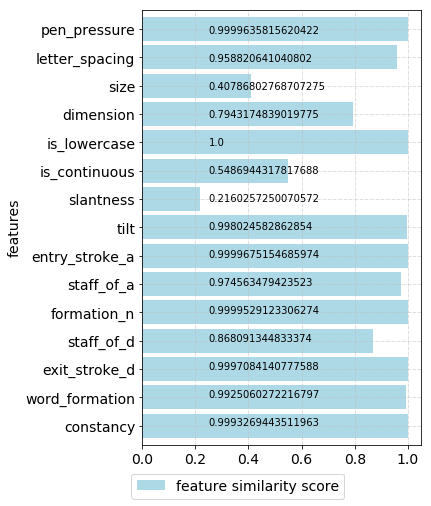

In [108]:
features = csv_data.keys()[1:]
feature_similarity_score = []
class_values = [['Strong','Medium']
 ,['Less','Medium','High']
 ,['Small','Medium','Large']
 ,['Low','Medium','High']
 ,['No','Yes']
 ,['No','Yes']
 , ['Normal','Slight Right', 'Very Right', 'Left']
 , ['Normal', 'Tilted']
 , ['No Stroke','Downstroke']
 , ['No Staff','Retraced', 'Loopy', 'Tented']
 , ['No Formation', 'Normal']
 , ['No Staff', 'Retraced', 'Loopy']
 , ['No Stroke','Downstroke', 'Curved Up', 'Straight Accross']
 , ['Not Wellformed','Wellformed']
 , ['Irregular','Regular']]
left_classes, right_classes = [],[]
for i in range(15):
    print(class_values[i][np.argmax(l[i])],class_values[i][np.argmax(r[i])],cosine_similarity(l[i],r[i]))
    left_classes.append(class_values[i][np.argmax(l[i])])
    right_classes.append(class_values[i][np.argmax(r[i])])
    feature_similarity_score.append(cosine_similarity(l[i],r[i])[0][0])
df_feat_classes = pd.DataFrame(columns=['features','Left Classes','Right Classes'])
df_feat_classes['features']=features
df_feat_classes['Left Classes']=left_classes
df_feat_classes['Right Classes']=right_classes
df_feat_sim_score = pd.DataFrame(columns=['features','feature similarity score'])
df_feat_sim_score['features']=list(reversed(features))
df_feat_sim_score['feature similarity score']=list(reversed(feature_similarity_score))
ax = df_feat_sim_score.plot.barh(width=0.85
                                 , rot=0
                                 , x='features'
                                 , color='lightblue'
                                 , fontsize=14
                                 , figsize=(5,8)
                                 , grid=True)
df_feat_sim_score['feature similarity score'].mean()
counter=-1
ax.legend(bbox_to_anchor=(0.75,-0.05)
          , fontsize=14)
ax.grid(color='#bebebe'
        , linestyle='-.'
        , linewidth=0.5)
plt.ylabel('features',fontsize=14)
for p in ax.patches:
    counter+=1
    ax.annotate(str(p.get_width()), (0.25, counter*0.99))
sum(feature_similarity_score)/15.0
df_feat_classes

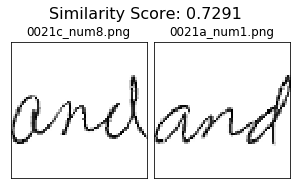

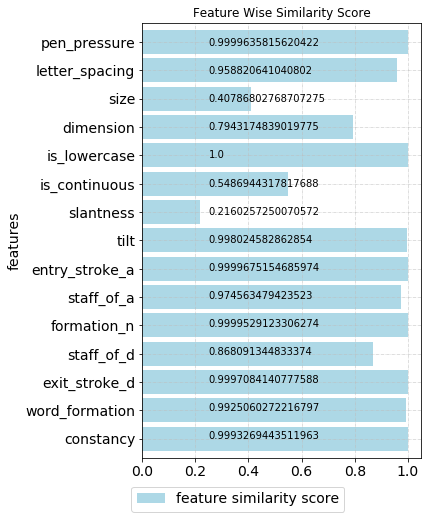

In [109]:


# print(test_im_normal.max())
f,ax = plt.subplots(1,2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,1*3)
f.suptitle('Similarity Score: '+str(np.round(cosine_similarity(py1,py2)[0][0],4)), fontsize=16)
ax[0].imshow(255.0-test_im_normal.reshape((64,64)),cmap="gray")
ax[0].axis('on')
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[1].imshow(255.0-test_im_shifted.reshape((64,64)),cmap="gray")
ax[1].axis('on')
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
ax[0].set_title(left_image)
ax[1].set_title(right_image)
ax = df_feat_sim_score.plot.barh(width=0.85
                                 , rot=0
                                 , x='features'
                                 , color='lightblue'
                                 , fontsize=14
                                 , figsize=(5,8)
                                 , grid=True
                                ,title='Feature Wise Similarity Score')
df_feat_sim_score['feature similarity score'].mean()
counter=-1
ax.legend(bbox_to_anchor=(0.75,-0.05)
          , fontsize=14)
ax.grid(color='#bebebe'
        , linestyle='-.'
        , linewidth=0.5)
plt.ylabel('features',fontsize=14)
for p in ax.patches:
    counter+=1
    ax.annotate(str(p.get_width()), (0.25, counter*0.99))

In [100]:
classes_values = [['Strong','Medium']
 ,['Less','Medium','High']
 ,['Small','Medium','Large']
 ,['Low','Medium','High']
 ,['No','Yes']
 ,['No','Yes']
 , ['Normal','Slight Right', 'Very Right', 'Left']
 , ['Normal', 'Tilted']
 , ['No Stroke','Downstroke']
 , ['No Staff','Retraced', 'Loopy', 'Tented']
 , ['No Formation', 'Normal']
 , ['No Staff', 'Retraced', 'Loopy']
 , ['No Stroke','Downstroke', 'Curved Up', 'Straight Accross']
 , ['Not Wellformed','Wellformed']
 , ['Irregular','Regular']]